In [141]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import os
import sys
import shutil
import glob
import json

import warnings
warnings.filterwarnings("ignore")


In [142]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA


import antares_client

plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'  #for MacOS, make plots crisp

In [143]:
def panstarrs_image_filename(position,image_size=None, filter=None):
    """Query panstarrs service to get a list of image names
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :size : int: cutout image size in pixels.
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :filename: str: file name of the cutout
    """

    service = 'https://ps1images.stsci.edu/cgi-bin/ps1filenames.py'
    url = (f'{service}?ra={position.ra.degree}&dec={position.dec.degree}'
           f'&size={image_size}&format=fits&filters={filter}')

    filename_table = pd.read_csv(url, delim_whitespace=True)['filename']
    return filename_table[0] if len(filename_table) > 0 else None

    
def panstarrs_cutout(position, filename, image_size=None, filter=None):
    """
    Download Panstarrs cutout from their own service
    Parameters
    ----------
    :position : :class:`~astropy.coordinates.SkyCoord`
        Target centre position of the cutout image to be downloaded.
    :image_size: int: size of cutout image in pixels
    :filter: str: Panstarrs filter (g r i z y)
    Returns
    -------
    :cutout : :class:`~astropy.io.fits.HDUList` or None
    """
    
    if filename:
        service = 'https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?'
        fits_url = (f'{service}ra={position.ra.degree}&dec={position.dec.degree}'
                    f'&size={image_size}&format=fits&red={filename}')
        fits_image = fits.open(fits_url)
    else:
        fits_image = None

    return fits_image

In [144]:
def host_pdfs(df,imsizepix=100,change_contrast=False):
        
        # let's make a PDF with all the host gal coords
        # so we can look through by eye and see which ones

        ref_name = df.name[0]
        data = df
        
        pdf_pages = PdfPages(f'../figures/{ref_name}_host_thumbnails.pdf')

        for i, d in df.iterrows():
            
            stamp_path = f"../ps1_cutouts/{d['name']}_pscutout.fits"
            if os.path.isfile(stamp_path): 
                #print(f"Remove previously saved cutout {d['name']}_pscutout.fits to download new one")
                os.remove(stamp_path)
            
            #if i > 20: break
            if not i % 9:
                fig = plt.figure(figsize=(6,6))
                
            #fig = plt.figure()
            
            ax = plt.subplot(3,3,i%9+1)

            ax.set_xticks([])
            ax.set_yticks([])

            # download the PS image
            sc = SkyCoord(d['ra'],d['dec'],unit=u.deg)

            outfilename = f"../ps1_cutouts/{d['name']}_pscutout.fits"
            if not os.path.exists(outfilename):
                filename = panstarrs_image_filename(sc,image_size=imsizepix,filter='r')
                fits_image = panstarrs_cutout(sc,filename,image_size=imsizepix,filter='r')
                fits_image.writeto(outfilename)
                
            wcs = WCS(f"../ps1_cutouts/{d['name']}_pscutout.fits")

            imdata = fits.getdata(f"../ps1_cutouts/{d['name']}_pscutout.fits")

            if change_contrast==True:
                transform = AsinhStretch() + PercentileInterval(93)
            
            else: transform = AsinhStretch() + PercentileInterval(99.5)
            bfim = transform(imdata)
            ax.imshow(bfim,cmap="gray",origin="lower")
            #ax.plot(imsizepix/2,imsizepix/2,'+',color='r',ms=15)
                
            ax.set_title(f"{d['name']}",pad=1, fontsize=14)

            if i % 9 == 8:
                plt.ion()
                plt.show()
                #plt.subplots_adjust(0,0,1,1,-0.05,0.05)
                pdf_pages.savefig(fig, bbox_inches='tight', pad_inches=0.1)
                plt.close()
         
        pdf_pages.close()
        plt.show()
        

In [145]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
#   'zmomentXX',
#  'zmomentXY',
#  'zmomentYY',
#  'zmomentR1',
#  'zmomentRH',
#  'zPSFFlux',
# #  'zPSFFluxErr',
#  'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
#  'zKronFlux',
# #  'zKronFluxErr',
#  'zKronRad',
# #  'zexpTime',
#   'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
#   'ymomentXX',
#   'ymomentXY',
#   'ymomentYY',
#   'ymomentR1',
#   'ymomentRH',
#   'yPSFFlux',
# #   'yPSFFluxErr',
#   'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
#  'yKronFlux',
# #  'yKronFluxErr',
#  'yKronRad',
# #  'yexpTime',
#   'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
#    'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
#  'zApMag_zKronMag',
#  'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

lc_and_host_features = feature_names_r_g+feature_names_hostgal

In [146]:
# dataset was created by dropping 'sdss_stars', 'asassn_variable_catalog', 'asassn_variable_catalog_v2_20190802', 'veron_agn_qso'
# 'bright_guide_star_cat' is sometimes a galaxy, so keep
dataset_bank_90k = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,)
                                  #)
        
# drop row if any feature values are nan
dataset_bank_90k = dataset_bank_90k[~dataset_bank_90k[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank_90k.drop_duplicates(subset="ztf_object_id", keep='first', inplace=True)
dataset_bank_90k = dataset_bank_90k.set_index('ztf_object_id')
dataset_bank_90k.index.rename("TransientName", inplace=True)
dataset_bank_90k

Unnamed: 0        locus_id          ra        dec  \
TransientName                                                      
ZTF20acpdyyq            6    ANT2020rajqu   33.976088 -20.258905   
ZTF18acfvwwa           39    ANT2020pc6ko   35.639509  32.833982   
ZTF17aaaskvj           58    ANT2020rdpmm   28.015003  36.953217   
ZTF18aczbnhl           97    ANT2019dsk24   85.049145 -11.013302   
ZTF18actbhqt           98    ANT202066j3s   75.082443 -11.302676   
...                   ...             ...         ...        ...   
ZTF18adairvu       999924    ANT2020ro626   84.348727  -2.927551   
ZTF20aaiwhct       999926    ANT2020pxghw   64.146691  -1.656598   
ZTF20aberawv       999927    ANT2020aebbk  292.910293  54.078978   
ZTF21abhjyor       999964  ANT2020aeedowi  323.724711  31.249401   
ZTF18acfdttb       999987    ANT2020fc5ny  295.091491  55.660204   

                                              tags  \
TransientName                                        
ZTF20acpdyyq              ['lc_feature_extractor']   
ZTF18acfvwwa              ['lc_feature_extractor']   
ZTF17aaaskvj              ['lc_feature_extractor']   
ZTF18aczbnhl              ['lc_feature_extractor']   
ZTF18actbhqt              ['lc_feature_extractor']   
...                                            ...   
ZTF18adairvu              ['lc_feature_extractor']   
ZTF20aaiwhct   ['dimmers', 'lc_feature_extractor']   
ZTF20aberawv   ['lc_feature_extractor', 'dimmers']   
ZTF21abhjyor              ['lc_feature_extractor']   
ZTF18acfdttb   ['lc_feature_extractor', 'dimmers']   

                                                        catalogs ztf_ssnamenr  \
TransientName                                                                   
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF17aaaskvj   ['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...          NaN   
ZTF18aczbnhl   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18actbhqt   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
...                                                          ...          ...   
ZTF18adairvu   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF20aaiwhct    ['gaia_dr2', 'bright_guide_star_cat', 'allwise']          NaN   
ZTF20aberawv                                                  []          NaN   
ZTF21abhjyor                                                  []          NaN   
ZTF18acfdttb   ['2mass_psc', 'allwise', 'gaia_dr2', 'bright_g...          NaN   

               num_alerts  num_mag_values                    oldest_alert_id  \
TransientName                                                                  
ZTF20acpdyyq          137              35   ztf_candidate:993481181415010007   
ZTF18acfvwwa          659              88   ztf_candidate:943483942915015010   
ZTF17aaaskvj         1497             579   ztf_candidate:598425334815010002   
ZTF18aczbnhl          105              12   ztf_candidate:718232301815010005   
ZTF18actbhqt           89              14   ztf_candidate:702289832715010026   
...                   ...             ...                                ...   
ZTF18adairvu           96              10   ztf_candidate:722282332515010003   
ZTF20aaiwhct           86              35  ztf_candidate:1113204944015010026   
ZTF20aberawv          235              96  ztf_candidate:1231482062015010023   
ZTF21abhjyor          118              19  ztf_candidate:1358283950415015003   
ZTF18acfdttb          290              14   ztf_candidate:966286933415010005   

               ...  anom_score  anomaly_score anomaly_mask  anomaly_type  \
TransientName  ...                                                         
ZTF20acpdyyq   ...         NaN            NaN          NaN           NaN   
ZTF18acfvwwa   ...         NaN            NaN          NaN           NaN   
ZTF17aaaskvj   ...         N

In [147]:
%%time

# Instead of above, read in from csv files with host gal info!
# Visually vetted GHOST results split up over XXX files
# So merge them

dfs = []
for start_idx, end_idx in zip(range(0, 90100, 100), range(100, 90200, 100)): #90199, 90299
    df = pd.read_csv(f'./host_info/dataset_bank_hosts_start_idx:end_idx={start_idx}:{end_idx}.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df.drop_duplicates(subset="TransientName", keep='first', inplace=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
#g_hosts_df.reset_index(inplace=True, drop=True)
g_hosts_df

CPU times: user 17.6 s, sys: 1.69 s, total: 19.3 s
Wall time: 21.2 s


objName  objAltName1  objAltName2  \
TransientName                                                          
AT2019ye        PSO J135804.487+203809.056          NaN          NaN   
PS18acw         PSO J203708.962-044523.671          NaN          NaN   
PS18kz          PSO J132531.079-142122.461          NaN          NaN   
SDSS-IISN17461  PSO J034305.548+001507.550          NaN          NaN   
SN2016ezh       PSO J015804.744+005221.791          NaN          NaN   
...                                    ...          ...          ...   
ZTF21acqetxn    PSO J235011.541+191045.231          NaN          NaN   
ZTF21acqnurt    PSO J223925.671-022448.679          NaN          NaN   
ZTF21acqoloi    PSO J231829.296-011726.224          NaN          NaN   
ZTF21acqqnqg    PSO J220138.675-131925.285          NaN          NaN   
ZTF21acqtdnd    PSO J093828.017+725409.070          NaN          NaN   

                objAltName3               objID    uniquePspsOBid  \
TransientName                                                       
AT2019ye                NaN  132762095186853570   916270000024592   
PS18acw                 NaN  102293092873892523  1049658000060517   
PS18kz                  NaN   90772013794782874  1040248000047767   
SDSS-IISN17461          NaN  107690557731417905   943938000022176   
SN2016ezh               NaN  106950295197783171   927303000104953   
...                     ...                 ...               ...   
ZTF21acqetxn            NaN  131013575480825509  1076778000026511   
ZTF21acqnurt            NaN  105103398569764184  1076249000094978   
ZTF21acqoloi            NaN  106453496221281681  1082715000043887   
ZTF21acqqnqg            NaN   92013304111661908  1034256000047270   
ZTF21acqtdnd            NaN  195481446166893818  1082796000034886   

                       ippObjID  surveyID           htmID  zoneID  ...  \
TransientName                                                      ...   
AT2019ye        143378893266959         0  14931762990582   13276  ...   
PS18acw         397026776902759         0  12246887638605   10229  ...   
PS18kz          422246824852118         0  11265143992289    9077  ...   
SDSS-IISN17461  365716465276576         0   9423182795338   10769  ...   
SN2016ezh       363457312561658         0   8961418540888   10695  ...   
...                         ...       ...             ...     ...  ...   
ZTF21acqetxn    161254547154832         0  13215295323352   13101  ...   
ZTF21acqnurt    400995326718721         0  12661889120003   10510  ...   
ZTF21acqoloi    401837140257649         0  12704687240487   10645  ...   
ZTF21acqqnqg    439985039784102         0  12743362206187    9201  ...   
ZTF21acqtdnd    343739117635654         0  15896420451026   19548  ...   

                primaryDetection_y   gpetR90  rpetR90  ipetR90  zpetR90  \
TransientName                                                             
AT2019ye                       NaN       NaN      NaN      NaN      NaN   
PS18acw                        NaN       NaN      NaN      NaN      NaN   
PS18kz                         NaN       NaN      NaN      NaN      NaN   
SDSS-IISN17461                 NaN       NaN      NaN      NaN      NaN   
SN2016ezh                      NaN       NaN      NaN      NaN      NaN   
...                            ...       ...      ...      ...      ...   
ZTF21acqetxn                   1.0  11.96380  5.68306  3.76124  3.02015   
ZTF21acqnurt                   1.0  15.28430  2.52730  1.53292  1.24170   
ZTF21acqoloi                   1.0       NaN  9.90200  2.44196  1.46597   
ZTF21acqqnqg                   1.0   1.55909      NaN      NaN      NaN   
ZTF21acqtdnd                   1.0   2.12782  1.17645  1.70294  1.72939   

                ypetR90  NED_redshift_flag  hasSimbad  class  level_0  
TransientName                                                          
AT2019ye            NaN                NaN        NaN    NaN      NaN  
PS18acw             NaN                NaN   

In [148]:
len(np.unique(g_hosts_df.index))

24126

In [149]:
# merge ghost info and databank info

# rename as dataset_bank
dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='inner')
dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank.to_csv('../dataframes/dataset_bank.csv')
dataset_bank

Unnamed: 0        locus_id          ra        dec  \
ztf_object_id                                                      
ZTF20acpdyyq            6    ANT2020rajqu   33.976088 -20.258905   
ZTF18acfvwwa           39    ANT2020pc6ko   35.639509  32.833982   
ZTF17aaaskvj           58    ANT2020rdpmm   28.015003  36.953217   
ZTF18actbhqt           98    ANT202066j3s   75.082443 -11.302676   
ZTF20aciscxz          100  ANT2020aegc7vi   83.973369  -9.123083   
...                   ...             ...         ...        ...   
ZTF19aaweyrl       998543    ANT2020ay2n2  345.352155  29.567523   
ZTF18aaxheyx       998559    ANT2020dpu72  252.069272  57.974137   
ZTF20abhzatf       998591    ANT2020c3ksm  337.612801  15.317709   
ZTF18aasbhzf       998605    ANT2018brtio  238.621821  49.056094   
ZTF21aamjuma       998678    ANT2020as5g6  173.338794  78.671393   

                                                            tags  \
ztf_object_id                                                      
ZTF20acpdyyq                            ['lc_feature_extractor']   
ZTF18acfvwwa                            ['lc_feature_extractor']   
ZTF17aaaskvj                            ['lc_feature_extractor']   
ZTF18actbhqt                            ['lc_feature_extractor']   
ZTF20aciscxz   ['lc_feature_extractor', 'high_flux_ratio_wrt_...   
...                                                          ...   
ZTF19aaweyrl                            ['lc_feature_extractor']   
ZTF18aaxheyx                            ['lc_feature_extractor']   
ZTF20abhzatf                            ['lc_feature_extractor']   
ZTF18aasbhzf                            ['lc_feature_extractor']   
ZTF21aamjuma                            ['lc_feature_extractor']   

                                                        catalogs ztf_ssnamenr  \
ztf_object_id                                                                   
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF17aaaskvj   ['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...          NaN   
ZTF18actbhqt   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']          NaN   
...                                                          ...          ...   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']          NaN   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...          NaN   
ZTF20abhzatf   ['bright_guide_star_cat', 'allwise', 'gaia_dr2...          NaN   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']          NaN   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...          NaN   

               num_alerts  num_mag_values                    oldest_alert_id  \
ztf_object_id                                                                  
ZTF20acpdyyq          137              35   ztf_candidate:993481181415010007   
ZTF18acfvwwa          659              88   ztf_candidate:943483942915015010   
ZTF17aaaskvj         1497             579   ztf_candidate:598425334815010002   
ZTF18actbhqt           89              14   ztf_candidate:702289832715010026   
ZTF20aciscxz           48              18  ztf_candidate:1356481843915015002   
...                   ...             ...                                ...   
ZTF19aaweyrl          354             244   ztf_candidate:880431555615015015   
ZTF18aaxheyx          467              12   ztf_candidate:947281676115015110   
ZTF20abhzatf          377              42  ztf_candidate:1245430851515015125   
ZTF18aasbhzf          264              18   ztf_candidate:533261233215015023   
ZTF21aamjuma          561             107   ztf_candidate:711540675115010006   

               ...  primaryDetection_y   gpetR90  rpetR90    ipetR90  zpetR90  \
ztf_object_id  ...                                                   

In [150]:
dataset_bank.columns.to_list()

['Unnamed: 0',
 'locus_id',
 'ra',
 'dec',
 'tags',
 'catalogs',
 'ztf_ssnamenr',
 'num_alerts',
 'num_mag_values',
 'oldest_alert_id',
 'oldest_alert_magnitude',
 'oldest_alert_observation_time',
 'newest_alert_id',
 'newest_alert_magnitude',
 'newest_alert_observation_time',
 'brightest_alert_id',
 'brightest_alert_magnitude',
 'brightest_alert_observation_time',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_linear_trend_magn_g',
 'feature_linear_trend_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation

In [151]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features]
dataset_bank_orig.isnull().sum().to_dict() # see which columns have most NaNs

{'feature_amplitude_magn_r': 0,
 'feature_anderson_darling_normal_magn_r': 0,
 'feature_beyond_1_std_magn_r': 0,
 'feature_beyond_2_std_magn_r': 0,
 'feature_cusum_magn_r': 0,
 'feature_inter_percentile_range_2_magn_r': 0,
 'feature_inter_percentile_range_10_magn_r': 0,
 'feature_inter_percentile_range_25_magn_r': 0,
 'feature_kurtosis_magn_r': 0,
 'feature_linear_fit_slope_magn_r': 0,
 'feature_linear_fit_slope_sigma_magn_r': 0,
 'feature_linear_trend_magn_r': 0,
 'feature_linear_trend_sigma_magn_r': 0,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 0,
 'feature_magnitude_percentage_ratio_20_5_magn_r': 0,
 'feature_mean_magn_r': 0,
 'feature_median_absolute_deviation_magn_r': 0,
 'feature_percent_amplitude_magn_r': 0,
 'feature_median_buffer_range_percentage_10_magn_r': 0,
 'feature_median_buffer_range_percentage_20_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_5_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_10_magn_r': 0,
 'feature_period_s_to_n_0_

In [152]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features] #dataset_bank[feature_names_r_g]
# drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]

dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF20aciscxz                   0.285049   
ZTF18abdkosj                   1.776150   
ZTF18abrcoty                   0.072900   
...                                 ...   
ZTF18aczcgiz                   0.542735   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF20aciscxz                                -0.425467   
ZTF18abdkosj                                -0.175299   
ZTF18abrcoty                                -0.738972   
...                                               ...   
ZTF18aczcgiz                                -0.273649   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF20aciscxz                      0.384615                     0.000000   
ZTF18abdkosj                      0.200000                     0.000000   
ZTF18abrcoty                      0.250000                     0.000000   
...                                    ...                          ...   
ZTF18aczcgiz                      0.300000                     0.000000   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF20aciscxz               0.375905                                 0.570099   
ZTF18abdkosj               0.353906                                 3.552299   
ZTF18abrcoty               0.358274                                 0.145800   
...                             ...                                      ...   
ZTF18aczcgiz               0.372288                                 1.085470   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF20aciscxz                                   0.455701   
ZTF18abdkosj                                   3.552299   
ZTF18abrcoty                                   0.145800   
...                                                 ...   
ZTF18aczcgiz                                   0.911212   
ZTF19aaweyrl                                   0.798832   
ZTF18aaxheyx                                   1.864073   
ZTF18aasbhzf                                   

In [153]:
dataset_bank_host_ra_dec = dataset_bank[['raMean', 'decMean']]

dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_host_ra_dec, dataset_bank_orig], axis=1)
dataset_bank_orig_host_ra_dec.to_csv('../dataframes/dataset_bank_orig_host_ra_dec.csv')
dataset_bank_orig_host_ra_dec

raMean    decMean  feature_amplitude_magn_r  \
ztf_object_id                                                    
ZTF20acpdyyq    33.970428 -20.262357                  0.514069   
ZTF18acfvwwa    35.632326  32.837878                  0.593122   
ZTF17aaaskvj    28.019186  36.949659                       NaN   
ZTF18actbhqt    75.082493 -11.302689                       NaN   
ZTF20aciscxz    83.973390  -9.123059                  0.285049   
...                   ...        ...                       ...   
ZTF19aaweyrl   345.352146  29.567533                  0.730350   
ZTF18aaxheyx   252.077199  57.976291                  0.932036   
ZTF20abhzatf   337.612622  15.317868                       NaN   
ZTF18aasbhzf   238.602751  49.060376                  0.373769   
ZTF21aamjuma   173.360681  78.670541                  0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF17aaaskvj                                      NaN   
ZTF18actbhqt                                      NaN   
ZTF20aciscxz                                -0.425467   
...                                               ...   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF20abhzatf                                      NaN   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF17aaaskvj                           NaN                          NaN   
ZTF18actbhqt                           NaN                          NaN   
ZTF20aciscxz                      0.384615                     0.000000   
...                                    ...                          ...   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF20abhzatf                           NaN                          NaN   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF17aaaskvj                    NaN                                      NaN   
ZTF18actbhqt                    NaN                                      NaN   
ZTF20aciscxz               0.375905                                 0.570099   
...                             ...                                      ...   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF20abhzatf                    NaN                                      NaN   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF17aaaskvj                                        NaN   
ZTF18actbhqt                                        NaN   
ZTF20aciscxz                                   

In [154]:
dataset_bank_catalogs = dataset_bank[['catalogs']]

dataset_bank_orig_catalogs = pd.concat([dataset_bank_catalogs, dataset_bank_orig], axis=1)

# bright_guide_star_cat unfortunately has some non stars that are good galaxies with SN in them...
dataset_bank_orig_catalogs_no_bright_star = dataset_bank_orig_catalogs[~dataset_bank_orig_catalogs['catalogs'].str.contains('bright_guide_star_cat')]
dataset_bank_orig_catalogs_no_bright_star.to_csv('../dataframes/dataset_bank_orig_catalogs_no_bright_guide_star_cat.csv')
dataset_bank_orig_catalogs_no_bright_star

catalogs  feature_amplitude_magn_r  \
ztf_object_id                                                      
ZTF18abrcoty             ['2mass_xsc']                  0.072900   
ZTF18aatckag   ['allwise', 'gaia_dr2']                  0.260850   
ZTF18aahqtqd   ['gaia_dr2', 'allwise']                       NaN   
ZTF18acdzyog   ['allwise', 'gaia_dr2']                  0.429050   
ZTF21aasfdps                        []                  0.077326   
...                                ...                       ...   
ZTF21aawkuqe             ['sdss_gals']                  0.225066   
ZTF18acpiqbm              ['gaia_dr2']                       NaN   
ZTF18abjgyiu                        []                  0.423750   
ZTF18adgnfgl                        []                       NaN   
ZTF18aasbhzf   ['gaia_dr2', 'allwise']                  0.373769   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF18abrcoty                                -0.738972   
ZTF18aatckag                                -0.733969   
ZTF18aahqtqd                                      NaN   
ZTF18acdzyog                                -0.728171   
ZTF21aasfdps                                -1.108203   
...                                               ...   
ZTF21aawkuqe                                -0.709051   
ZTF18acpiqbm                                      NaN   
ZTF18abjgyiu                                -0.183864   
ZTF18adgnfgl                                      NaN   
ZTF18aasbhzf                                -0.490598   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF18abrcoty                      0.250000                     0.000000   
ZTF18aatckag                      0.285714                     0.000000   
ZTF18aahqtqd                           NaN                          NaN   
ZTF18acdzyog                      0.333333                     0.000000   
ZTF21aasfdps                      0.500000                     0.000000   
...                                    ...                          ...   
ZTF21aawkuqe                      0.285714                     0.000000   
ZTF18acpiqbm                           NaN                          NaN   
ZTF18abjgyiu                      0.245614                     0.229416   
ZTF18adgnfgl                           NaN                          NaN   
ZTF18aasbhzf                      0.444444                     0.000000   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF18abrcoty               0.358274                                 0.145800   
ZTF18aatckag               0.339135                                 0.521700   
ZTF18aahqtqd                    NaN                                      NaN   
ZTF18acdzyog               0.383885                                 0.858101   
ZTF21aasfdps               0.368934                                 0.154652   
...                             ...                                      ...   
ZTF21aawkuqe               0.371334                                 0.450132   
ZTF18acpiqbm                    NaN                                      NaN   
ZTF18abjgyiu               0.169273                                 0.737164   
ZTF18adgnfgl                    NaN                                      NaN   
ZTF18aasbhzf               0.332573                                 0.747538   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF18abrcoty                                   0.145800   
ZTF18aatckag                                   0.483200   
ZTF18aahqtqd                                        NaN   
ZTF18acdzyog                                   0.806322   
ZTF21aasfdps                    

In [155]:
# Choose a dataframe!!

dataset_bank_orig = dataset_bank_orig
#dataset_bank_orig = dataset_bank_orig_catalogs_no_bright_star.drop(columns=['catalogs'])
#dataset_bank_orig = dataset_bank_orig_host_ra_dec.drop(columns=['raMean', 'decMean'])

# Drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]
dataset_bank_orig.to_csv('../dataframes/dataset_bank_orig.csv')
dataset_bank_orig

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF20aciscxz                   0.285049   
ZTF18abdkosj                   1.776150   
ZTF18abrcoty                   0.072900   
...                                 ...   
ZTF18aczcgiz                   0.542735   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF20aciscxz                                -0.425467   
ZTF18abdkosj                                -0.175299   
ZTF18abrcoty                                -0.738972   
...                                               ...   
ZTF18aczcgiz                                -0.273649   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF20aciscxz                      0.384615                     0.000000   
ZTF18abdkosj                      0.200000                     0.000000   
ZTF18abrcoty                      0.250000                     0.000000   
...                                    ...                          ...   
ZTF18aczcgiz                      0.300000                     0.000000   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF20aciscxz               0.375905                                 0.570099   
ZTF18abdkosj               0.353906                                 3.552299   
ZTF18abrcoty               0.358274                                 0.145800   
...                             ...                                      ...   
ZTF18aczcgiz               0.372288                                 1.085470   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF20aciscxz                                   0.455701   
ZTF18abdkosj                                   3.552299   
ZTF18abrcoty                                   0.145800   
...                                                 ...   
ZTF18aczcgiz                                   0.911212   
ZTF19aaweyrl                                   0.798832   
ZTF18aaxheyx                                   1.864073   
ZTF18aasbhzf                                   

# TODO: Profiling: do for all data frames, ALSO ADD spec class and ANN dists to to lc+host data ones!

In [156]:
dataset_bank_tns_df = pd.read_csv('../dataframes/dataset_bank_tns_df.csv', index_col='ztf_object_id')
dataset_bank_tns_df

has_tns tns_cls  spec_z report_group
ztf_object_id                                     
ZTF20acpdyyq   No_TNS    None   -99.0         None
ZTF18acfvwwa   No_TNS    None   -99.0         None
ZTF17aaaskvj   No_TNS    None   -99.0         None
ZTF18actbhqt   No_TNS    None   -99.0         None
ZTF20aciscxz   No_TNS    None   -99.0         None
...               ...     ...     ...          ...
ZTF19aaweyrl   No_TNS    None   -99.0         None
ZTF18aaxheyx   No_TNS    None   -99.0         None
ZTF20abhzatf   No_TNS    None   -99.0         None
ZTF18aasbhzf   No_TNS    None   -99.0         None
ZTF21aamjuma   No_TNS    None   -99.0         None

[23741 rows x 4 columns]

In [157]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar # Good
#scaler = preprocessing.MaxAbsScaler() # Create a scalar # Good

# bad scalars
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.2065041  0.36607684 0.44809834 0.52339713 0.58660476 0.62179985
 0.65402436 0.68048482 0.70514351 0.7279144  0.74959413 0.76743709
 0.78283746 0.79789365 0.81140989 0.82371385 0.8350757  0.84607847
 0.85654017 0.86690152 0.87638689 0.88493601 0.89336017 0.9009948
 0.90800937]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [158]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF20acpdyyq   0.511818  0.456445  0.298547 -0.435800  0.104584  0.000950   
ZTF18acfvwwa   0.615020  0.562739 -0.037277  0.140403 -0.206723 -0.194529   
ZTF20aciscxz  -0.256754 -0.742976 -0.048415 -0.209558 -0.183202 -0.270691   
ZTF18abdkosj  -0.068852  1.273278 -0.212095 -0.124671  0.803083  0.191667   
ZTF18abrcoty  -0.433417 -0.736429 -0.359087 -0.056552  0.680630  0.456326   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.160439  0.696893 -0.630179  0.262558  0.095095 -0.335650   
ZTF19aaweyrl   0.736704  0.112940  0.377076  0.388480 -0.812026 -0.297347   
ZTF18aaxheyx  -1.002336  0.825724 -0.444662  0.004182 -0.254138 -0.051961   
ZTF18aasbhzf   0.096749  0.577655 -0.802851  0.411372  0.172698 -0.133084   
ZTF21aamjuma   0.675743  0.361102 -0.080897  0.069052 -0.342685  0.180416   

                    PC6       PC7       PC8       PC9  ...      PC15  \
ztf_object_id                                          ...             
ZTF20acpdyyq  -0.643040 -0.090833 -0.019208 -0.315451  ... -0.179917   
ZTF18acfvwwa  -0.382700 -0.137562 -0.102732 -0.273071  ...  0.290624   
ZTF20aciscxz   0.139766 -0.293575  0.042029  0.349648  ...  0.097367   
ZTF18abdkosj   0.396562  0.623895 -0.120961  0.347897  ...  0.115358   
ZTF18abrcoty   0.140246 -0.238546  0.551835 -0.095624  ... -0.222141   
...                 ...       ...       ...       ...  ...       ...   
ZTF18aczcgiz   0.214556  0.005747 -0.227684 -0.230381  ...  0.322826   
ZTF19aaweyrl   0.072658  0.184864  0.453970  0.274484  ... -0.018119   
ZTF18aaxheyx  -0.145301  0.100680  0.132978  0.149326  ... -0.225338   
ZTF18aasbhzf   0.339222  0.013833  0.003424 -0.270776  ... -0.089297   
ZTF21aamjuma  -0.167925 -0.206438 -0.150494 -0.196623  ... -0.016987   

                   PC16      PC17      PC18      PC19      PC20      PC21  \
ztf_object_id                                                               
ZTF20acpdyyq   0.022588  0.069948 -0.052578  0.160625 -0.055289 -0.041381   
ZTF18acfvwwa   0.058064  0.067783 -0.070382  0.121101 -0.008766 -0.023159   
ZTF20aciscxz   0.029304  0.047807 -0.030586  0.239148 -0.230177 -0.047767   
ZTF18abdkosj  -0.332221 -0.013136 -0.002603  0.214479 -0.089750 -0.066152   
ZTF18abrcoty  -0.180300 -0.254901  0.016235  0.159101 -0.263079 -0.021724   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.151022 -0.102228 -0.048979 -0.056902 -0.309472  0.044994   
ZTF19aaweyrl   0.007953  0.112535  0.121005  0.031494 -0.018019  0.001590   
ZTF18aaxheyx  -0.062437  0.289056 -0.091479 -0.143870  0.075409  0.133320   
ZTF18aasbhzf   0.194967  0.074162 -0.042808  0.319502  0.062797 -0.038408   
ZTF21aamjuma   0.062053  0.200256 -0.092879  0.035319 -0.009887 -0.154340   

                   PC22      PC23      PC24  
ztf_object_id                                
ZTF20acpdyyq  -0.116868  0.102099 -0.004076  
ZTF18acfvwwa   0.056583  0.236332  0.006777  
ZTF20aciscxz   0.156714 -0.054044 -0.042889  
ZTF18abdkosj   0.055596  0.104365 -0.098498  
ZTF18abrcoty   0.059867  0.336701  0.120730  
...                 ...       ...       ...  
ZTF18aczcgiz   0.053421 -0.089338  0.036497  
ZTF19aaweyrl   0.083623  0.064536  0.330461  
ZTF18aaxheyx  -0.087950  0.173210 -0.065561  
ZTF18aasbhzf   0.026983 -0.153674 -0.043557  
ZTF21aamjuma  -0.122047 -0.073658 -0.074834  

[18998 rows x 25 columns]

In [159]:
dataset_bank_tns_and_pca_df = pd.concat([dataset_bank_pca, dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_pca_df = dataset_bank_tns_and_pca_df[~dataset_bank_tns_and_pca_df.isnull().any(axis=1)]
dataset_bank_tns_and_pca_df

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF20acpdyyq   0.511818  0.456445  0.298547 -0.435800  0.104584  0.000950   
ZTF18acfvwwa   0.615020  0.562739 -0.037277  0.140403 -0.206723 -0.194529   
ZTF20aciscxz  -0.256754 -0.742976 -0.048415 -0.209558 -0.183202 -0.270691   
ZTF18abdkosj  -0.068852  1.273278 -0.212095 -0.124671  0.803083  0.191667   
ZTF18abrcoty  -0.433417 -0.736429 -0.359087 -0.056552  0.680630  0.456326   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.160439  0.696893 -0.630179  0.262558  0.095095 -0.335650   
ZTF19aaweyrl   0.736704  0.112940  0.377076  0.388480 -0.812026 -0.297347   
ZTF18aaxheyx  -1.002336  0.825724 -0.444662  0.004182 -0.254138 -0.051961   
ZTF18aasbhzf   0.096749  0.577655 -0.802851  0.411372  0.172698 -0.133084   
ZTF21aamjuma   0.675743  0.361102 -0.080897  0.069052 -0.342685  0.180416   

                    PC6       PC7       PC8       PC9  ...      PC19  \
ztf_object_id                                          ...             
ZTF20acpdyyq  -0.643040 -0.090833 -0.019208 -0.315451  ...  0.160625   
ZTF18acfvwwa  -0.382700 -0.137562 -0.102732 -0.273071  ...  0.121101   
ZTF20aciscxz   0.139766 -0.293575  0.042029  0.349648  ...  0.239148   
ZTF18abdkosj   0.396562  0.623895 -0.120961  0.347897  ...  0.214479   
ZTF18abrcoty   0.140246 -0.238546  0.551835 -0.095624  ...  0.159101   
...                 ...       ...       ...       ...  ...       ...   
ZTF18aczcgiz   0.214556  0.005747 -0.227684 -0.230381  ... -0.056902   
ZTF19aaweyrl   0.072658  0.184864  0.453970  0.274484  ...  0.031494   
ZTF18aaxheyx  -0.145301  0.100680  0.132978  0.149326  ... -0.143870   
ZTF18aasbhzf   0.339222  0.013833  0.003424 -0.270776  ...  0.319502   
ZTF21aamjuma  -0.167925 -0.206438 -0.150494 -0.196623  ...  0.035319   

                   PC20      PC21      PC22      PC23      PC24  has_tns  \
ztf_object_id                                                              
ZTF20acpdyyq  -0.055289 -0.041381 -0.116868  0.102099 -0.004076   No_TNS   
ZTF18acfvwwa  -0.008766 -0.023159  0.056583  0.236332  0.006777   No_TNS   
ZTF20aciscxz  -0.230177 -0.047767  0.156714 -0.054044 -0.042889   No_TNS   
ZTF18abdkosj  -0.089750 -0.066152  0.055596  0.104365 -0.098498   No_TNS   
ZTF18abrcoty  -0.263079 -0.021724  0.059867  0.336701  0.120730   No_TNS   
...                 ...       ...       ...       ...       ...      ...   
ZTF18aczcgiz  -0.309472  0.044994  0.053421 -0.089338  0.036497   No_TNS   
ZTF19aaweyrl  -0.018019  0.001590  0.083623  0.064536  0.330461   No_TNS   
ZTF18aaxheyx   0.075409  0.133320 -0.087950  0.173210 -0.065561   No_TNS   
ZTF18aasbhzf   0.062797 -0.038408  0.026983 -0.153674 -0.043557   No_TNS   
ZTF21aamjuma  -0.009887 -0.154340 -0.122047 -0.073658 -0.074834   No_TNS   

               tns_cls  spec_z  report_group  
ztf_object_id                                 
ZTF20acpdyyq      None   -99.0          None  
ZTF18acfvwwa      None   -99.0          None  
ZTF20aciscxz      None   -99.0          None  
ZTF18abdkosj      None   -99.0          None  
ZTF18abrcoty      None   -99.0          None  
...                ...     ...           ...  
ZTF18aczcgiz      None   -99.0          None  
ZTF19aaweyrl      None   -99.0          None  
ZTF18aaxheyx      None   -99.0          None  
ZTF18aasbhzf      None   -99.0          None  
ZTF21aamjuma      None   -99.0          None  

[18992 rows x 29 columns]

In [160]:
dataset_bank_tns_and_lcfeats_df = pd.concat([dataset_bank[feature_names_r_g], dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_lcfeats_df = dataset_bank_tns_and_lcfeats_df[~dataset_bank_tns_and_lcfeats_df.isnull().any(axis=1)]
dataset_bank_tns_and_lcfeats_df

feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF17aaaskvj                   1.325100   
ZTF18actbhqt                   0.302293   
ZTF20aciscxz                   0.285049   
...                                 ...   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF20abhzatf                   0.376250   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF17aaaskvj                                 0.305955   
ZTF18actbhqt                                -0.449482   
ZTF20aciscxz                                -0.425467   
...                                               ...   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF20abhzatf                                -0.299606   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF17aaaskvj                      0.310345                     0.194759   
ZTF18actbhqt                      0.500000                     0.000000   
ZTF20aciscxz                      0.384615                     0.000000   
...                                    ...                          ...   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF20abhzatf                      0.200000                     0.316228   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF17aaaskvj               0.069613                                 1.452066   
ZTF18actbhqt               0.229375                                 0.604586   
ZTF20aciscxz               0.375905                                 0.570099   
...                             ...                                      ...   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF20abhzatf               0.316219                                 0.752500   
ZTF18aasbhzf               0.332573                                 0.747538   
ZTF21aamjuma               0.208213                                 1.047781   

               feature_inter_percentile_range_10_magn_r  \
ztf_object_id                                             
ZTF20acpdyyq                                   0.606000   
ZTF18acfvwwa                                   0.729088   
ZTF17aaaskvj                                   0.900613   
ZTF18actbhqt                                   0.596882   
ZTF20aciscxz                                   0.455701   
...                                                 ...   
ZTF19aaweyrl                                   0.798832   
ZTF18aaxheyx                                   1.864073   
ZTF20abhzatf                                   0.487250   
ZTF18aasbhzf                                   

In [161]:
dataset_bank_tns_and_lcfeats_df_p1 = pd.concat([dataset_bank_tns_and_lcfeats_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_lcfeats_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_lcfeats_df_p2 = pd.concat([dataset_bank_tns_and_lcfeats_df.iloc[:, 21:41], 
                                                dataset_bank_tns_and_lcfeats_df.iloc[:,-4:]], axis=1)
dataset_bank_tns_and_lcfeats_df_p2

feature_percent_difference_magnitude_percentile_10_magn_r  \
ztf_object_id                                                              
ZTF20acpdyyq                                           -1.450018           
ZTF18acfvwwa                                           -1.360672           
ZTF17aaaskvj                                           -1.268881           
ZTF18actbhqt                                           -1.486626           
ZTF20aciscxz                                           -1.651259           
...                                                          ...           
ZTF19aaweyrl                                           -1.400502           
ZTF18aaxheyx                                           -0.922832           
ZTF20abhzatf                                           -1.504622           
ZTF18aasbhzf                                           -1.424165           
ZTF21aamjuma                                           -1.409304           

               feature_period_s_to_n_0_magn_r  feature_period_s_to_n_1_magn_r  \
ztf_object_id                                                                   
ZTF20acpdyyq                         1.979912                        1.440187   
ZTF18acfvwwa                         2.040635                        1.910391   
ZTF17aaaskvj                         2.438616                        2.370360   
ZTF18actbhqt                         1.438521                        0.841795   
ZTF20aciscxz                         1.930251                        1.807788   
...                                       ...                             ...   
ZTF19aaweyrl                         3.062987                        2.881906   
ZTF18aaxheyx                         1.334012                        1.107276   
ZTF20abhzatf                         2.044920                        1.862002   
ZTF18aasbhzf                         1.862876                        1.362594   
ZTF21aamjuma                         2.132417                        1.694075   

               feature_period_s_to_n_2_magn_r  feature_period_s_to_n_3_magn_r  \
ztf_object_id                                                                   
ZTF20acpdyyq                         1.357952                        1.256323   
ZTF18acfvwwa                         1.785767                        1.636190   
ZTF17aaaskvj                         2.347345                        2.280370   
ZTF18actbhqt                        -0.387472                       -0.437283   
ZTF20aciscxz                         1.618207                        1.275377   
...                                       ...                             ...   
ZTF19aaweyrl                         2.566969                        2.472673   
ZTF18aaxheyx                         1.001374                       -0.406800   
ZTF20abhzatf                         1.614753                        1.551132   
ZTF18aasbhzf                         1.361792                        0.548751   
ZTF21aamjuma                         1.510654                        1.439548   

               feature_period_s_to_n_4_magn_r  \
ztf_object_id                                   
ZTF20acpdyyq                         1.253273   
ZTF18acfvwwa                         1.616793   
ZTF17aaaskvj                         2.147071   
ZTF18actbhqt                        -0.615181   
ZTF20aciscxz                         1.256318   
...                                       ...   
ZTF19aaweyrl                         1.661884   
ZTF18aaxheyx                        -0.825913   
ZTF20abhzatf                         1.276944   
ZTF18aasbhzf                         0.459113   
ZTF21aamjuma                         1.223681   

               feature_periodogram_beyond_2_std_magn_r  \
ztf_object_id                                            
ZTF20acpdyyq                                  0.027344   
ZTF18acfvwwa                                  0.062500   
ZTF17aaaskvj                                  0.

In [162]:
dataset_bank_tns_and_hosts_df = pd.concat([dataset_bank[feature_names_hostgal], dataset_bank_tns_df], axis=1)
dataset_bank_tns_and_hosts_df = dataset_bank_tns_and_hosts_df[~dataset_bank_tns_and_hosts_df.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_df

gmomentXX  gmomentXY  gmomentYY  gmomentR1  gmomentRH  \
ztf_object_id                                                          
ZTF20acpdyyq    0.250008   0.019377   0.295862    1.01545   0.821046   
ZTF18acfvwwa    0.206003   0.108786   0.392783    1.34546   0.612314   
ZTF20aciscxz    0.308436  -0.004838   0.342638    1.08217   0.841360   
ZTF18abdkosj    0.380742  -0.012514   0.310310    3.02506   1.181650   
ZTF18abrcoty    0.327185   0.012625   0.325655    4.38028   1.191240   
...                  ...        ...        ...        ...        ...   
ZTF18aczcgiz    0.253990   0.013387   0.340172    0.98674   0.616182   
ZTF19aaweyrl    0.190785  -0.003824   0.183832    1.15887   0.836364   
ZTF18aaxheyx    0.211518  -0.010399   0.246666    1.81418   0.997153   
ZTF18aasbhzf    0.297867  -0.090877   0.276568    1.10032   0.779229   
ZTF21aamjuma    0.538090  -0.036062   0.421539    1.39359   0.836192   

               gPSFFlux   gApFlux  gKronFlux  gKronRad  gExtNSigma  ...  \
ztf_object_id                                                       ...   
ZTF20acpdyyq   0.000003  0.000005   0.000004   2.53864    4.245090  ...   
ZTF18acfvwwa   0.000003  0.000004   0.000003   3.36365    0.915350  ...   
ZTF20aciscxz   0.000012  0.000012   0.000011   2.70542    0.216151  ...   
ZTF18abdkosj   0.000157  0.000407   0.000766   7.56266   36.192001  ...   
ZTF18abrcoty   0.000055  0.000160   0.000527  10.95070   39.827499  ...   
...                 ...       ...        ...       ...         ...  ...   
ZTF18aczcgiz   0.000002  0.000003   0.000003   2.46685    2.319770  ...   
ZTF19aaweyrl   0.000060  0.000062   0.000059   2.89717    0.328573  ...   
ZTF18aaxheyx   0.000087  0.000130   0.000148   4.53544    9.703290  ...   
ZTF18aasbhzf   0.000004  0.000006   0.000006   2.75080    5.033920  ...   
ZTF21aamjuma   0.000007  0.000010   0.000009   3.48398    1.859870  ...   

               iExtNSigma  gApMag_gKronMag  rApMag_rKronMag  iApMag_iKronMag  \
ztf_object_id                                                                  
ZTF20acpdyyq     5.283530        -0.122499        -0.208099        -0.147800   
ZTF18acfvwwa     0.672845        -0.022400        -0.078699        -0.078100   
ZTF20aciscxz    -0.243484        -0.117100        -0.058001        -0.122601   
ZTF18abdkosj    33.325699         0.687300         0.689600         0.746500   
ZTF18abrcoty    15.298800         1.296299         1.073200         1.217402   
...                   ...              ...              ...              ...   
ZTF18aczcgiz     0.992852         0.025900        -0.029100        -0.096601   
ZTF19aaweyrl     4.623050        -0.060600        -0.051899        -0.008001   
ZTF18aaxheyx     6.611620         0.146198         0.182901         0.246201   
ZTF18aasbhzf    14.209100        -0.059900        -0.061300        -0.017200   
ZTF21aamjuma     6.267050        -0.079700        -0.038301        -0.087700   

                     7DCD  dist/DLR  has_tns  tns_cls  spec_z  report_group  
ztf_object_id                                                                
ZTF20acpdyyq    66.227214  3.921571   No_TNS     None   -99.0          None  
ZTF18acfvwwa    10.879219  4.737505   No_TNS     None   -99.0          None  
ZTF20aciscxz    31.205722  0.113062   No_TNS     None   -99.0          None  
ZTF18abdkosj    15.107083  4.124426   No_TNS     None   -99.0          None  
ZTF18abrcoty    20.028593  0.130795   No_TNS     None   -99.0          None  
...                   ...       ...      ...      ...     ...           ...  
ZTF18aczcgiz   106.197881  4.446414   No_TNS     None   -99.0          None  
ZTF19aaweyrl    50.955001  0.021418   No_TNS     None   -99.0          None  
ZTF18aaxheyx    32.215306  0.820936   No_TNS     None   -99.0          None  
ZTF18aasbhzf    15.117871  3.669806   No_TNS     None   -99.0          None  
ZTF21aamjuma    32.837604  1.713877   No_TNS     None   -99.0          None  

[18992 rows x 39 columns]

In [163]:
dataset_bank_tns_and_hosts_df_p1 = pd.concat([dataset_bank_tns_and_hosts_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_df_p2 = pd.concat([dataset_bank_tns_and_hosts_df.iloc[:, 21:41], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
dataset_bank_tns_and_hosts_df_p2

imomentXY  imomentYY  imomentR1  imomentRH  iPSFFlux   iApFlux  \
ztf_object_id                                                                   
ZTF20acpdyyq    0.008005   0.222036   1.091380   0.926445  0.000010  0.000018   
ZTF18acfvwwa   -0.002550   0.137991   0.829379   0.729537  0.000024  0.000024   
ZTF20aciscxz    0.004826   0.153422   0.839182   0.725927  0.000016  0.000016   
ZTF18abdkosj   -0.007468   0.212305   2.839800   1.066680  0.000200  0.000506   
ZTF18abrcoty    0.015204   0.249131   4.279690   1.112170  0.000156  0.000398   
...                  ...        ...        ...        ...       ...       ...   
ZTF18aczcgiz   -0.000126   0.174176   0.903540   0.787539  0.000018  0.000018   
ZTF19aaweyrl    0.002110   0.154900   1.194520   0.846614  0.000071  0.000084   
ZTF18aaxheyx   -0.009067   0.173812   2.119390   0.917931  0.000236  0.000350   
ZTF18aasbhzf   -0.041962   0.276150   1.246760   0.981364  0.000012  0.000023   
ZTF21aamjuma   -0.002546   0.262267   1.096840   0.894026  0.000012  0.000019   

               iKronFlux  iKronRad  iExtNSigma  gApMag_gKronMag  ...  \
ztf_object_id                                                    ...   
ZTF20acpdyyq    0.000016   2.72844    5.283530        -0.122499  ...   
ZTF18acfvwwa    0.000022   2.07345    0.672845        -0.022400  ...   
ZTF20aciscxz    0.000015   2.09795   -0.243484        -0.117100  ...   
ZTF18abdkosj    0.001007   7.09951   33.325699         0.687300  ...   
ZTF18abrcoty    0.001222  10.69920   15.298800         1.296299  ...   
...                  ...       ...         ...              ...  ...   
ZTF18aczcgiz    0.000016   2.25885    0.992852         0.025900  ...   
ZTF19aaweyrl    0.000083   2.98629    4.623050        -0.060600  ...   
ZTF18aaxheyx    0.000438   5.29847    6.611620         0.146198  ...   
ZTF18aasbhzf    0.000022   3.11690   14.209100        -0.059900  ...   
ZTF21aamjuma    0.000017   2.74209    6.267050        -0.079700  ...   

                     7DCD  dist/DLR  has_tns tns_cls spec_z report_group  \
ztf_object_id                                                              
ZTF20acpdyyq    66.227214  3.921571   No_TNS    None  -99.0         None   
ZTF18acfvwwa    10.879219  4.737505   No_TNS    None  -99.0         None   
ZTF20aciscxz    31.205722  0.113062   No_TNS    None  -99.0         None   
ZTF18abdkosj    15.107083  4.124426   No_TNS    None  -99.0         None   
ZTF18abrcoty    20.028593  0.130795   No_TNS    None  -99.0         None   
...                   ...       ...      ...     ...    ...          ...   
ZTF18aczcgiz   106.197881  4.446414   No_TNS    None  -99.0         None   
ZTF19aaweyrl    50.955001  0.021418   No_TNS    None  -99.0         None   
ZTF18aaxheyx    32.215306  0.820936   No_TNS    None  -99.0         None   
ZTF18aasbhzf    15.117871  3.669806   No_TNS    None  -99.0         None   
ZTF21aamjuma    32.837604  1.713877   No_TNS    None  -99.0         None   

               has_tns tns_cls spec_z report_group  
ztf_object_id                                       
ZTF20acpdyyq    No_TNS    None  -99.0         None  
ZTF18acfvwwa    No_TNS    None  -99.0         None  
ZTF20aciscxz    No_TNS    None  -99.0         None  
ZTF18abdkosj    No_TNS    None  -99.0         None  
ZTF18abrcoty    No_TNS    None  -99.0         None  
...                ...     ...    ...          ...  
ZTF18aczcgiz    No_TNS    None  -99.0         None  
ZTF19aaweyrl    No_TNS    None  -99.0         None  
ZTF18aaxheyx    No_TNS    None  -99.0         None  
ZTF18aasbhzf    No_TNS    None  -99.0         None  
ZTF21aamjuma    No_TNS    None  -99.0         None  

[18992 rows x 22 columns]

In [164]:
dataset_bank_tns_and_hosts_and_catalogs_df_p1 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
                                              dataset_bank_tns_and_hosts_df.iloc[:, 0:21], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_and_catalogs_df_p1 = dataset_bank_tns_and_hosts_and_catalogs_df_p1[~dataset_bank_tns_and_hosts_and_catalogs_df_p1.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_and_catalogs_df_p1

catalogs  gmomentXX  \
ztf_object_id                                                                 
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.250008   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.206003   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']   0.308436   
ZTF18abdkosj   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.380742   
ZTF18abrcoty                                       ['2mass_xsc']   0.327185   
...                                                          ...        ...   
ZTF18aczcgiz   ['gaia_dr2', '2mass_psc', 'allwise', 'bright_g...   0.253990   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']   0.190785   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...   0.211518   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']   0.297867   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.538090   

               gmomentXY  gmomentYY  gmomentR1  gmomentRH  gPSFFlux   gApFlux  \
ztf_object_id                                                                   
ZTF20acpdyyq    0.019377   0.295862    1.01545   0.821046  0.000003  0.000005   
ZTF18acfvwwa    0.108786   0.392783    1.34546   0.612314  0.000003  0.000004   
ZTF20aciscxz   -0.004838   0.342638    1.08217   0.841360  0.000012  0.000012   
ZTF18abdkosj   -0.012514   0.310310    3.02506   1.181650  0.000157  0.000407   
ZTF18abrcoty    0.012625   0.325655    4.38028   1.191240  0.000055  0.000160   
...                  ...        ...        ...        ...       ...       ...   
ZTF18aczcgiz    0.013387   0.340172    0.98674   0.616182  0.000002  0.000003   
ZTF19aaweyrl   -0.003824   0.183832    1.15887   0.836364  0.000060  0.000062   
ZTF18aaxheyx   -0.010399   0.246666    1.81418   0.997153  0.000087  0.000130   
ZTF18aasbhzf   -0.090877   0.276568    1.10032   0.779229  0.000004  0.000006   
ZTF21aamjuma   -0.036062   0.421539    1.39359   0.836192  0.000007  0.000010   

               gKronFlux  gKronRad  ...  rPSFFlux   rApFlux  rKronFlux  \
ztf_object_id                       ...                                  
ZTF20acpdyyq    0.000004   2.53864  ...  0.000006  0.000010   0.000008   
ZTF18acfvwwa    0.000003   3.36365  ...  0.000008  0.000008   0.000007   
ZTF20aciscxz    0.000011   2.70542  ...  0.000015  0.000016   0.000015   
ZTF18abdkosj    0.000766   7.56266  ...  0.000190  0.000481   0.000907   
ZTF18abrcoty    0.000527  10.95070  ...  0.000121  0.000331   0.000888   
...                  ...       ...  ...       ...       ...        ...   
ZTF18aczcgiz    0.000003   2.46685  ...  0.000005  0.000004   0.000004   
ZTF19aaweyrl    0.000059   2.89717  ...  0.000063  0.000064   0.000061   
ZTF18aaxheyx    0.000148   4.53544  ...  0.000170  0.000257   0.000304   
ZTF18aasbhzf    0.000006   2.75080  ...  0.000007  0.000013   0.000012   
ZTF21aamjuma    0.000009   3.48398  ...  0.000011  0.000012   0.000012   

               rKronRad  rExtNSigma  imomentXX  has_tns  tns_cls  spec_z  \
ztf_object_id                                                              
ZTF20acpdyyq    2.76462    4.446580   0.235104   No_TNS     None   -99.0   
ZTF18acfvwwa    1.83257    0.642942   0.131670   No_TNS     None   -99.0   
ZTF20aciscxz    2.50466    1.237260   0.143474   No_TNS     None   -99.0   
ZTF18abdkosj    6.99836   32.161098   0.252846   No_TNS     None   -99.0   
ZTF18abrcoty   11.17590   20.686899   0.248952   No_TNS     None   -99.0   
...                 ...         ...        ...      ...      ...     ...   
ZTF18aczcgiz    2.08224   -1.441180   0.179284   No_TNS     None   -99.0   
ZTF19aaweyrl    2.88657   -0.203067   0.143114   No_TNS     None   -99.0   
ZTF18aaxheyx    5.23868    8.600770   0.148650   No_TNS     None   -99.0   
ZTF18aasbhzf    2.74258    7.704050   0.273337   No_TNS     None   -99.0   
ZTF21aamjuma    2.54706    2.134910   0.243459   No_TNS     None   -99.0   

               report_

In [165]:
dataset_bank_tns_and_hosts_and_catalogs_df_p2 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
                                              dataset_bank_tns_and_hosts_df.iloc[:,21:41], 
                                                dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_hosts_and_catalogs_df_p2 = dataset_bank_tns_and_hosts_and_catalogs_df_p2[~dataset_bank_tns_and_hosts_and_catalogs_df_p2.isnull().any(axis=1)]
dataset_bank_tns_and_hosts_and_catalogs_df_p2

catalogs  imomentXY  \
ztf_object_id                                                                 
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   0.008005   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...  -0.002550   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']   0.004826   
ZTF18abdkosj   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...  -0.007468   
ZTF18abrcoty                                       ['2mass_xsc']   0.015204   
...                                                          ...        ...   
ZTF18aczcgiz   ['gaia_dr2', '2mass_psc', 'allwise', 'bright_g...  -0.000126   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']   0.002110   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...  -0.009067   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']  -0.041962   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...  -0.002546   

               imomentYY  imomentR1  imomentRH  iPSFFlux   iApFlux  iKronFlux  \
ztf_object_id                                                                   
ZTF20acpdyyq    0.222036   1.091380   0.926445  0.000010  0.000018   0.000016   
ZTF18acfvwwa    0.137991   0.829379   0.729537  0.000024  0.000024   0.000022   
ZTF20aciscxz    0.153422   0.839182   0.725927  0.000016  0.000016   0.000015   
ZTF18abdkosj    0.212305   2.839800   1.066680  0.000200  0.000506   0.001007   
ZTF18abrcoty    0.249131   4.279690   1.112170  0.000156  0.000398   0.001222   
...                  ...        ...        ...       ...       ...        ...   
ZTF18aczcgiz    0.174176   0.903540   0.787539  0.000018  0.000018   0.000016   
ZTF19aaweyrl    0.154900   1.194520   0.846614  0.000071  0.000084   0.000083   
ZTF18aaxheyx    0.173812   2.119390   0.917931  0.000236  0.000350   0.000438   
ZTF18aasbhzf    0.276150   1.246760   0.981364  0.000012  0.000023   0.000022   
ZTF21aamjuma    0.262267   1.096840   0.894026  0.000012  0.000019   0.000017   

               iKronRad  iExtNSigma  ...        7DCD  dist/DLR has_tns  \
ztf_object_id                        ...                                 
ZTF20acpdyyq    2.72844    5.283530  ...   66.227214  3.921571  No_TNS   
ZTF18acfvwwa    2.07345    0.672845  ...   10.879219  4.737505  No_TNS   
ZTF20aciscxz    2.09795   -0.243484  ...   31.205722  0.113062  No_TNS   
ZTF18abdkosj    7.09951   33.325699  ...   15.107083  4.124426  No_TNS   
ZTF18abrcoty   10.69920   15.298800  ...   20.028593  0.130795  No_TNS   
...                 ...         ...  ...         ...       ...     ...   
ZTF18aczcgiz    2.25885    0.992852  ...  106.197881  4.446414  No_TNS   
ZTF19aaweyrl    2.98629    4.623050  ...   50.955001  0.021418  No_TNS   
ZTF18aaxheyx    5.29847    6.611620  ...   32.215306  0.820936  No_TNS   
ZTF18aasbhzf    3.11690   14.209100  ...   15.117871  3.669806  No_TNS   
ZTF21aamjuma    2.74209    6.267050  ...   32.837604  1.713877  No_TNS   

               tns_cls spec_z report_group has_tns  tns_cls spec_z  \
ztf_object_id                                                        
ZTF20acpdyyq      None  -99.0         None  No_TNS     None  -99.0   
ZTF18acfvwwa      None  -99.0         None  No_TNS     None  -99.0   
ZTF20aciscxz      None  -99.0         None  No_TNS     None  -99.0   
ZTF18abdkosj      None  -99.0         None  No_TNS     None  -99.0   
ZTF18abrcoty      None  -99.0         None  No_TNS     None  -99.0   
...                ...    ...          ...     ...      ...    ...   
ZTF18aczcgiz      None  -99.0         None  No_TNS     None  -99.0   
ZTF19aaweyrl      None  -99.0         None  No_TNS     None  -99.0   
ZTF18aaxheyx      None  -99.0         None  No_TNS     None  -99.0   
ZTF18aasbhzf      None  -99.0         None  No_TNS     None  -99.0   
ZTF21aamjuma      None  -99.0         None  No_TNS     None  -99.0   

              report_group  
ztf_object_id               
ZTF20acpdyyq          None  
ZTF18acfvwwa 

In [166]:
dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1 = pd.concat([dataset_bank_orig_catalogs.iloc[:, 0:1], 
           dataset_bank_tns_and_lcfeats_df.iloc[:,0:11], 
           dataset_bank_tns_and_hosts_df.iloc[:,0:11],
           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)

dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1 = dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1[~dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1.isnull().any(axis=1)]
dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1


catalogs  \
ztf_object_id                                                      
ZTF20acpdyyq   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   
ZTF18acfvwwa   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   
ZTF20aciscxz                ['allwise', 'bright_guide_star_cat']   
ZTF18abdkosj   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   
ZTF18abrcoty                                       ['2mass_xsc']   
...                                                          ...   
ZTF18aczcgiz   ['gaia_dr2', '2mass_psc', 'allwise', 'bright_g...   
ZTF19aaweyrl    ['gaia_dr2', 'allwise', 'bright_guide_star_cat']   
ZTF18aaxheyx   ['gaia_dr2', 'allwise', '2mass_psc', 'bright_g...   
ZTF18aasbhzf                             ['gaia_dr2', 'allwise']   
ZTF21aamjuma   ['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...   

               feature_amplitude_magn_r  \
ztf_object_id                             
ZTF20acpdyyq                   0.514069   
ZTF18acfvwwa                   0.593122   
ZTF20aciscxz                   0.285049   
ZTF18abdkosj                   1.776150   
ZTF18abrcoty                   0.072900   
...                                 ...   
ZTF18aczcgiz                   0.542735   
ZTF19aaweyrl                   0.730350   
ZTF18aaxheyx                   0.932036   
ZTF18aasbhzf                   0.373769   
ZTF21aamjuma                   0.559700   

               feature_anderson_darling_normal_magn_r  \
ztf_object_id                                           
ZTF20acpdyyq                                -0.037026   
ZTF18acfvwwa                                -0.303523   
ZTF20aciscxz                                -0.425467   
ZTF18abdkosj                                -0.175299   
ZTF18abrcoty                                -0.738972   
...                                               ...   
ZTF18aczcgiz                                -0.273649   
ZTF19aaweyrl                                 0.246070   
ZTF18aaxheyx                                -0.808006   
ZTF18aasbhzf                                -0.490598   
ZTF21aamjuma                                -0.183647   

               feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ztf_object_id                                                             
ZTF20acpdyyq                      0.230769                     0.277350   
ZTF18acfvwwa                      0.303030                     0.246183   
ZTF20aciscxz                      0.384615                     0.000000   
ZTF18abdkosj                      0.200000                     0.000000   
ZTF18abrcoty                      0.250000                     0.000000   
...                                    ...                          ...   
ZTF18aczcgiz                      0.300000                     0.000000   
ZTF19aaweyrl                      0.372727                     0.190693   
ZTF18aaxheyx                      0.400000                     0.000000   
ZTF18aasbhzf                      0.444444                     0.000000   
ZTF21aamjuma                      0.361702                     0.206284   

               feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ztf_object_id                                                                  
ZTF20acpdyyq               0.210596                                 1.028137   
ZTF18acfvwwa               0.272132                                 1.152622   
ZTF20aciscxz               0.375905                                 0.570099   
ZTF18abdkosj               0.353906                                 3.552299   
ZTF18abrcoty               0.358274                                 0.145800   
...                             ...                                      ...   
ZTF18aczcgiz               0.372288                                 1.085470   
ZTF19aaweyrl               0.338388                                 1.277634   
ZTF18aaxheyx               0.372088                                 1.864073   
ZTF18aasbhzf 

import pandas_profiling as pp
profile = pp.ProfileReport(dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1)
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("dataset_bank_tns_and_lcfeats_and_hosts_and_catalogs_df_p1.html")

In [386]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

# for Lc + host features 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aciwhcb'] # Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpdyyq'] # star - weird that it has host info (CHECK INTO THIS)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuyayk'] # RRyl kinda star behavior 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvmlow'] # close SN (many ANNs are HII regions) [cool first match]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvbbvs'] # variable - check host info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20actvmqi'] #SN Ia w/ small ANN=1 dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaxksct'] # SN Ia, z=0.1 w/ small ANN=1 dist (cool example through first few ANN)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwnrty'] # SN Ia-91T-like  #good one!! (Show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpjcoe'] # SN Ia, z=0.04
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadoota'] # IIn, z=0.058
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abywydb'] #II, z=0.04 no apparent host
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwobku'] #2020acct (matches to a couple IIb)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr'] # IIb, z=0.03
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19ackwoak'] # star (check host) (finds other stars)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvlumw'] # central bogus obs in bright gal core (check host) (finds more bogus)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aacoati'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18ablgnri'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagtqna'] # long lived IIP, closeby (finds more IIs) (good)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acrjydf'] #CV/nova in M31 (check host in GHOST) [finds nova!]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aamzgzi'] # bogus core obs
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abowuqe'] #SN Ia w/ small ANN=1 dist (wow, good matches)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] #SN Ia w/ small ANN=1 dist, z=0.084
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aabyyhr'] # SN Ia w/ missed TNS ANNs and good matches! (show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acitpfz'] # TDE
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aaurfwa'] #IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aatxryt'] # Ia but totally Ia-CSM
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarnjyd'] # Ib
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aarwlht'] # Ia with small dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21abeokcr'] # Ia with small dist, spiral gal (Show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acxtdcm'] # II with small dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achupkw'] # SLSN II w/ small dist, at z=0.38 (show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abxbmqh'] #SLSN II w/ small dist, at z=0.2
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acnznms'] # SLSN II w/ small dist, at z=0.2 blue (show G)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaqhhfu'] #  Ib
dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagqdvr'] # Iax with only declining light curve (show G)

# NOTE: all stars are misassociations


# for host features only
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF21aagqdvr  -0.438013  0.173266  0.688647  0.553944 -0.008839 -0.267873   

                    PC6       PC7     PC8       PC9  ...      PC15      PC16  \
ztf_object_id                                        ...                       
ZTF21aagqdvr  -0.085876 -0.136778  0.0178 -0.055206  ... -0.222319  0.074249   

                   PC17      PC18     PC19      PC20      PC21      PC22  \
ztf_object_id                                                              
ZTF21aagqdvr   0.108229 -0.077266 -0.22415  0.149871 -0.106252 -0.004085   

                   PC23      PC24  
ztf_object_id                      
ZTF21aagqdvr  -0.074103 -0.084166  

[1 rows x 25 columns]

In [387]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = f'https://alerce.online/object/{ztf_id}'
print(link_ref)
print("%%%%%%")
#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

ZTF ID name (ref) ZTF21aagqdvr
https://alerce.online/object/ZTF21aagqdvr
%%%%%%
ANN=0	https://alerce.online/object/ZTF21aagqdvr		Yes_TNS		SN Iax[02cx-like]		z=0.058			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=160.88871941+18.68721938&filter=color

ANN=1	https://alerce.online/object/ZTF21aazcjbh		Yes_TNS		SN Ia		z=0.1			d=0.4784	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=243.08135285+26.78323816&filter=color

ANN=2	https://alerce.online/object/ZTF21aaphlty		Yes_TNS		SN Ia		z=0.04887			d=0.4862	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=189.80975739+65.08172304&filter=color

ANN=3	https://alerce.online/object/ZTF21abjdiok		Yes_TNS		SN Ia		z=0.074			d=0.5307	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=248.93581446+13.94010261&filter=color

ANN=4	https://alerce.online/object/ZTF21abpjpxr		Yes_TNS		SN Ia		z=0.09			d=0.5323	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=335.92100216+19.73498963&filter=color

ANN=5	https://alerce.online/object/ZTF20acpgzif

# TODO: use antares_client to get lc info, and make plot of ref and ANNs, and then thumbnails of host gal.

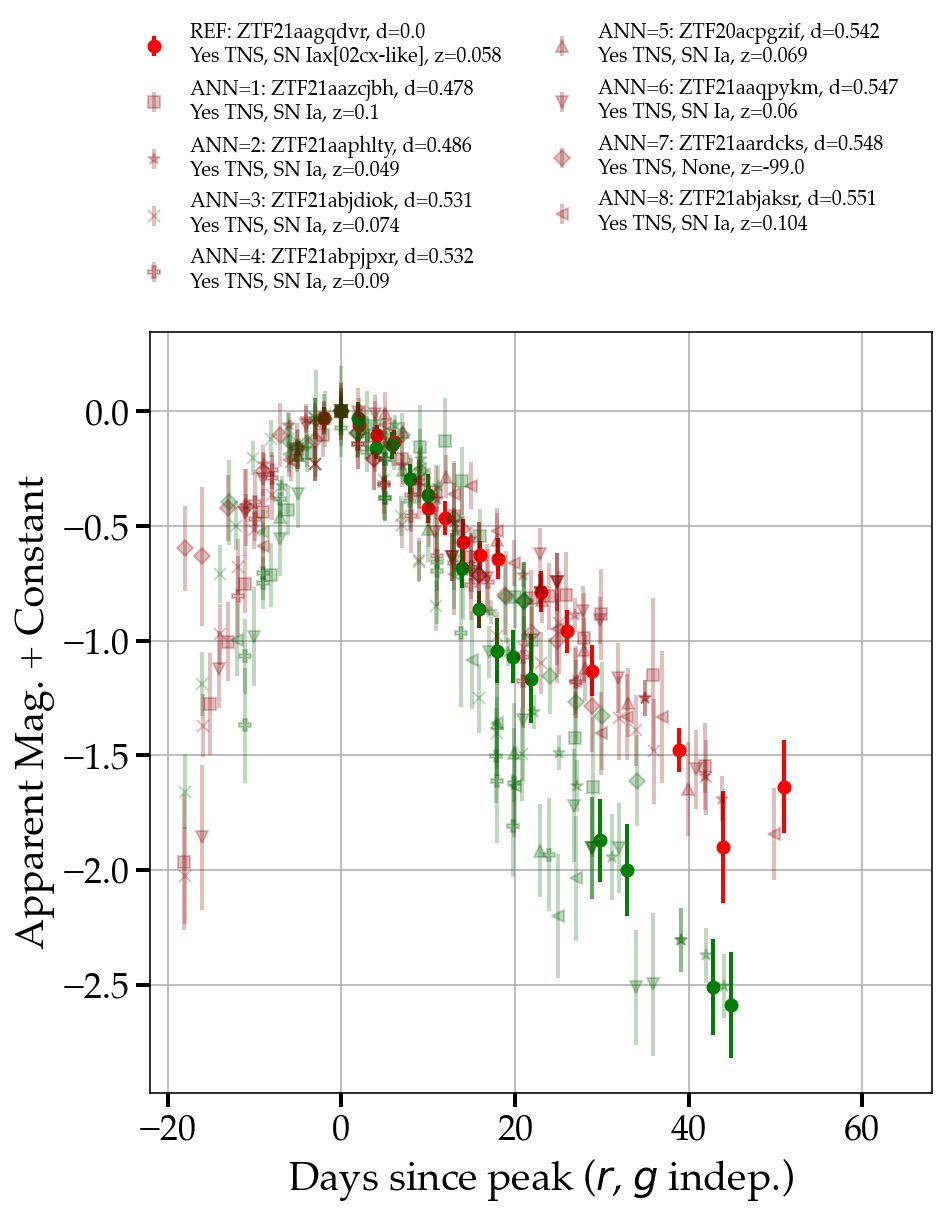

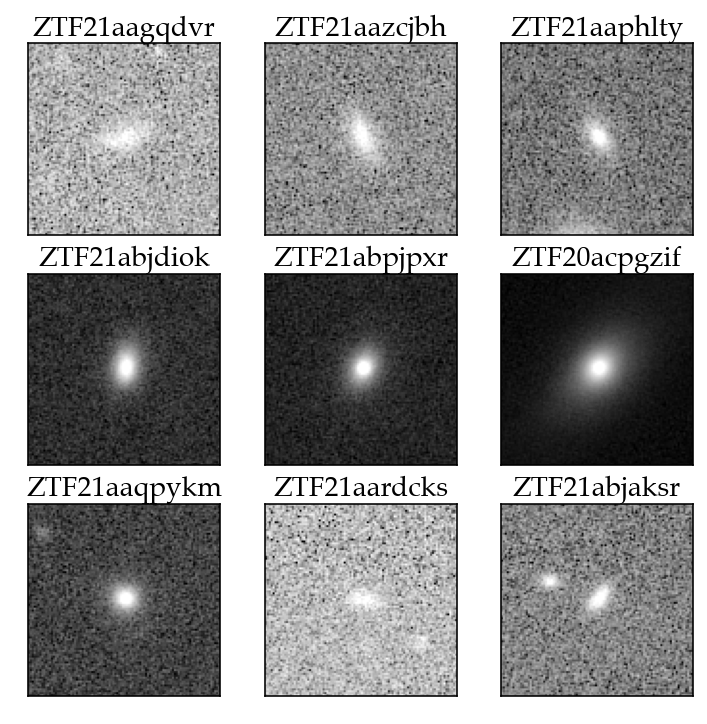

CPU times: user 4.62 s, sys: 180 ms, total: 4.8 s
Wall time: 12.2 s


In [388]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)

fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[mjd_idx_at_min_mag_g_ref], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z
    
    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]
    
    mjd_idx_at_min_mag_r = df_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g = df_g[['ant_mag']].reset_index().idxmin().ant_mag

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[mjd_idx_at_min_mag_r], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[mjd_idx_at_min_mag_g], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    #plt.xlabel('Days of event') # make iloc[0]
    plt.xlabel('Days since peak ($r$, $g$ indep.)') # (need r, g to be same)
    if df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref] <= 10:
        plt.xlim((df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref])-20, 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    else: 
        plt.xlim(2*(df_ref_r.ant_mjd.iloc[0]-df_ref_r.ant_mjd.iloc[mjd_idx_at_min_mag_r_ref]), 
                 df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}.jpg', dpi=150, bbox_inches='tight')

host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df)

In [170]:
# Common Values
# Value	Count	Frequency (%)
# None	14328	93.7%
# SN Ia	651	 4.3%
# SN II	141	 0.9%
# SN IIn	26	 0.2%
# SN Ia-91T-like	24	 0.2%
# SN Ib	15	 0.1%
# SN Ic	15	 0.1%
# SN IIb	11	 0.1%
# TDE	9	 0.1%
# SN IIP	9	 0.1%
# Other values (18)	65	 0.4%

# TODO: Find ANNs per TNS class dist - do more rare classes scale with higher dist?

In [171]:
dataset_bank

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF20acpdyyq   0.511818  0.456445  0.298547 -0.435800  0.104584  0.000950   
ZTF18acfvwwa   0.615020  0.562739 -0.037277  0.140403 -0.206723 -0.194529   
ZTF20aciscxz  -0.256754 -0.742976 -0.048415 -0.209558 -0.183202 -0.270691   
ZTF18abdkosj  -0.068852  1.273278 -0.212095 -0.124671  0.803083  0.191667   
ZTF18abrcoty  -0.433417 -0.736429 -0.359087 -0.056552  0.680630  0.456326   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.160439  0.696893 -0.630179  0.262558  0.095095 -0.335650   
ZTF19aaweyrl   0.736704  0.112940  0.377076  0.388480 -0.812026 -0.297347   
ZTF18aaxheyx  -1.002336  0.825724 -0.444662  0.004182 -0.254138 -0.051961   
ZTF18aasbhzf   0.096749  0.577655 -0.802851  0.411372  0.172698 -0.133084   
ZTF21aamjuma   0.675743  0.361102 -0.080897  0.069052 -0.342685  0.180416   

                    PC6       PC7       PC8       PC9  ...      PC15  \
ztf_object_id                                          ...             
ZTF20acpdyyq  -0.643040 -0.090833 -0.019208 -0.315451  ... -0.179917   
ZTF18acfvwwa  -0.382700 -0.137562 -0.102732 -0.273071  ...  0.290624   
ZTF20aciscxz   0.139766 -0.293575  0.042029  0.349648  ...  0.097367   
ZTF18abdkosj   0.396562  0.623895 -0.120961  0.347897  ...  0.115358   
ZTF18abrcoty   0.140246 -0.238546  0.551835 -0.095624  ... -0.222141   
...                 ...       ...       ...       ...  ...       ...   
ZTF18aczcgiz   0.214556  0.005747 -0.227684 -0.230381  ...  0.322826   
ZTF19aaweyrl   0.072658  0.184864  0.453970  0.274484  ... -0.018119   
ZTF18aaxheyx  -0.145301  0.100680  0.132978  0.149326  ... -0.225338   
ZTF18aasbhzf   0.339222  0.013833  0.003424 -0.270776  ... -0.089297   
ZTF21aamjuma  -0.167925 -0.206438 -0.150494 -0.196623  ... -0.016987   

                   PC16      PC17      PC18      PC19      PC20      PC21  \
ztf_object_id                                                               
ZTF20acpdyyq   0.022588  0.069948 -0.052578  0.160625 -0.055289 -0.041381   
ZTF18acfvwwa   0.058064  0.067783 -0.070382  0.121101 -0.008766 -0.023159   
ZTF20aciscxz   0.029304  0.047807 -0.030586  0.239148 -0.230177 -0.047767   
ZTF18abdkosj  -0.332221 -0.013136 -0.002603  0.214479 -0.089750 -0.066152   
ZTF18abrcoty  -0.180300 -0.254901  0.016235  0.159101 -0.263079 -0.021724   
...                 ...       ...       ...       ...       ...       ...   
ZTF18aczcgiz   0.151022 -0.102228 -0.048979 -0.056902 -0.309472  0.044994   
ZTF19aaweyrl   0.007953  0.112535  0.121005  0.031494 -0.018019  0.001590   
ZTF18aaxheyx  -0.062437  0.289056 -0.091479 -0.143870  0.075409  0.133320   
ZTF18aasbhzf   0.194967  0.074162 -0.042808  0.319502  0.062797 -0.038408   
ZTF21aamjuma   0.062053  0.200256 -0.092879  0.035319 -0.009887 -0.154340   

                   PC22      PC23      PC24  
ztf_object_id                                
ZTF20acpdyyq  -0.116868  0.102099 -0.004076  
ZTF18acfvwwa   0.056583  0.236332  0.006777  
ZTF20aciscxz   0.156714 -0.054044 -0.042889  
ZTF18abdkosj   0.055596  0.104365 -0.098498  
ZTF18abrcoty   0.059867  0.336701  0.120730  
...                 ...       ...       ...  
ZTF18aczcgiz   0.053421 -0.089338  0.036497  
ZTF19aaweyrl   0.083623  0.064536  0.330461  
ZTF18aaxheyx  -0.087950  0.173210 -0.065561  
ZTF18aasbhzf   0.026983 -0.153674 -0.043557  
ZTF21aamjuma  -0.122047 -0.073658 -0.074834  

[18998 rows x 25 columns]

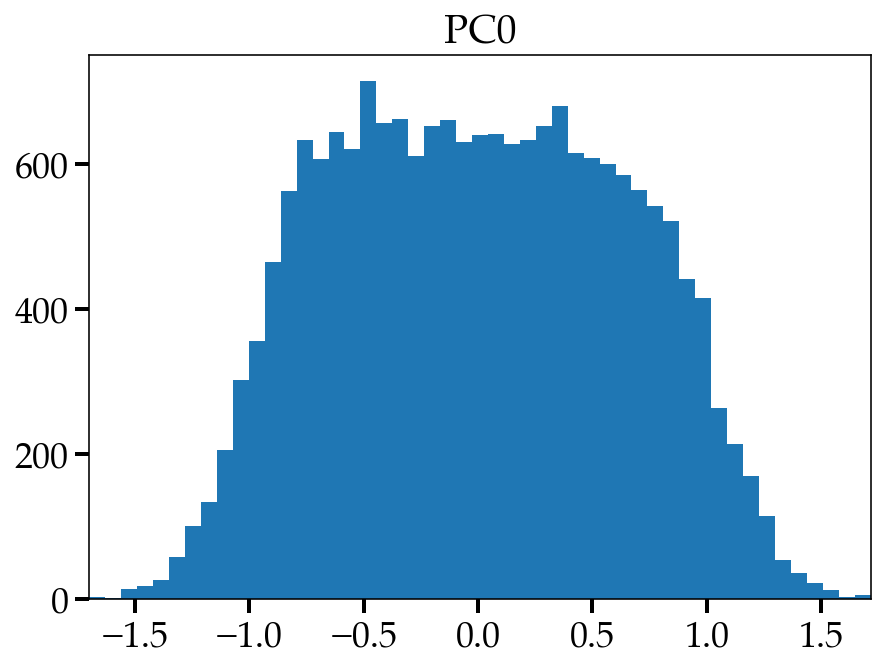

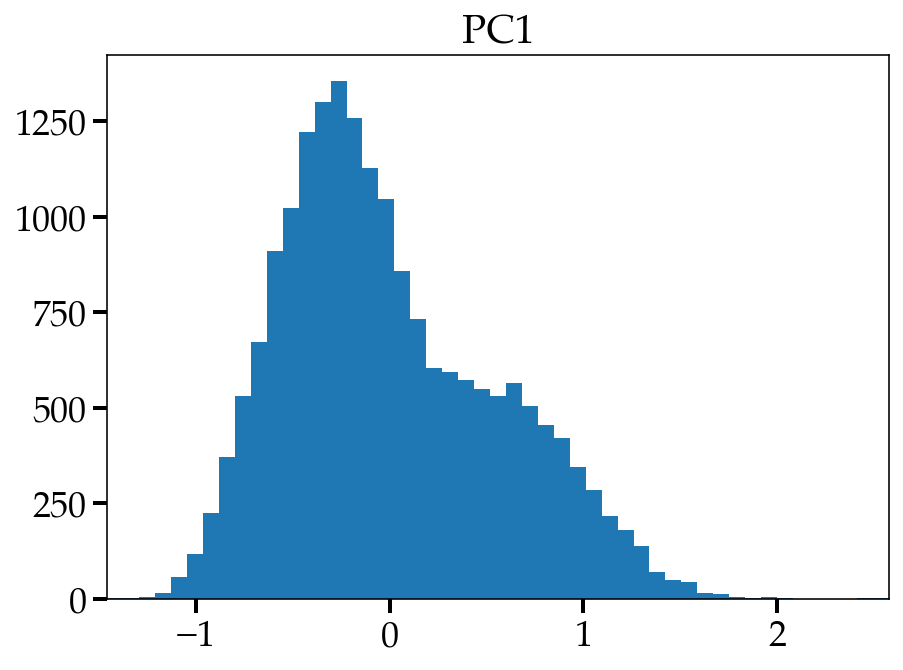

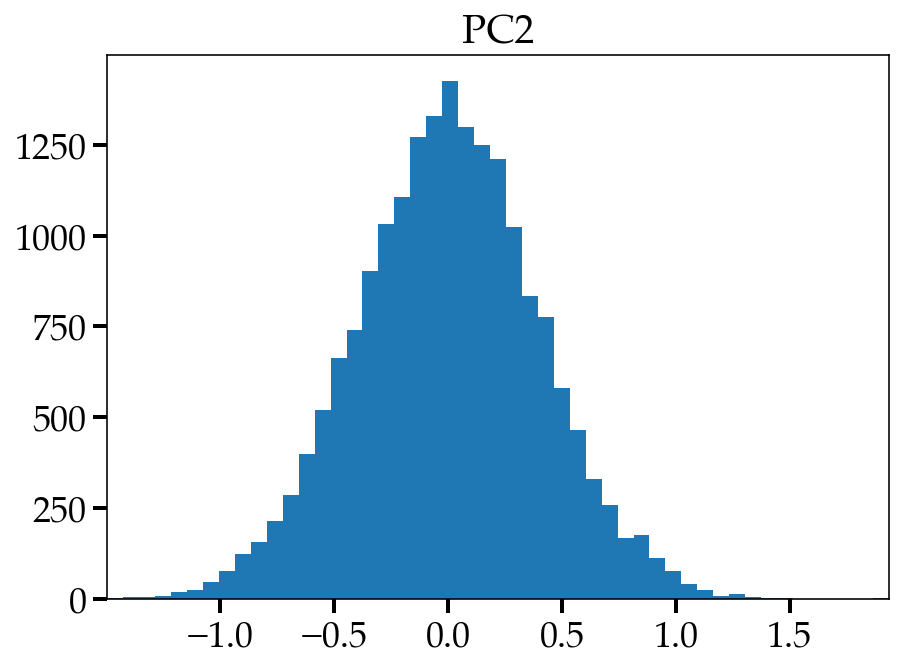

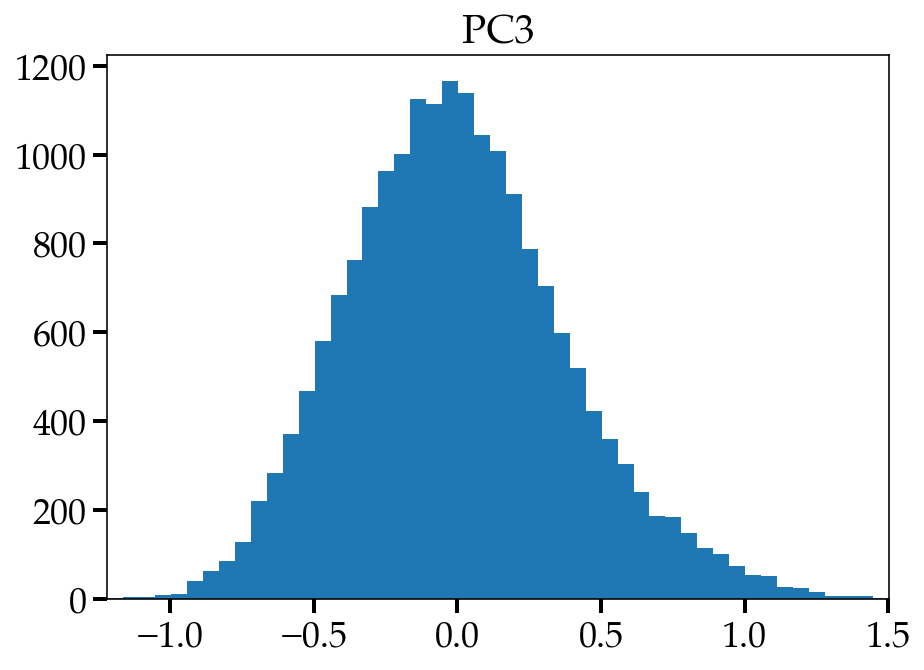

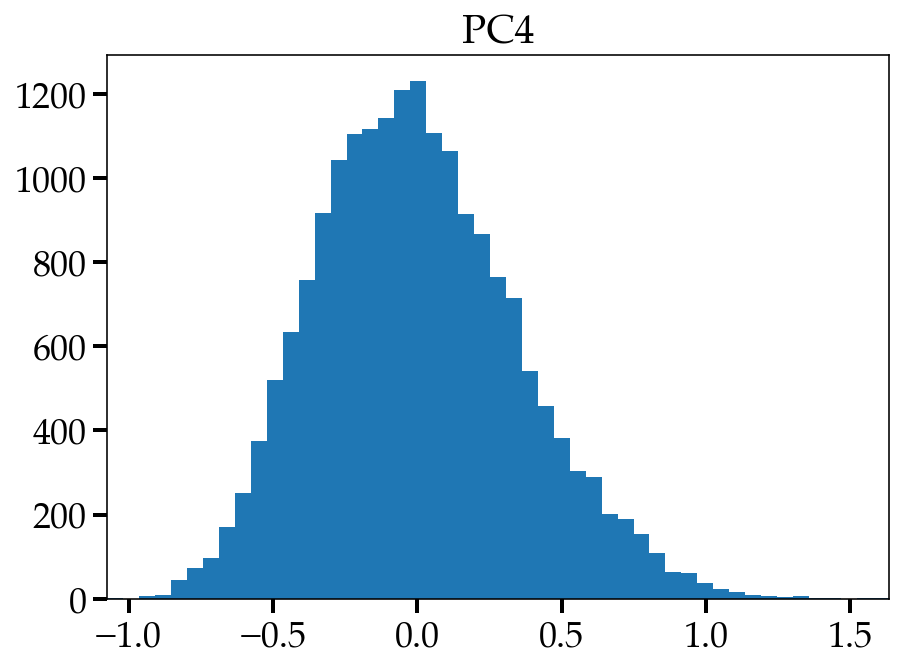

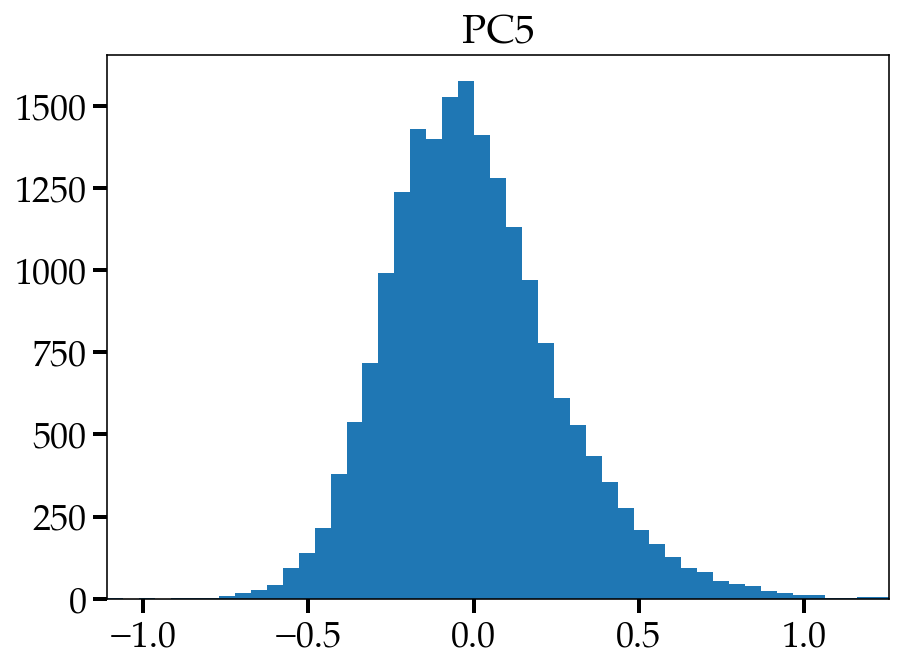

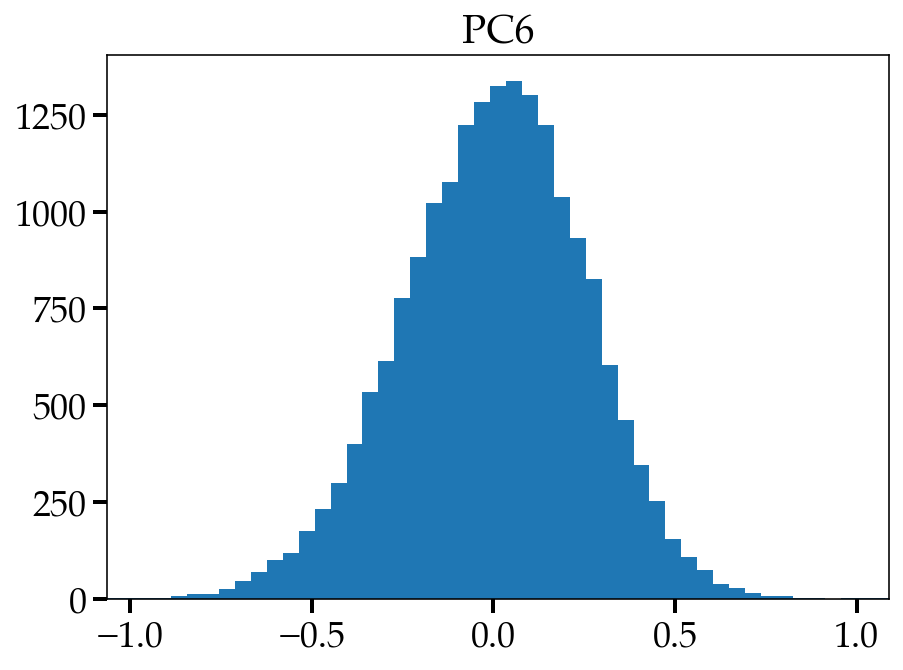

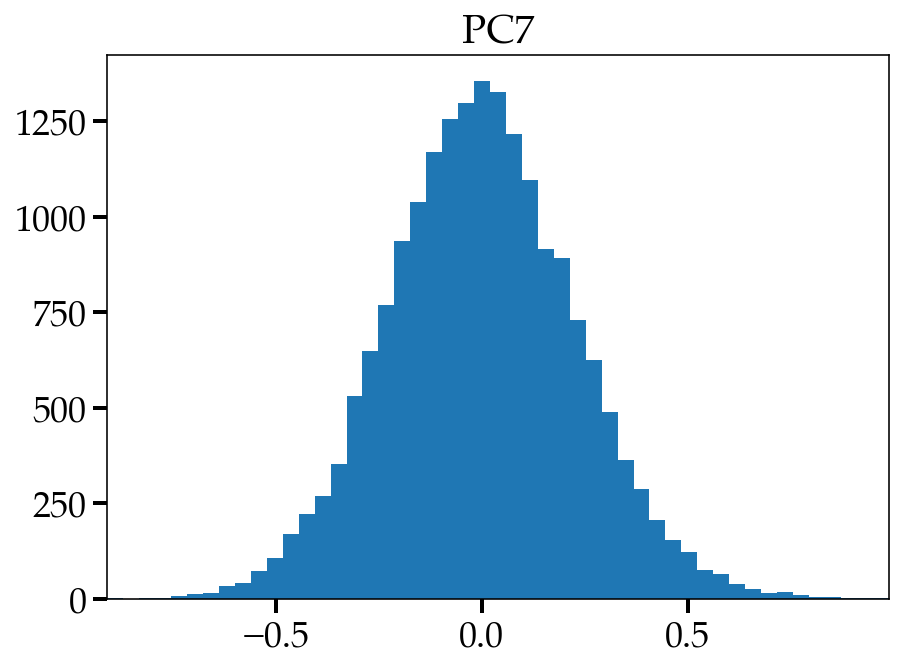

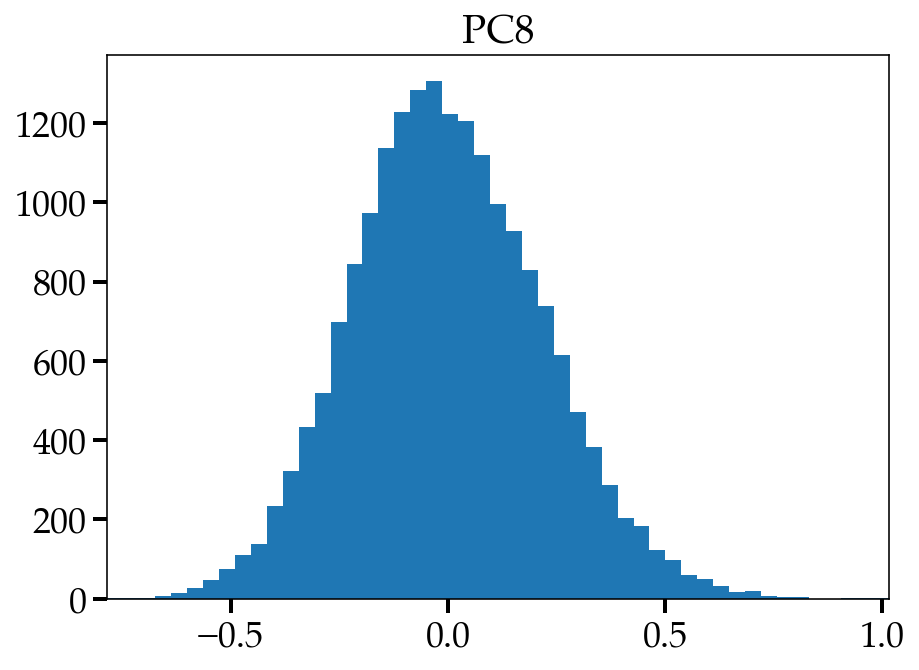

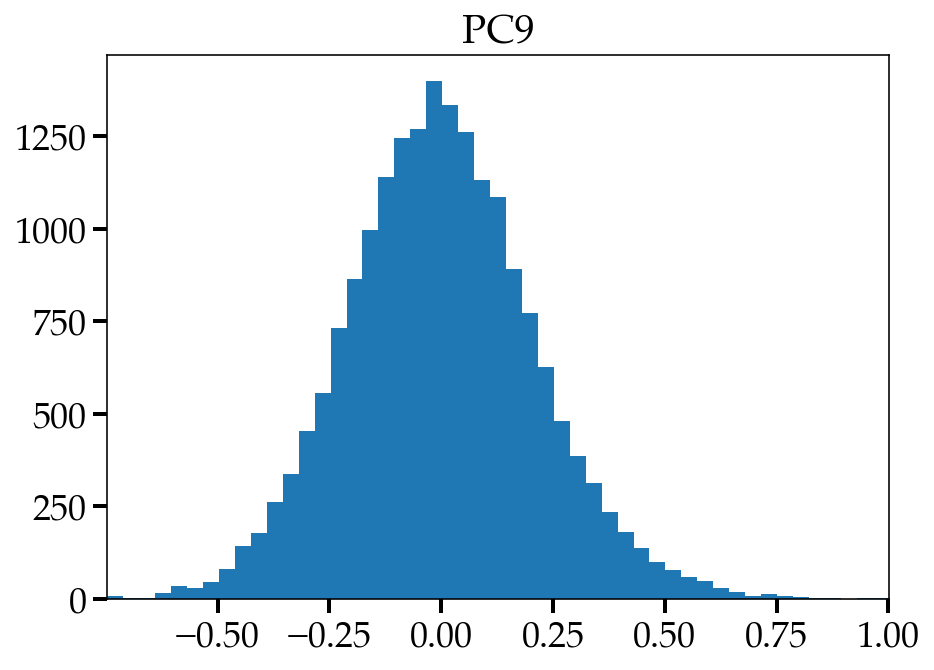

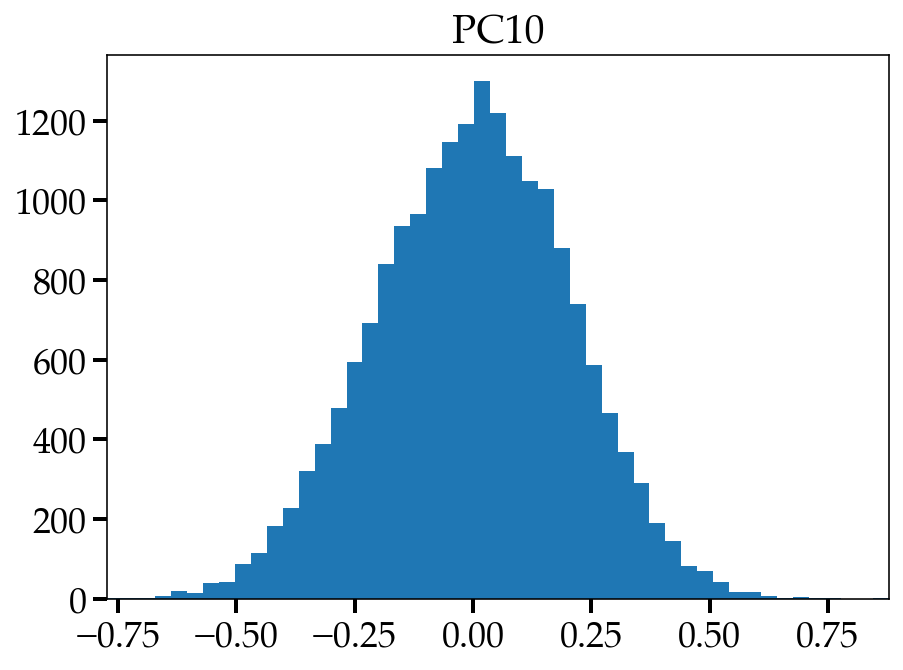

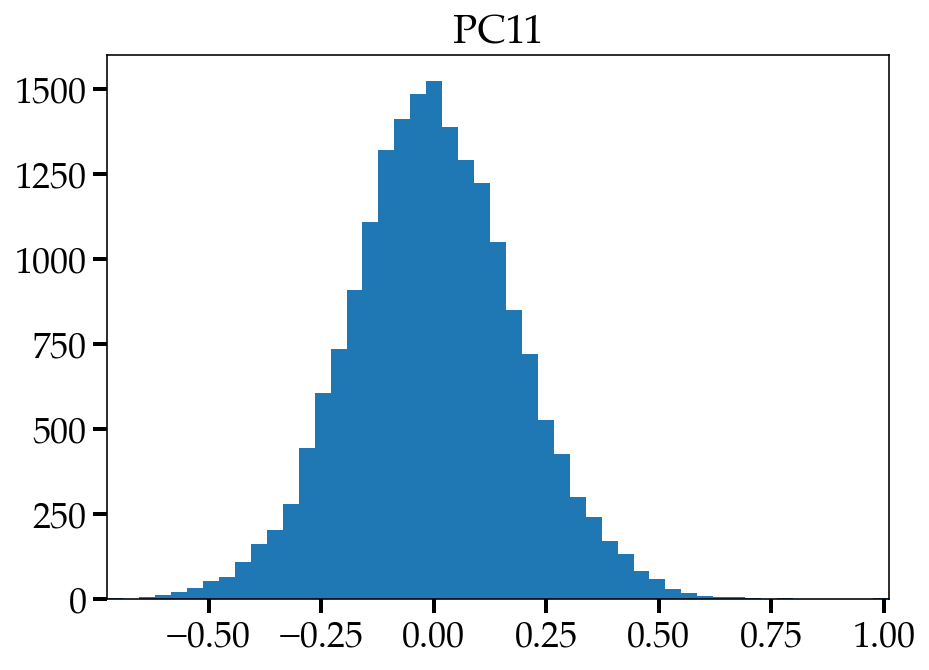

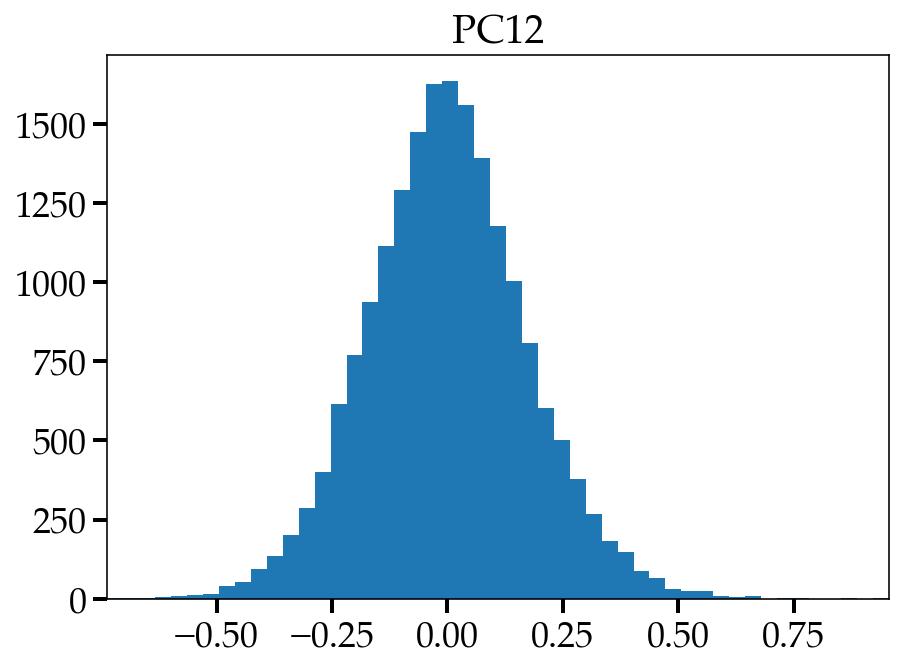

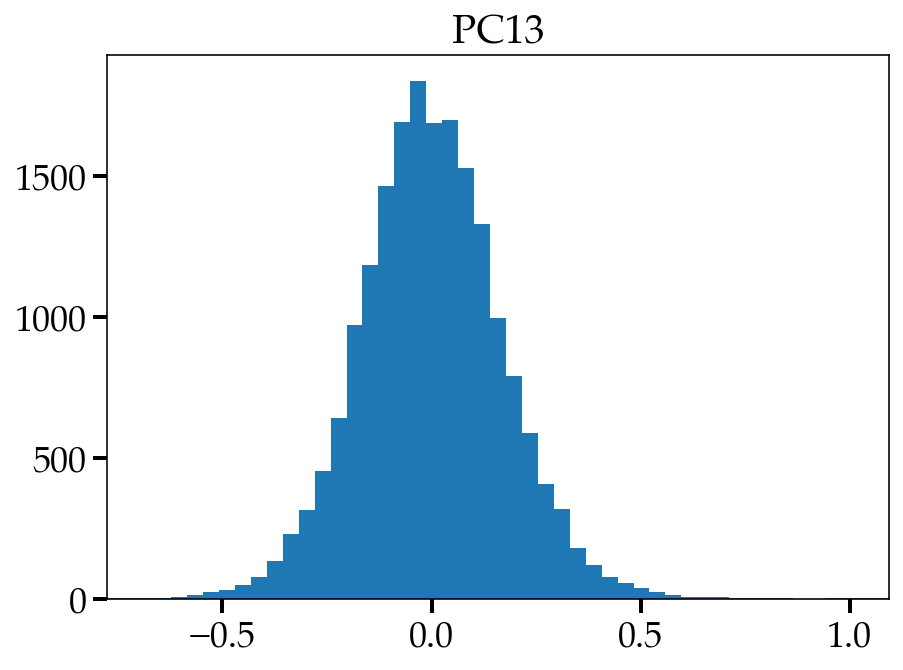

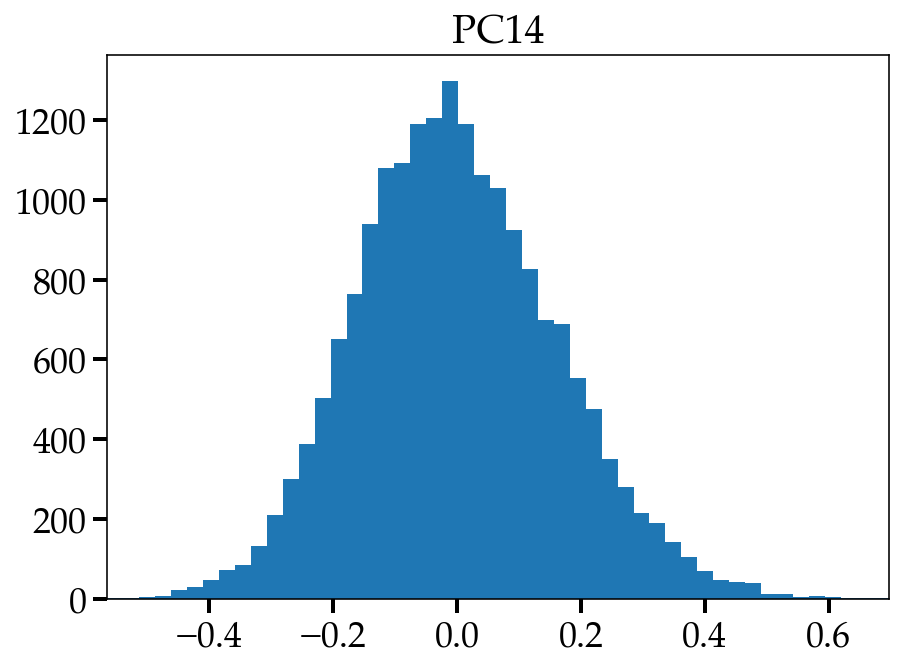

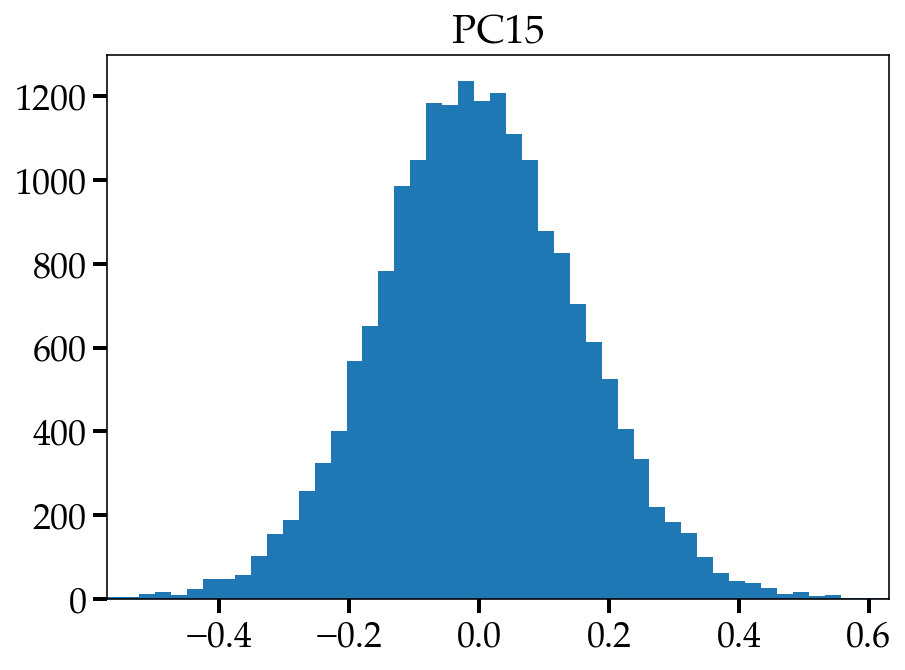

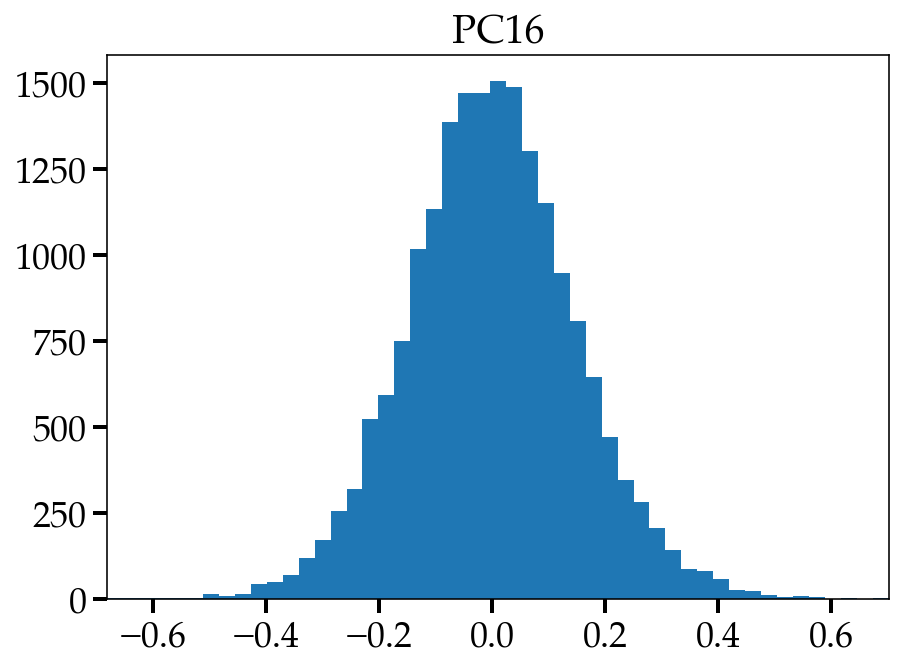

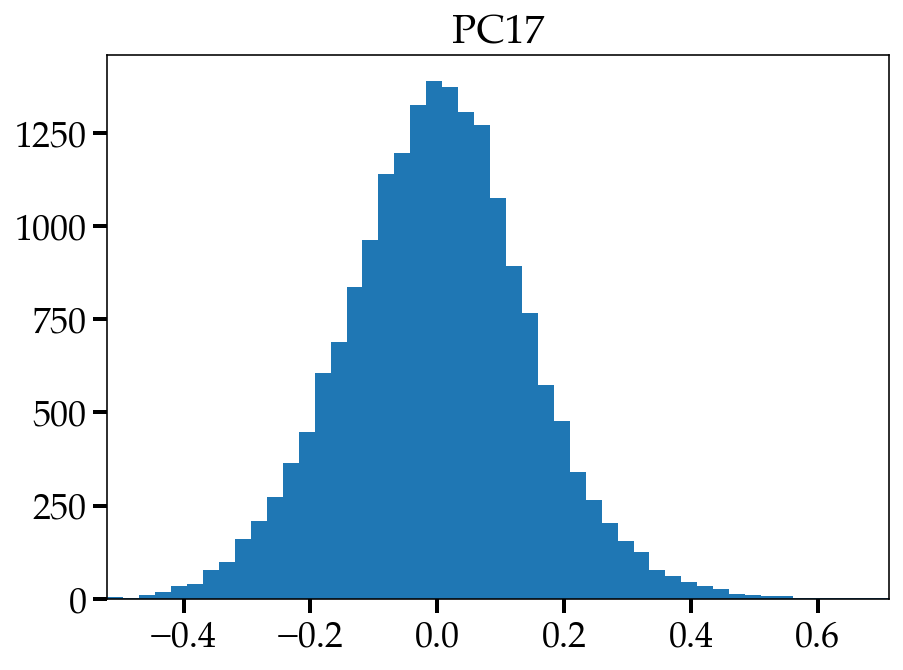

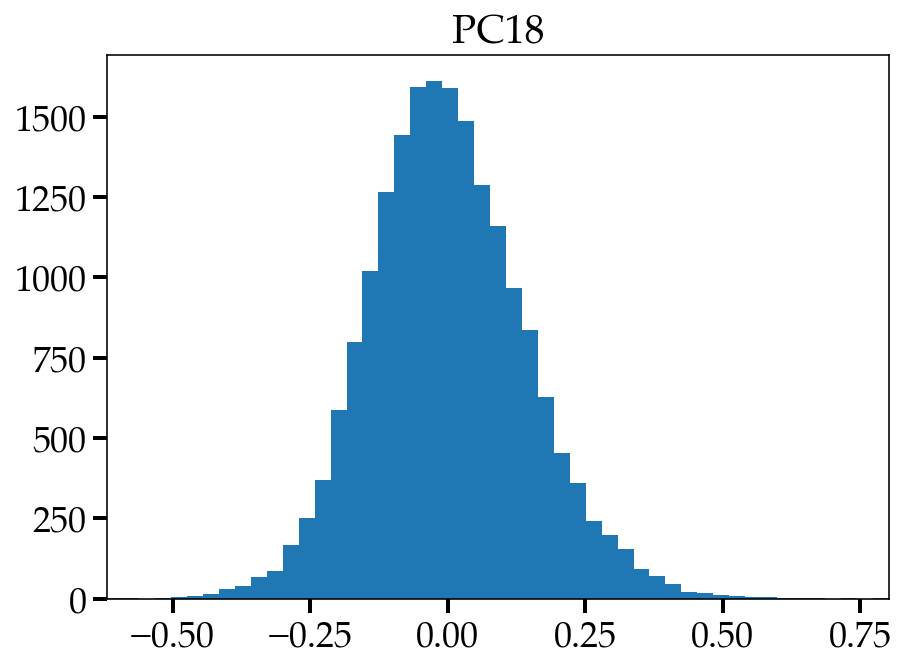

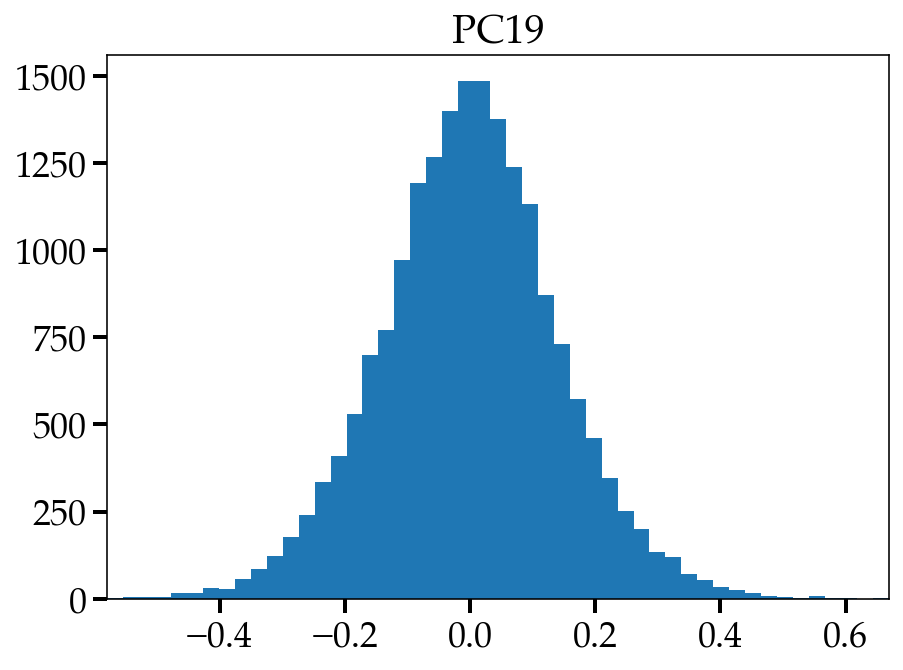

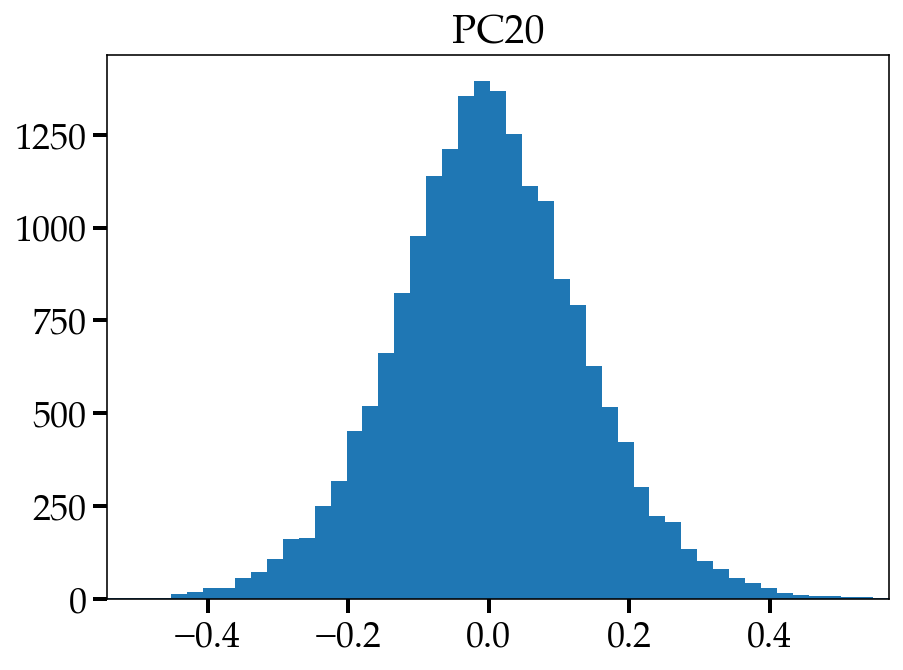

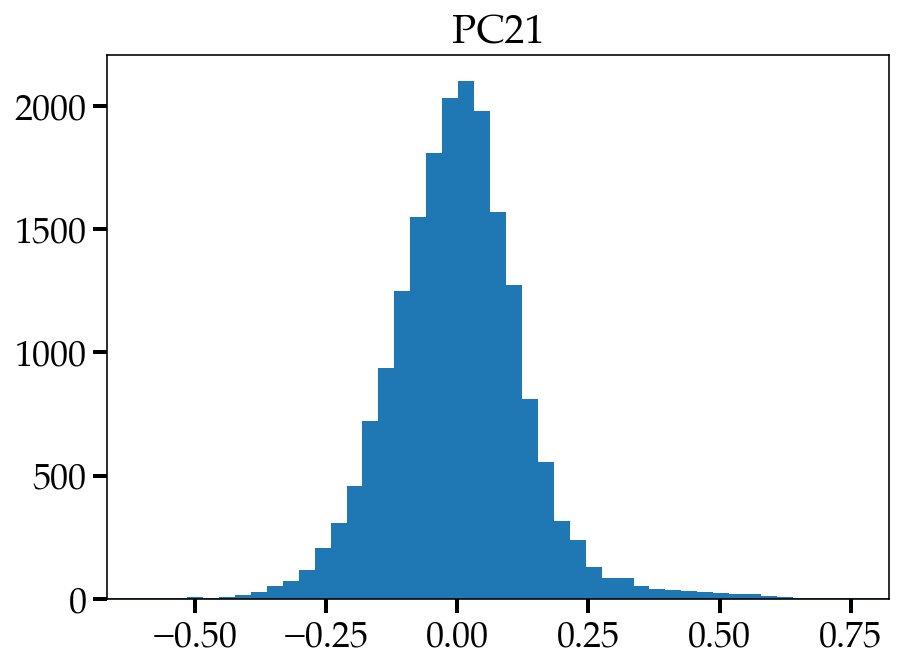

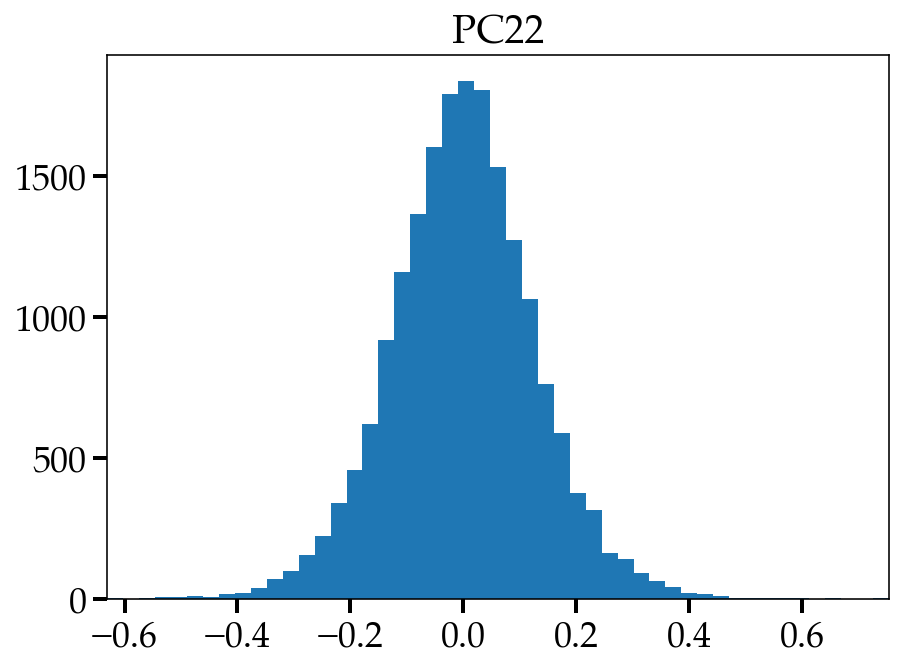

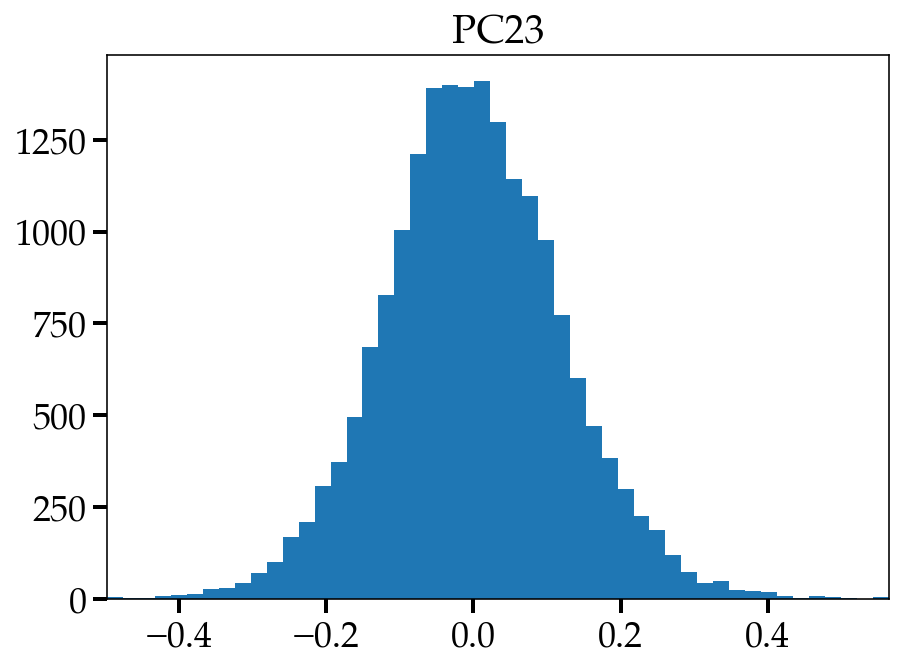

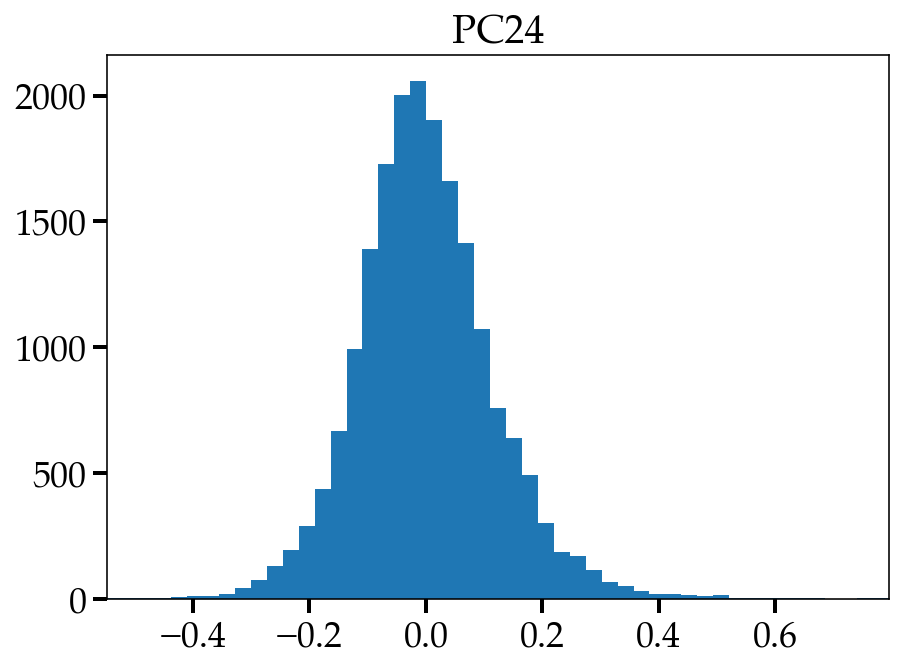

In [172]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)    

In [173]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.23011482560256277
Scatter median: 0.1729901697804505
Scatter std: 0.13275527741896265
Scatter max: 0.633461388280752
Scatter min: 0.11674985070144736


In [174]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index)):
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, 10)]
# sum specific columns
ann_dist_all_df[f'Mean-{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))

# weighted distance of first 9 ANNs
weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
ann_dist_all_df[f'WeightedMean-{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df

CPU times: user 40.9 s, sys: 182 ms, total: 41.1 s
Wall time: 41.3 s


ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
key_0                                                                         
ZTF17aaaaenu  18790   6649  14428  13209   8815   9274   3639  18882  11811   
ZTF17aaaazhi  16293  11694   5764   6680  11784   7680   1242   1227    241   
ZTF17aaaazmz   9278  18392   4196  10854   3557  14164   5253  13787  10115   
ZTF17aaabghb   7729   8345  10679   2012  11735   2262  13702  11841  18175   
ZTF17aaabuab  13760  12701  16799  16398   2745   1950   2455   3872   5941   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21acogvaq   8545   4406   3097   2777  10814   5763  16150  17304  13656   
ZTF21acowflo   7527   7924   9290   4445   9522  10720  10343   9505  11086   
ZTF21acqdfea   7777   1489   8136   9363   2915   8363   5053   1731   1148   
ZTF21acqnurt   8040   5704   3780   4052   8575  11187   9349   2586  11183   
ZTF21acqtdnd  14318   7559   5555   5262  13649   3350   8138   8468  12555   

              ann=9  ...    dist=2    dist=3    dist=4    dist=5    dist=6  \
key_0                ...                                                     
ZTF17aaaaenu  10853  ...  0.621359  0.662255  0.671815  0.704712  0.742511   
ZTF17aaaazhi   9193  ...  0.731143  0.797333  0.799613  0.821951  0.841621   
ZTF17aaaazmz  13747  ...  0.653540  0.680907  0.736289  0.752320  0.769616   
ZTF17aaabghb  16756  ...  0.559669  0.578989  0.579965  0.648935  0.651527   
ZTF17aaabuab  13726  ...  0.716577  0.718821  0.735090  0.774993  0.780780   
...             ...  ...       ...       ...       ...       ...       ...   
ZTF21acogvaq  11409  ...  0.641003  0.703482  0.724333  0.728081  0.760236   
ZTF21acowflo  18775  ...  0.715405  0.757582  0.759642  0.770670  0.771659   
ZTF21acqdfea  17114  ...  0.582402  0.594392  0.610871  0.623199  0.625753   
ZTF21acqnurt  18577  ...  0.860435  0.871391  0.880221  0.928690  0.951696   
ZTF21acqtdnd  16045  ...  0.937540  0.946313  0.947807  1.001709  1.003344   

                dist=7    dist=8    dist=9  Mean-9ANNs  WeightedMean-9ANNs  
key_0                                                                       
ZTF17aaaaenu  0.746813  0.748877  0.755348    0.690890            0.624640  
ZTF17aaaazhi  0.858785  0.859848  0.885726    0.810450            0.749399  
ZTF17aaaazmz  0.781522  0.811449  0.815898    0.731266            0.652753  
ZTF17aaabghb  0.674423  0.674603  0.676841    0.618966            0.564710  
ZTF17aaabuab  0.790355  0.790408  0.803593    0.757617            0.724266  
...                ...       ...       ...         ...                 ...  
ZTF21acogvaq  0.760792  0.762532  0.773601    0.714427            0.647232  
ZTF21acowflo  0.777427  0.802097  0.846605    0.761127            0.708966  
ZTF21acqdfea  0.635121  0.643767  0.648494    0.614630            0.587512  
ZTF21acqnurt  0.960042  0.969216  0.984275    0.912838            0.856098  
ZTF21acqtdnd  1.012045  1.013979  1.016001    0.960844            0.883940  

[18998 rows x 22 columns]

In [175]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
dist_col = f'WeightedMean-{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1'

print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.6649570311006273
Scatter median: 0.6595560904930938
Scatter std: 0.12811864052013286
Scatter max: 1.614741097797047
Scatter min: 0.3376547074453397


Most anomalous: ZTF19aaeyltm


# Largest distance


### either bogus (bright "obs" at core which aren't real)
### intense variable star
### bright/ nearby SN
### big gaps
### quick rise and then no obs until much later
### some truly weird ones (20acct)

In [176]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

Max dist 1.614741097797047


In [177]:
dataset_bank[dataset_bank.index == ref_obj]

PC0       PC1       PC2       PC3       PC4       PC5  \
ztf_object_id                                                               
ZTF19aaeyltm  -0.525946  1.348017  0.833197 -0.339183  0.961582  0.440525   

                    PC6       PC7       PC8      PC9  ...      PC15      PC16  \
ztf_object_id                                         ...                       
ZTF19aaeyltm   0.443063 -0.101529  0.008874  0.32909  ...  0.085091  0.020904   

                   PC17      PC18      PC19      PC20     PC21      PC22  \
ztf_object_id                                                              
ZTF19aaeyltm   0.711741  0.069868  0.418913  0.001668  0.61605  0.426462   

                   PC23      PC24  
ztf_object_id                      
ZTF19aaeyltm  -0.088718 -0.152881  

[1 rows x 25 columns]

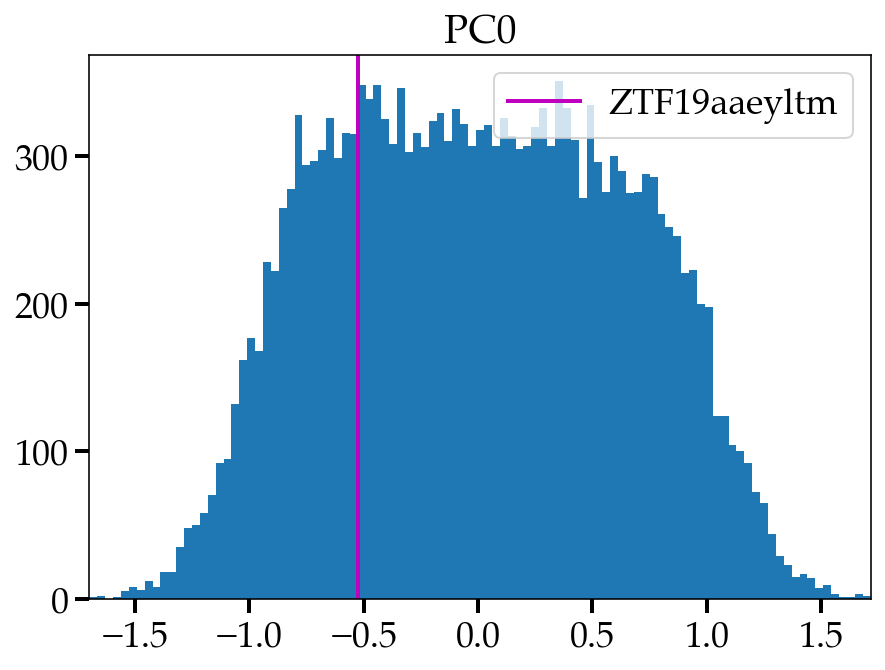

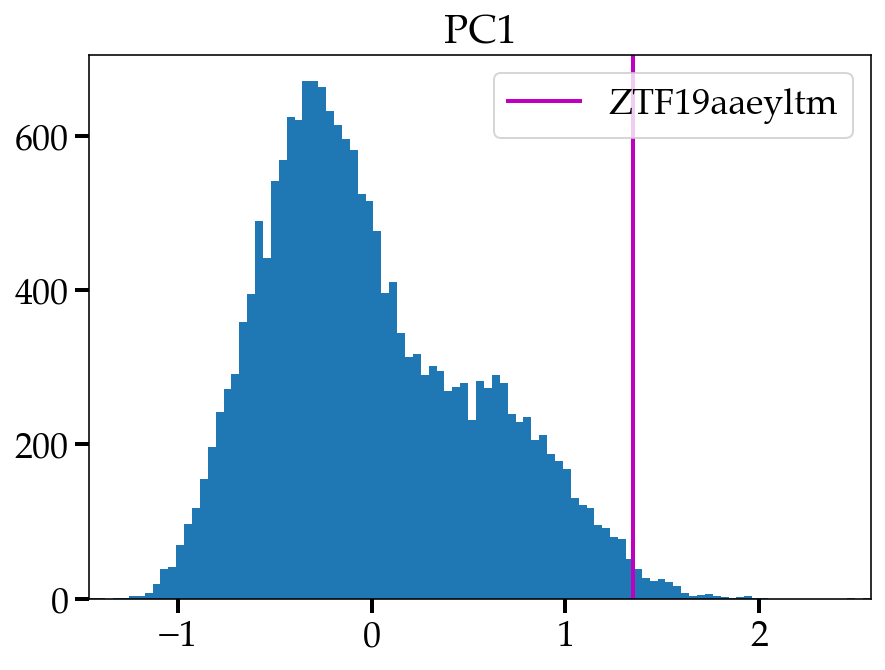

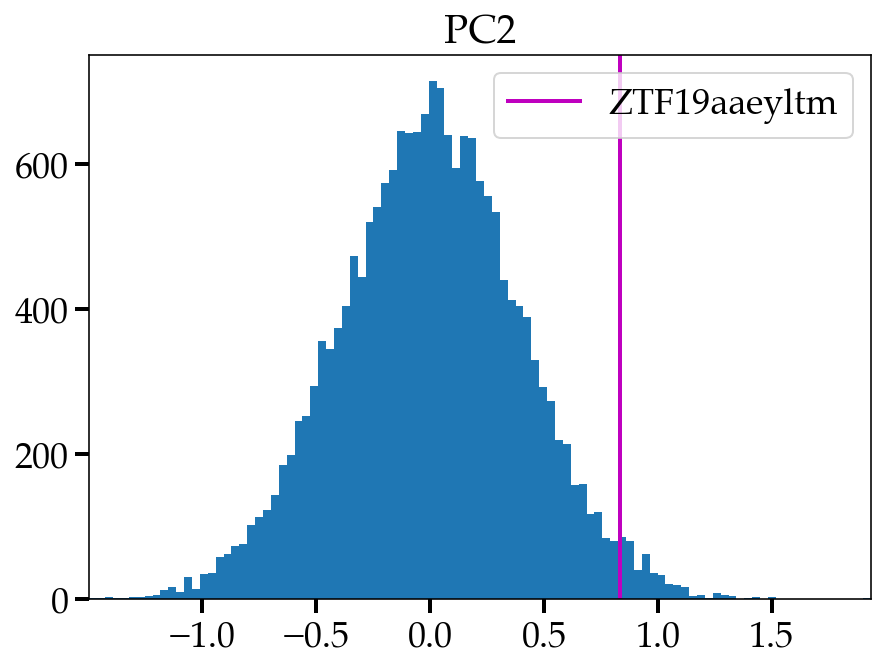

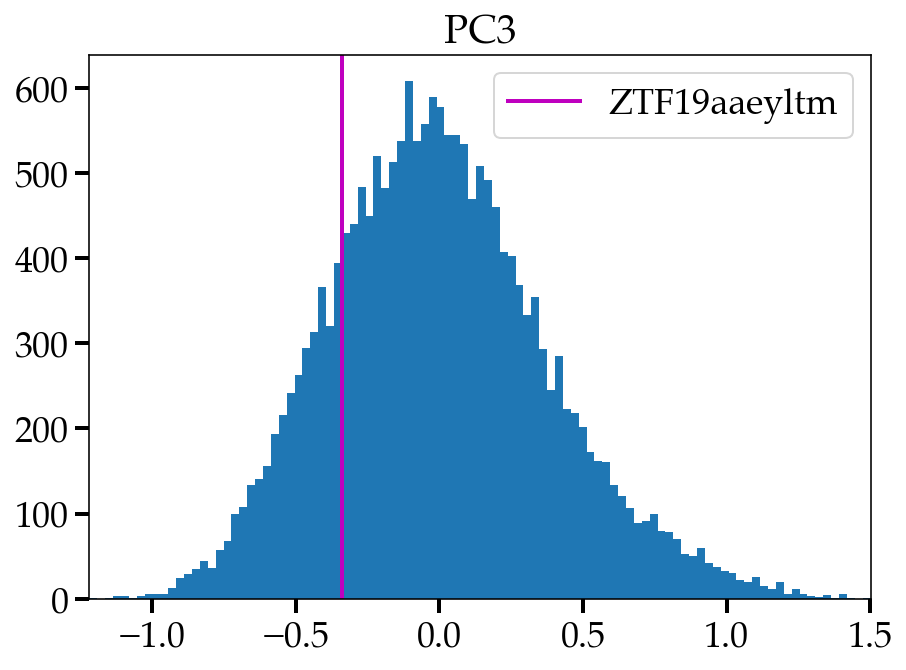

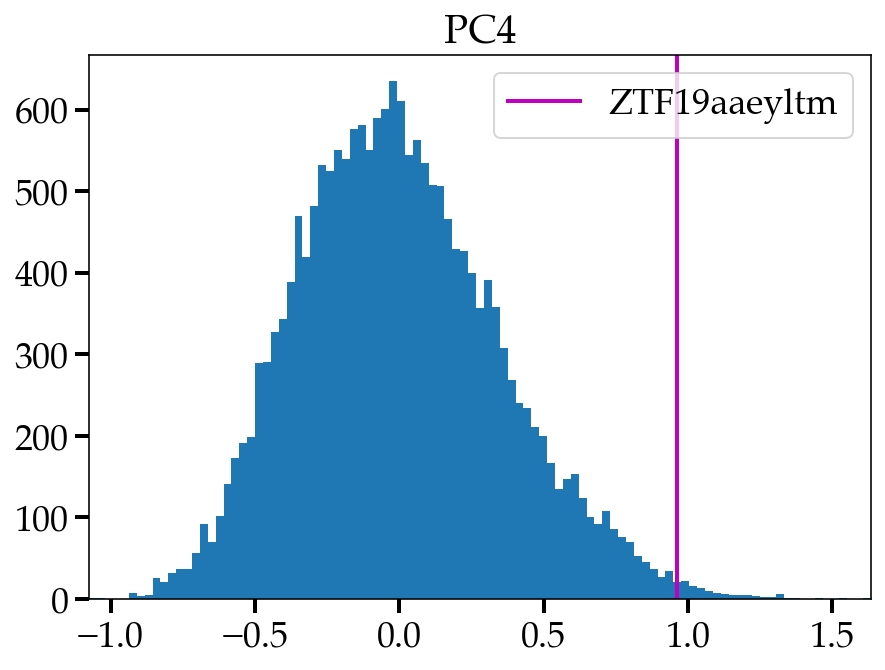

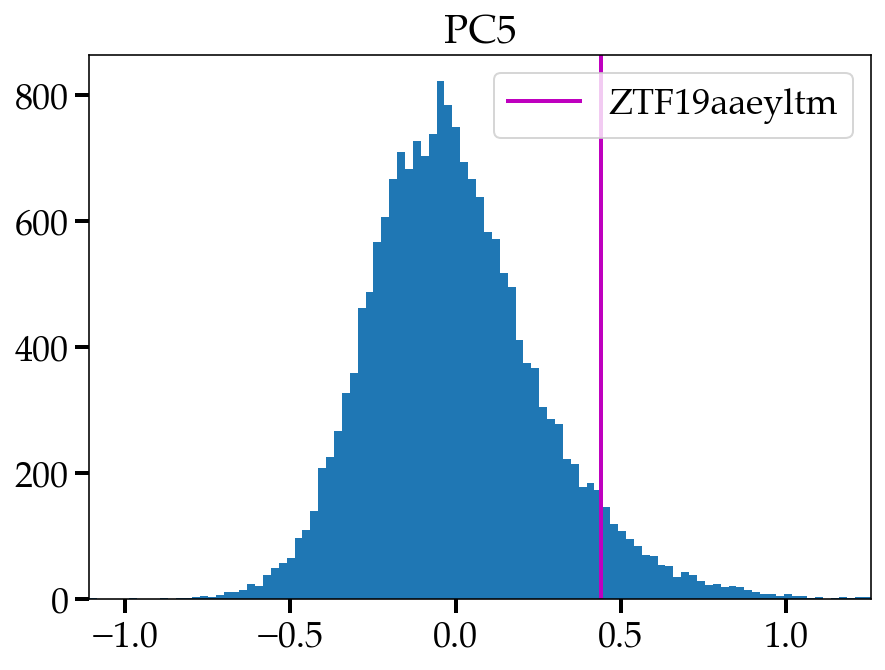

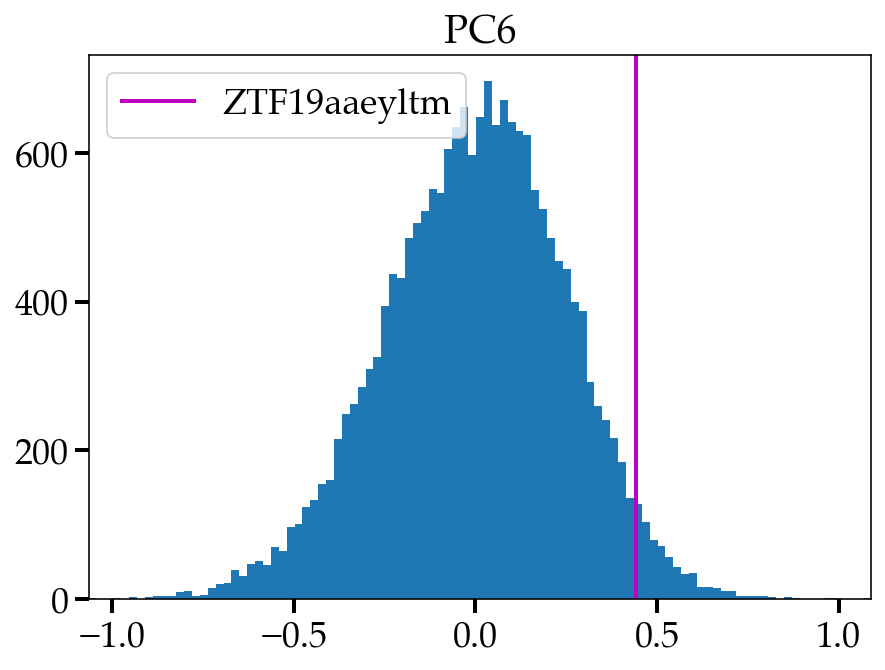

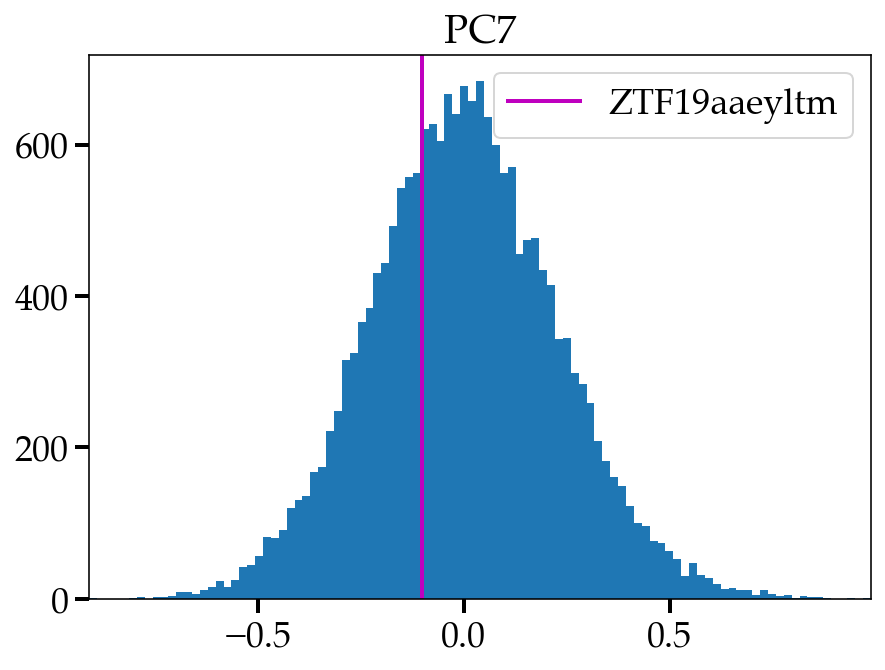

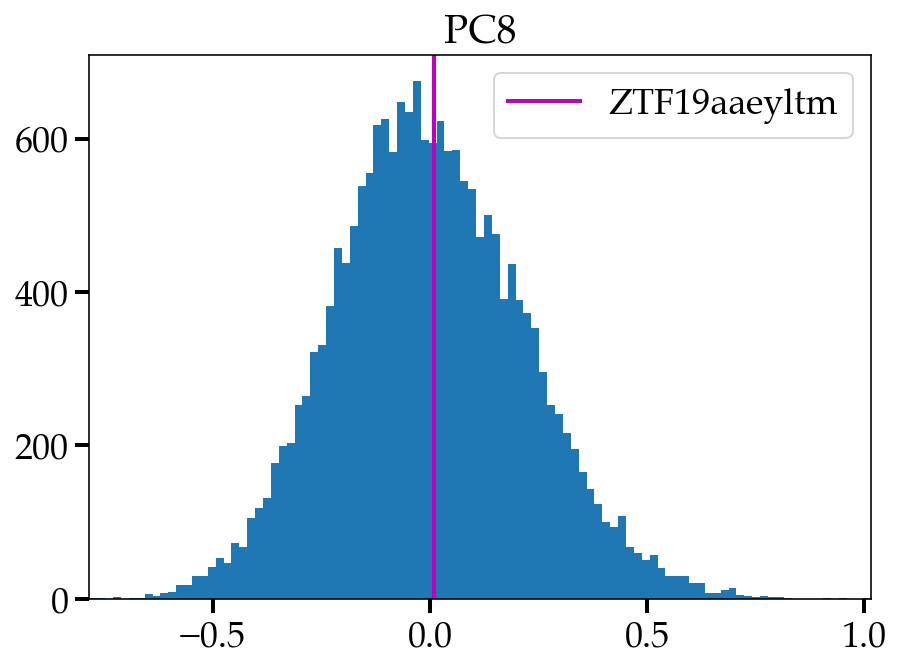

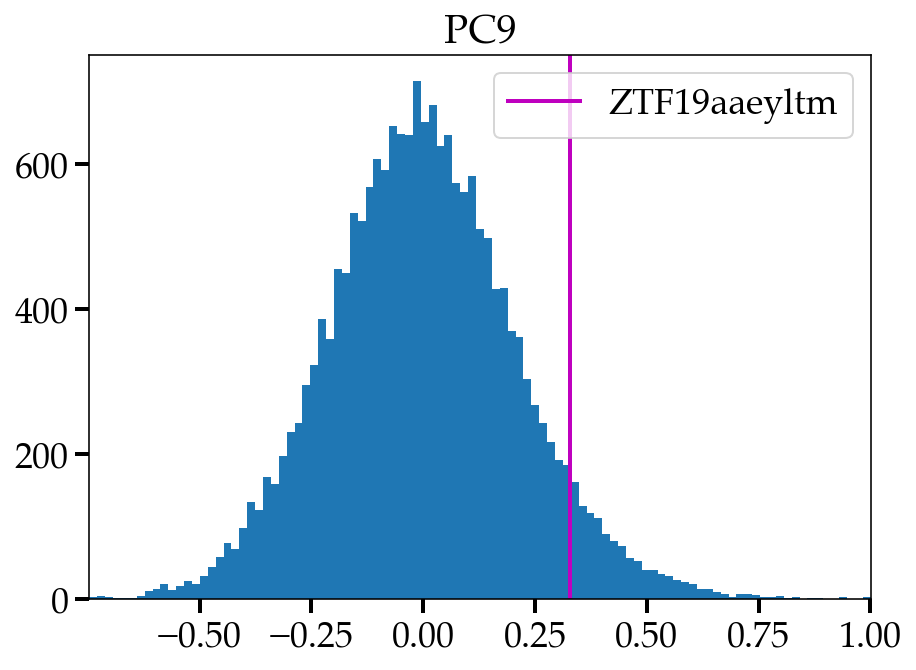

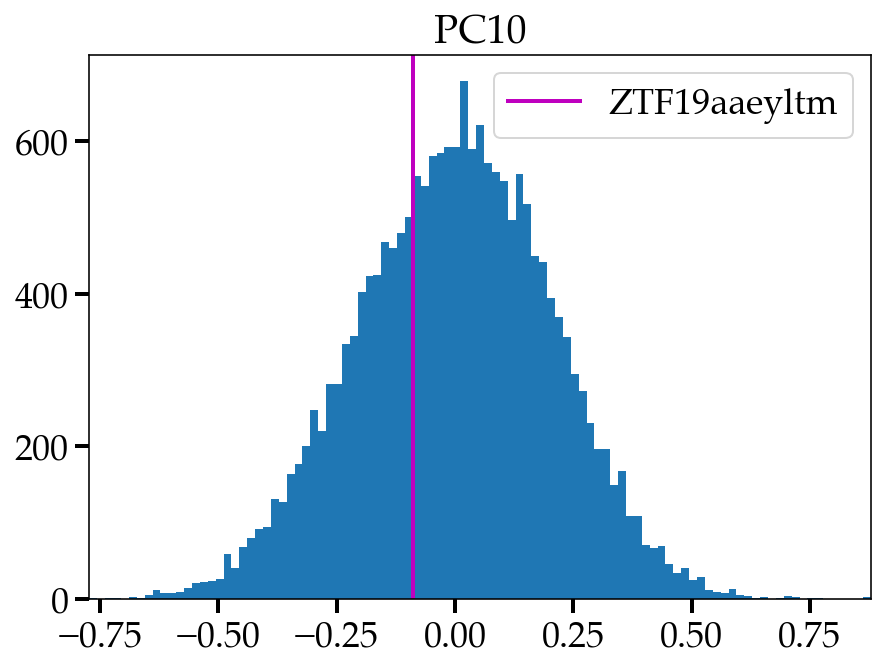

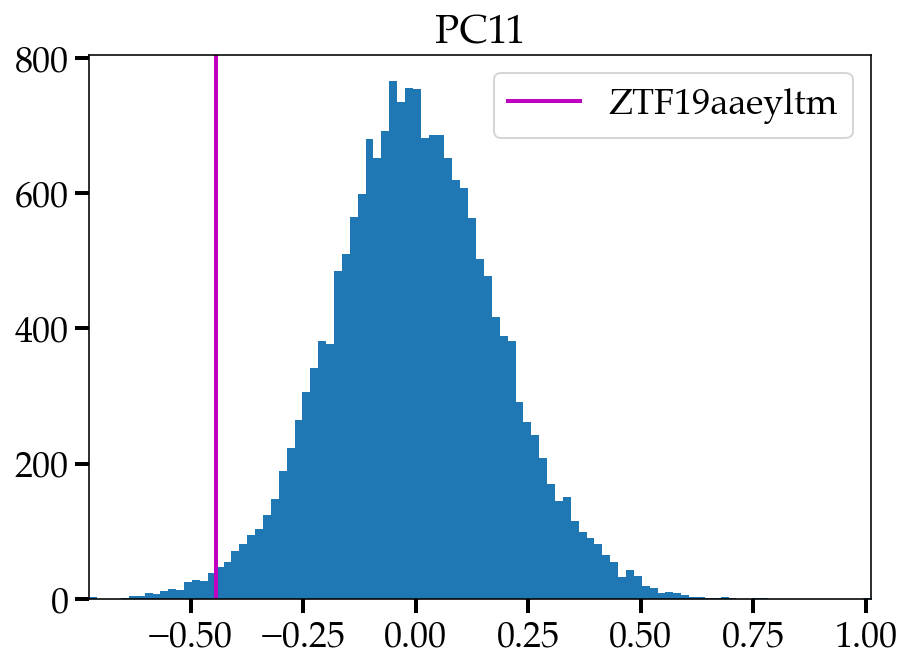

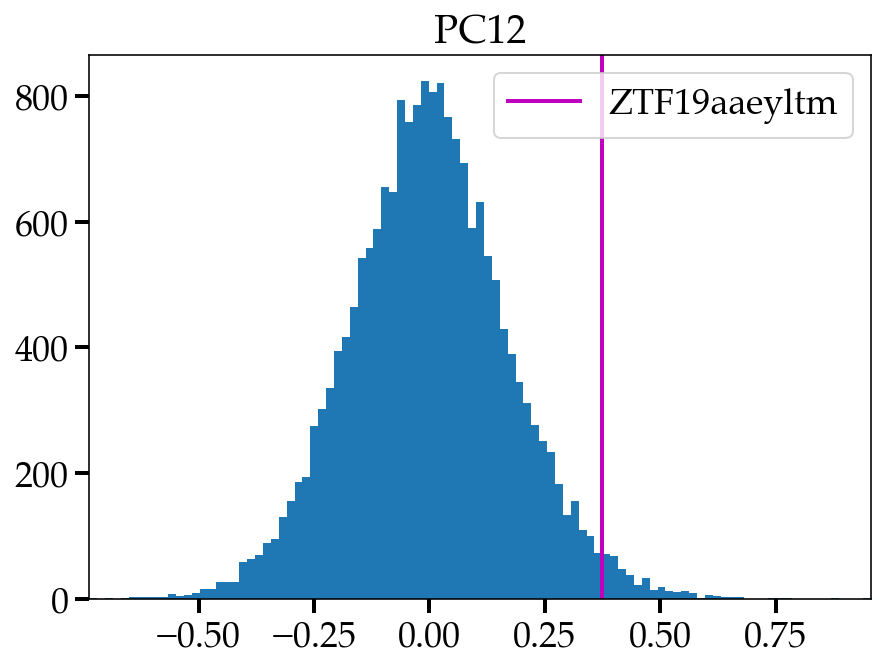

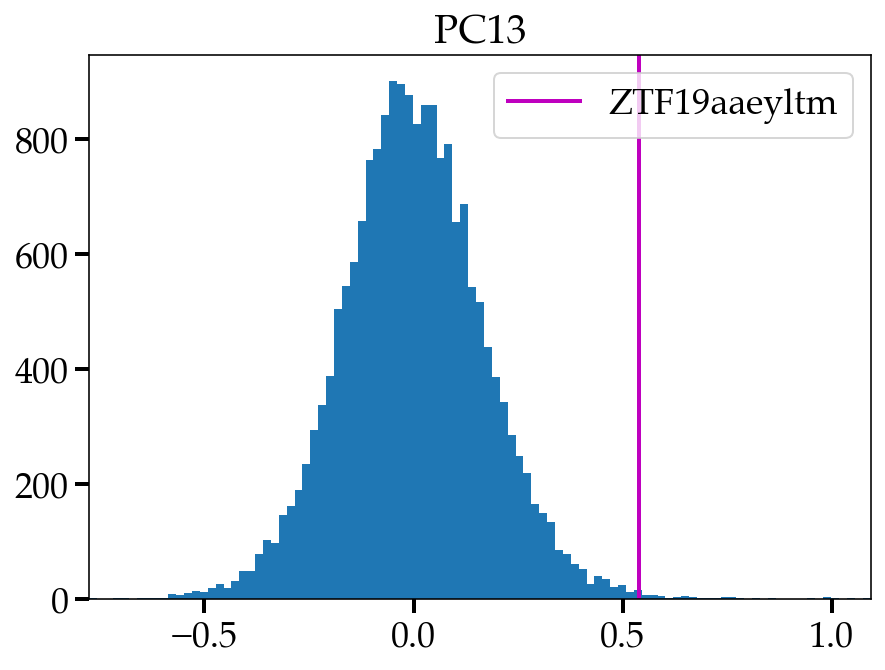

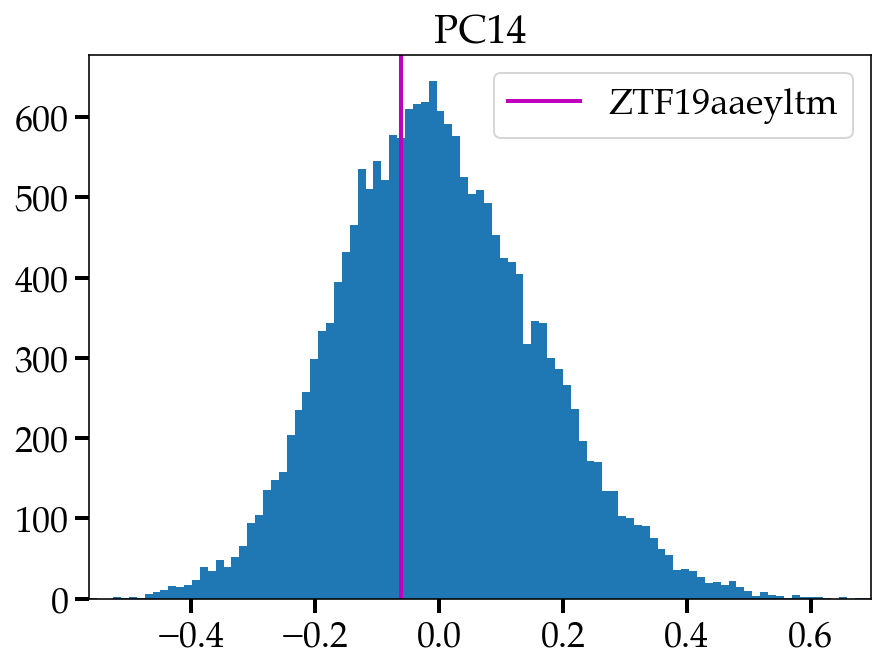

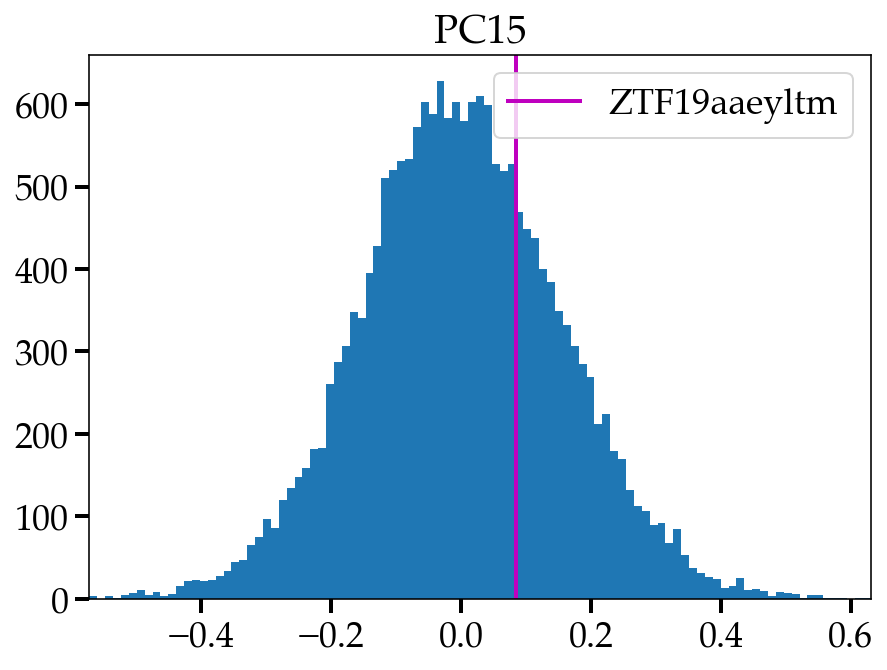

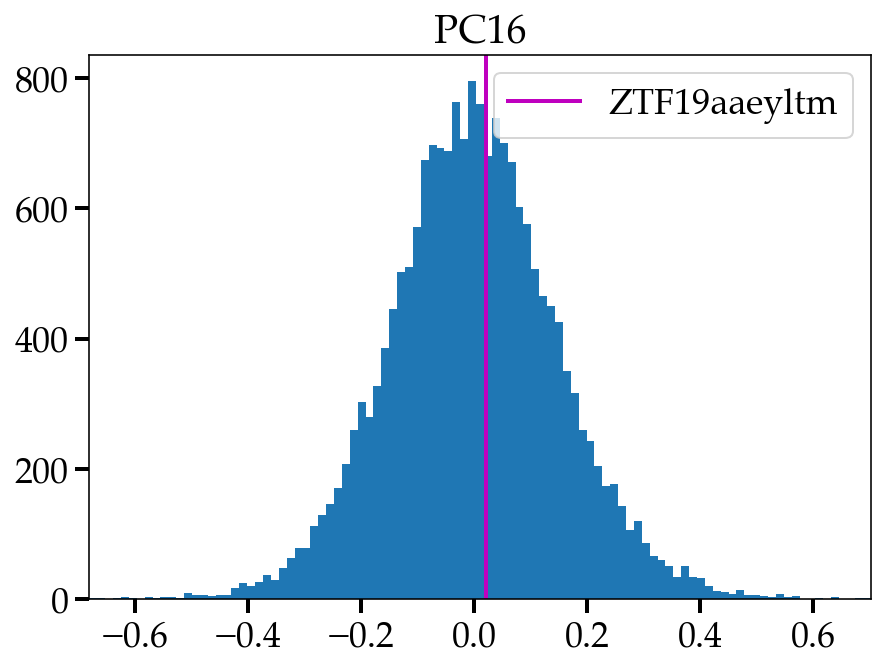

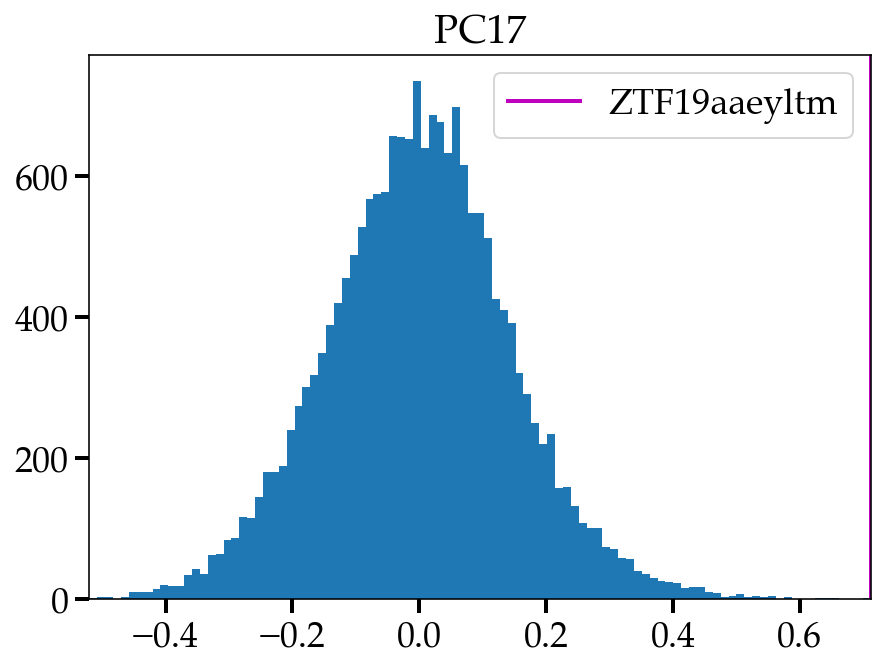

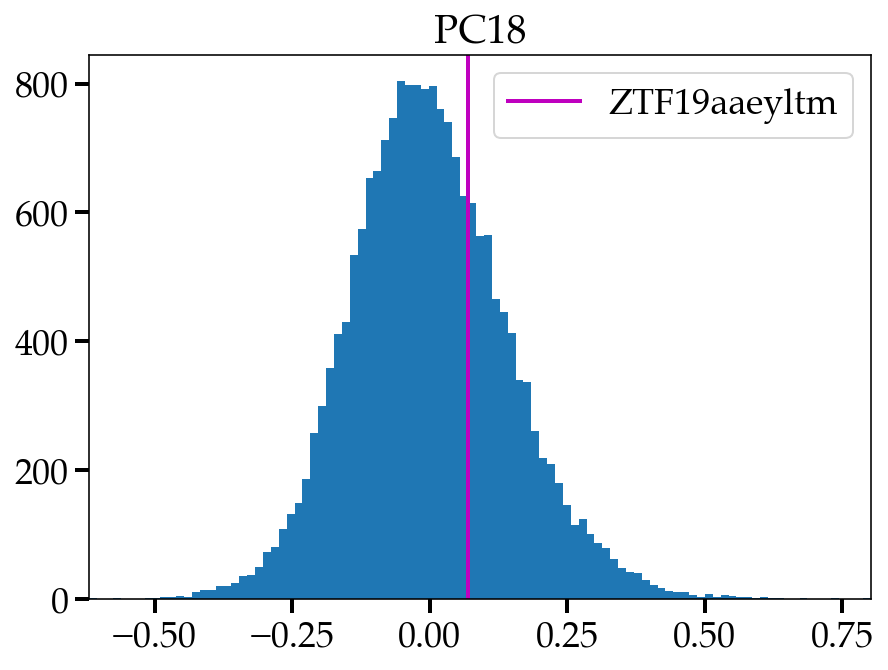

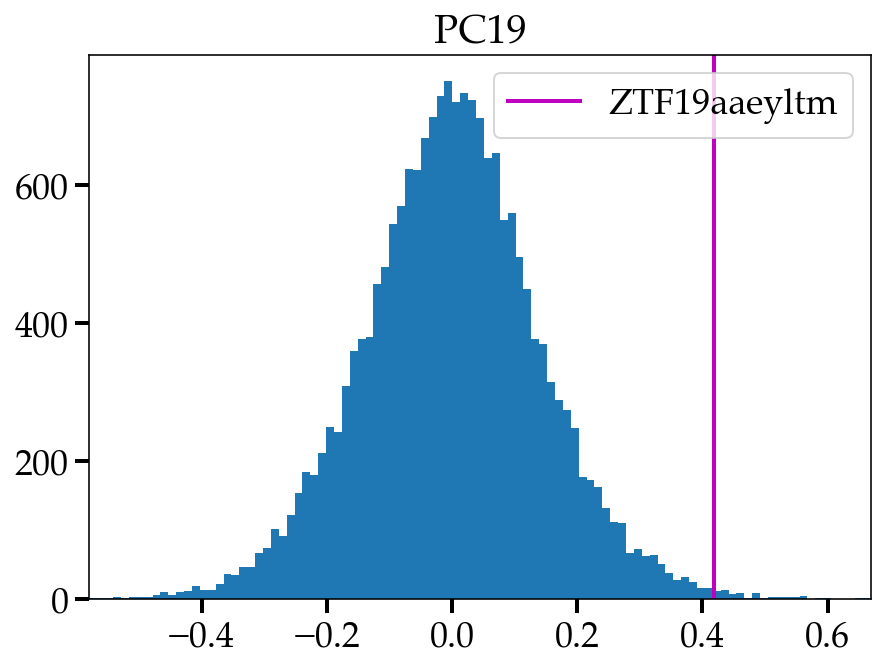

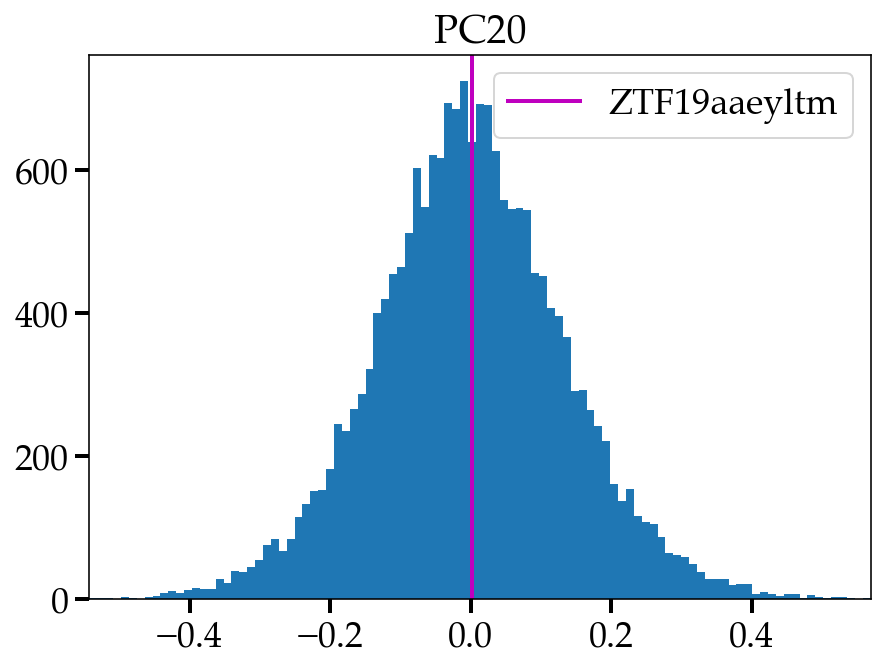

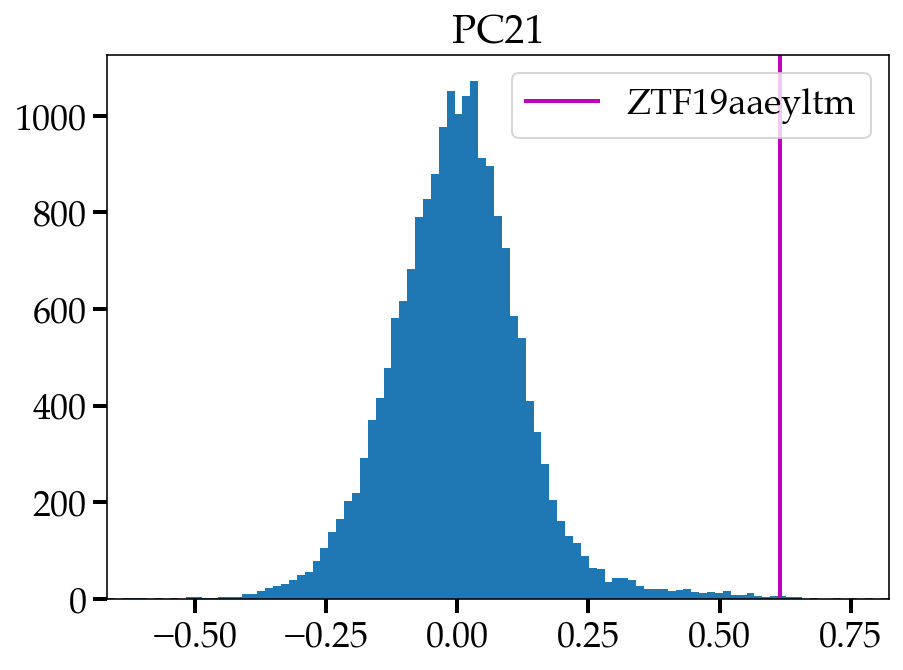

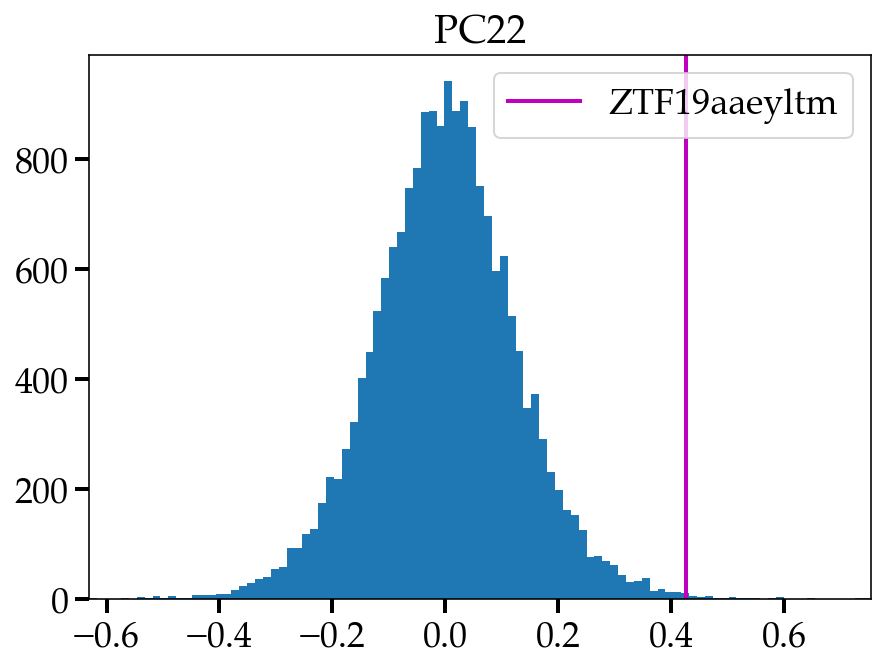

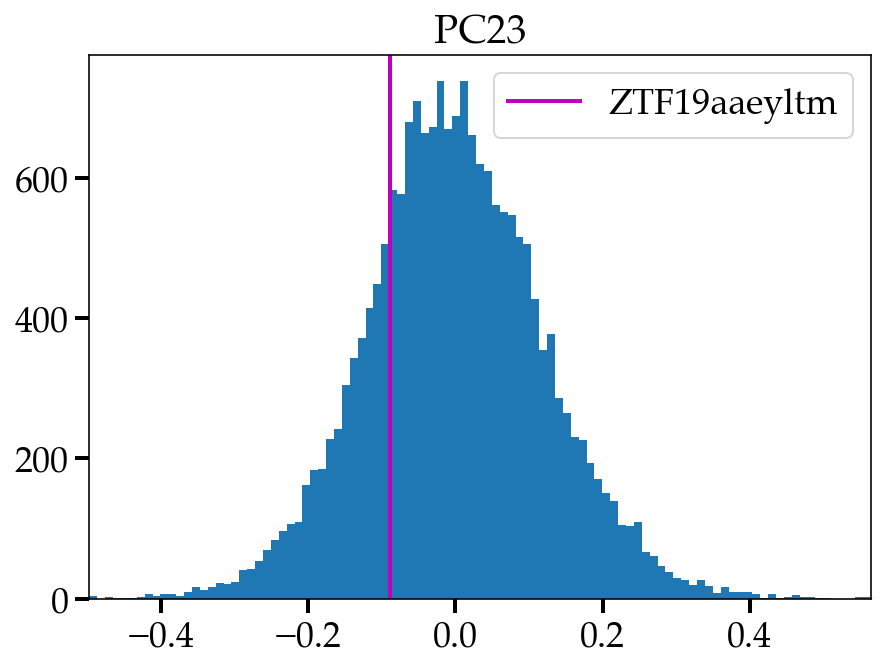

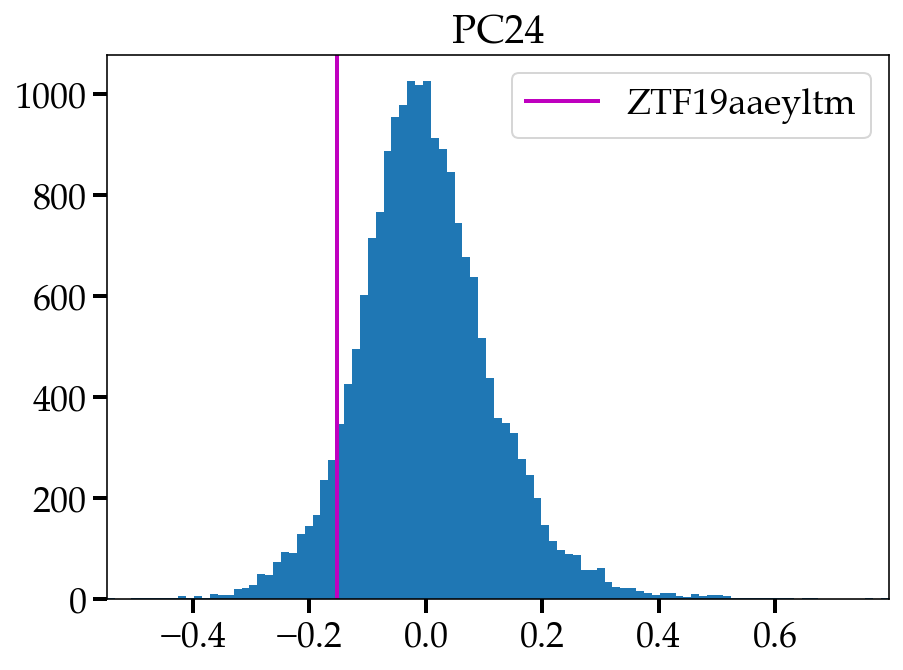

In [178]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [179]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

#print("ANN\t\tZTF_id\t\t\t\tHas TNS?\t\t\t\tSpec Cls\t\t\t\tspecz\t\t\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[-0.5259457063847892 1.3480167469330477 0.8331971001586684
 -0.33918331645558947 0.9615821406249786 0.44052464787340434
 0.44306332349405364 -0.10152922815390315 0.008873680042566062
 0.3290898881018452 -0.08756771595473838 -0.44440460446122154
 0.3742284197399551 0.5383057854540625 -0.061194011581842636
 0.08509052570499437 0.020903921006546193 0.7117409908991815
 0.06986773071965668 0.41891347614123586 0.0016684876182727192
 0.6160504873803867 0.4264621272391858 -0.0887180852855972
 -0.1528805932351843]
ZTF ID name (ref) ZTF19aaeyltm
https://alerce.online/object/ZTF19aaeyltm
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aaeyltm		No_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=164.00618542+57.11700351&filter=color

ANN=1	https://alerce.online/object/ZTF19absppft		No_TNS		None		z=-99.0			d=1.5724	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=353.97871095+29.71352394&filter=color

ANN=2	https://alerce.online/object/ZTF20acijzic		No_TNS		None		z=-99.0

In [180]:
antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)

In [182]:
# %%time

# ztf_id_ref = idx_arr[result_id[0]]
# ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
# df_ref = ref_info.timeseries.to_pandas()

# has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
# tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

# fig, ax = plt.subplots(figsize=(7,7))
# #plt.gca().invert_yaxis()

# df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
# df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

# ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
#             label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
# ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
# #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
# consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

# ztf_id_l = result_id[1:5]
# ztf_dist_l = result_dist[1:5]

# for num, loc in enumerate(ztf_id_l):
#     ztf_id_ann = idx_arr[ztf_id_l[num]]

#     l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
#     try:
#         df_knn = l_info.timeseries.to_pandas()
#     except: continue    
#     has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
#     tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
#     spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z

#     df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
#     df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

#     ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
#                 fmt=markers[num], c='darkred', alpha=0.25, 
#                 label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
#     ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
#                 fmt=markers[num], c='darkgreen', alpha=0.25)
#     #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

#     plt.ylabel('Apparent Mag. + Constant')
#     plt.xlabel('Days of event')
#     plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
#     plt.legend(frameon=False,
#                bbox_to_anchor=(1.00,0.53),
#                ncol=1)

#     plt.grid(True)
# plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}.jpg', dpi=150, bbox_inches='tight')

In [183]:
ann_dist_all_df.loc[ref_obj]

ann=0                  3680.000000
ann=1                 16841.000000
ann=2                 14160.000000
ann=3                  8856.000000
ann=4                  7635.000000
ann=5                 11746.000000
ann=6                  9656.000000
ann=7                 12066.000000
ann=8                  5663.000000
ann=9                 16138.000000
dist=0                    0.000000
dist=1                    1.572361
dist=2                    1.630087
dist=3                    1.630256
dist=4                    1.643077
dist=5                    1.656222
dist=6                    1.659050
dist=7                    1.700591
dist=8                    1.701785
dist=9                    1.705944
Mean-9ANNs                1.655486
WeightedMean-9ANNs        1.614741
Name: ZTF19aaeyltm, dtype: float64

In [184]:
# 100 largest distances
ann_dist_all_df[dist_col].nlargest(100)

key_0
ZTF19aaeyltm    1.614741
ZTF21acbalhp    1.612203
ZTF21aaxntve    1.472271
ZTF18abvmlow    1.452487
ZTF20abfehpe    1.435185
                  ...   
ZTF18abvlumw    1.066947
ZTF20aceokvr    1.065626
ZTF21aalnuqg    1.064823
ZTF18ablqgtm    1.063642
ZTF19abpqggd    1.063607
Name: WeightedMean-9ANNs, Length: 100, dtype: float64

In [185]:
# 100 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aaeyltm

https://alerce.online/object/ZTF21acbalhp

https://alerce.online/object/ZTF21aaxntve

https://alerce.online/object/ZTF18abvmlow

https://alerce.online/object/ZTF20abfehpe

https://alerce.online/object/ZTF18abvbbvs

https://alerce.online/object/ZTF20acqucpz

https://alerce.online/object/ZTF20abeywdn

https://alerce.online/object/ZTF18abtteya

https://alerce.online/object/ZTF18aabjliz

https://alerce.online/object/ZTF21aaaodzf

https://alerce.online/object/ZTF21aaaadvr

https://alerce.online/object/ZTF18adbmbpa

https://alerce.online/object/ZTF18aabhmmj

https://alerce.online/object/ZTF18aaxuusk

https://alerce.online/object/ZTF18aaqvatw

https://alerce.online/object/ZTF19acxfjcy

https://alerce.online/object/ZTF21aaaigfg

https://alerce.online/object/ZTF18abwkzjq

https://alerce.online/object/ZTF21aaaqtwd

https://alerce.online/object/ZTF20ablygyy

https://alerce.online/object/ZTF18aapdhva

https://alerce.online/object/ZTF20acynjjo

https://ale

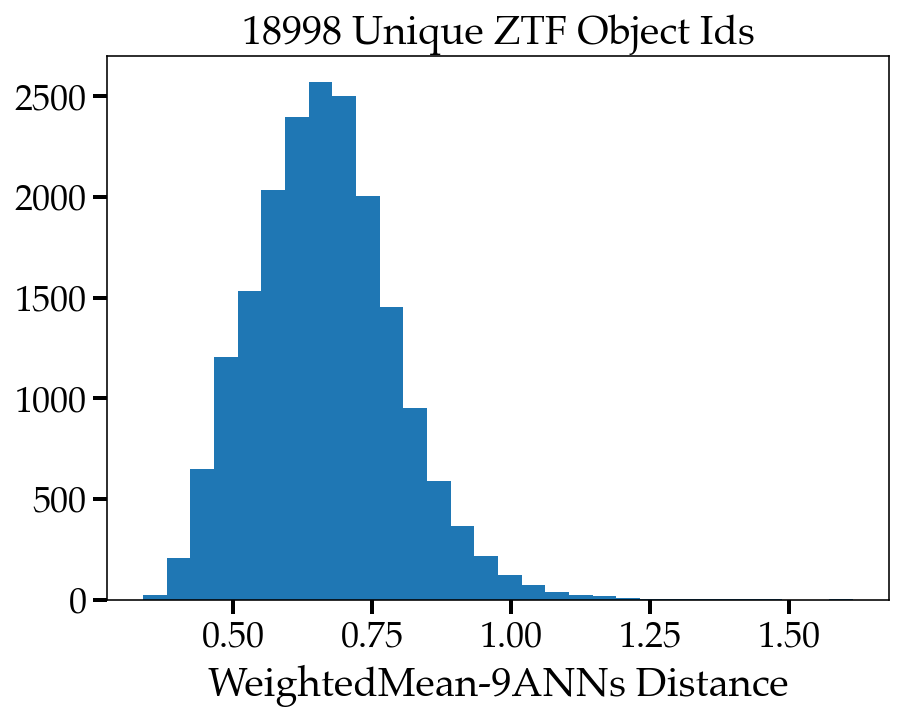

In [186]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [189]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.6649570311006273
Scatter median: 0.6595560904930938
Scatter std: 0.12811864052013286
Scatter max: 1.614741097797047
Scatter min: 0.3376547074453397


Most anomalous: ZTF19aaeyltm


# Smallest

### AGN/QSOs have smallest dist
### some stars, SN

In [190]:
ann_dist_all_df[dist_col].nsmallest(10)

key_0
ZTF19aalfali    0.337655
ZTF20aawoixs    0.354905
ZTF19aascqjr    0.357087
ZTF21abowuqe    0.360888
ZTF20abgxqyi    0.361048
ZTF18acefnew    0.362138
ZTF19abpkoqf    0.362457
ZTF19ablpvbh    0.363330
ZTF18aasgiyf    0.364958
ZTF21aarwlht    0.370372
Name: WeightedMean-9ANNs, dtype: float64

In [191]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF19aalfali

https://alerce.online/object/ZTF20aawoixs

https://alerce.online/object/ZTF19aascqjr

https://alerce.online/object/ZTF21abowuqe

https://alerce.online/object/ZTF20abgxqyi

https://alerce.online/object/ZTF18acefnew

https://alerce.online/object/ZTF19abpkoqf

https://alerce.online/object/ZTF19ablpvbh

https://alerce.online/object/ZTF18aasgiyf

https://alerce.online/object/ZTF21aarwlht

https://alerce.online/object/ZTF20abfphyf

https://alerce.online/object/ZTF19aasfayj

https://alerce.online/object/ZTF18abixqaz

https://alerce.online/object/ZTF18adaacad

https://alerce.online/object/ZTF19abyhwmw

https://alerce.online/object/ZTF19adcfrut

https://alerce.online/object/ZTF18abvzort

https://alerce.online/object/ZTF19abggdjc

https://alerce.online/object/ZTF19aazfrpy

https://alerce.online/object/ZTF19acmvzsy

https://alerce.online/object/ZTF19abkcmga

https://alerce.online/object/ZTF20aaemssm

https://alerce.online/object/ZTF17aaayial

https://ale

In [192]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
# print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
#     dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
#     print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    # host ra,dec
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    
    # tns
    has_tns_i = dataset_bank_tns_df.loc[idx_arr[i]].has_tns
    tns_cls_i = dataset_bank_tns_df.loc[idx_arr[i]].tns_cls
    spec_z_i = dataset_bank_tns_df.loc[idx_arr[i]].spec_z
    
    print(f"ANN={n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t{has_tns_i}\t\t{tns_cls_i}\t\tz={spec_z_i}\t\t\td={round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[0.4755114351259045 -0.001813966932123652 0.32290671032635476
 0.4615795739190978 -0.5089994350448915 -0.03229631229134704
 0.11862773102745945 0.16262250939587652 0.47697906464515627
 0.3401848760744024 -0.14409446412277513 0.15915385208082006
 -0.024809202660500088 0.0017849398747703659 0.016089416364186242
 -0.0363402640204246 0.08313488080566249 0.043783376910745665
 0.09533434500888478 0.009600441312319507 -0.005947673326089485
 -0.03490854518857566 0.05046331337177695 -0.11494764234892514
 0.42506115665565847]
ZTF ID name (ref) ZTF19aalfali
https://alerce.online/object/ZTF19aalfali
%%%%%%
ANN=0	https://alerce.online/object/ZTF19aalfali		Yes_TNS		None		z=-99.0			d=0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=267.06517947+55.23697266&filter=color

ANN=1	https://alerce.online/object/ZTF19aascqjr		No_TNS		None		z=-99.0			d=0.2587	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=218.41909158+60.96265845&filter=color

ANN=2	https://alerce.online/object/ZTF18abbpynb		No_TNS		N

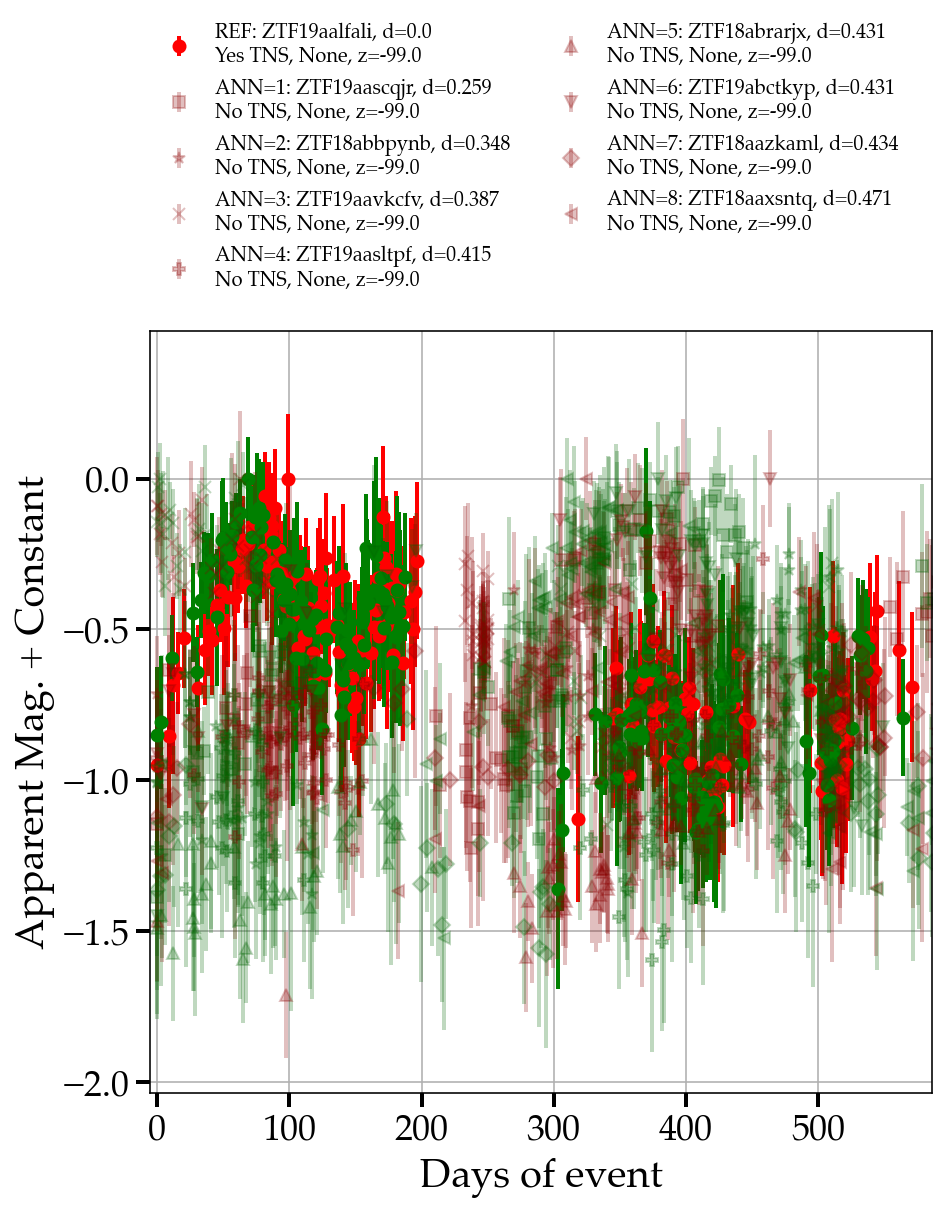

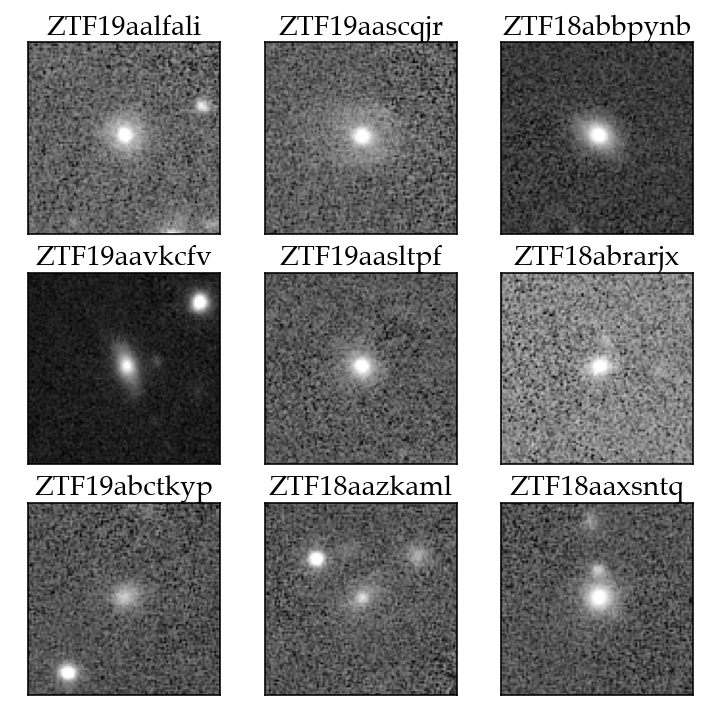

CPU times: user 6.17 s, sys: 326 ms, total: 6.49 s
Wall time: 21.7 s


In [193]:
%%time

host_df_ztf_id_l, host_df_ra_l, host_df_dec_l = [], [], []

ztf_id_ref = idx_arr[result_id[0]]
ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
df_ref = ref_info.timeseries.to_pandas()

has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls
spec_z_ref = dataset_bank_tns_df.loc[ztf_id_ref].spec_z

ra_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].raMean
dec_ref = dataset_bank_orig_host_ra_dec.loc[ztf_id_ref].decMean
host_df_ztf_id_l.append(ztf_id_ref), host_df_ra_l.append(ra_ref), host_df_dec_l.append(dec_ref)


fig, ax = plt.subplots(figsize=(7,7))
#plt.gca().invert_yaxis()

df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag.min()-df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
            label=f'REF: {ztf_id_ref}, d={round(result_dist[0], 3)}\n{has_tns_ref},\t{tns_cls_ref},\tz={round(spec_z_ref, 3)}')
ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag.min()-df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
#ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1]-df_ref_r.ant_mag.min(), s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

ztf_id_l = result_id[1:9]
ztf_dist_l = result_dist[1:9]

for num, loc in enumerate(ztf_id_l):
    ztf_id_ann = idx_arr[ztf_id_l[num]]

    l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
    try:
        df_knn = l_info.timeseries.to_pandas()
    except: continue    
    has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
    tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls
    spec_z_knn = dataset_bank_tns_df.loc[ztf_id_ann].spec_z
    
    ra_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[ztf_id_ann].decMean
    host_df_ztf_id_l.append(ztf_id_ann), host_df_ra_l.append(ra_i), host_df_dec_l.append(dec_i)

    df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
    df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

    ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag.min()-df_r.ant_mag, yerr=df_r.ant_magerr, 
                fmt=markers[num], c='darkred', alpha=0.25, 
                label=f'ANN={num+1}: {ztf_id_ann}, d={round(ztf_dist_l[num], 3)}\n{has_tns_knn},\t{tns_cls_knn},\tz={round(spec_z_knn, 3)}')
    ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag.min()-df_g.ant_mag, yerr=df_g.ant_magerr, 
                fmt=markers[num], c='darkgreen', alpha=0.25)
    #ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]-df_r.ant_mag.min(), s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

    plt.ylabel('Apparent Mag. + Constant')
    plt.xlabel('Days of event')
    plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15)
    plt.legend(frameon=False,
               bbox_to_anchor=(0.98,1.43),
               ncol=2,
               prop={'size': 10})

    plt.grid(True)
    
plt.savefig(f'../figures/{ztf_id_ref}_ann={num+1}.jpg', dpi=150, bbox_inches='tight')

host_5ann_df = pd.DataFrame(zip(host_df_ztf_id_l, host_df_ra_l, host_df_dec_l), columns=['name', 'ra', 'dec'])

host_pdfs(df=host_5ann_df)

In [194]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787

# pandas profiling

In [195]:
ann_dist_all_tns_df = pd.concat([ann_dist_all_df, dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_df = ann_dist_all_tns_df[~ann_dist_all_tns_df.isnull().any(axis=1)]

ann_dist_all_tns_df

ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
ZTF17aaaaenu  18790   6649  14428  13209   8815   9274   3639  18882  11811   
ZTF17aaaazhi  16293  11694   5764   6680  11784   7680   1242   1227    241   
ZTF17aaaazmz   9278  18392   4196  10854   3557  14164   5253  13787  10115   
ZTF17aaabghb   7729   8345  10679   2012  11735   2262  13702  11841  18175   
ZTF17aaabuab  13760  12701  16799  16398   2745   1950   2455   3872   5941   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21acogvaq   8545   4406   3097   2777  10814   5763  16150  17304  13656   
ZTF21acowflo   7527   7924   9290   4445   9522  10720  10343   9505  11086   
ZTF21acqdfea   7777   1489   8136   9363   2915   8363   5053   1731   1148   
ZTF21acqnurt   8040   5704   3780   4052   8575  11187   9349   2586  11183   
ZTF21acqtdnd  14318   7559   5555   5262  13649   3350   8138   8468  12555   

              ann=9  ...    dist=6    dist=7    dist=8    dist=9  Mean-9ANNs  \
ZTF17aaaaenu  10853  ...  0.742511  0.746813  0.748877  0.755348    0.690890   
ZTF17aaaazhi   9193  ...  0.841621  0.858785  0.859848  0.885726    0.810450   
ZTF17aaaazmz  13747  ...  0.769616  0.781522  0.811449  0.815898    0.731266   
ZTF17aaabghb  16756  ...  0.651527  0.674423  0.674603  0.676841    0.618966   
ZTF17aaabuab  13726  ...  0.780780  0.790355  0.790408  0.803593    0.757617   
...             ...  ...       ...       ...       ...       ...         ...   
ZTF21acogvaq  11409  ...  0.760236  0.760792  0.762532  0.773601    0.714427   
ZTF21acowflo  18775  ...  0.771659  0.777427  0.802097  0.846605    0.761127   
ZTF21acqdfea  17114  ...  0.625753  0.635121  0.643767  0.648494    0.614630   
ZTF21acqnurt  18577  ...  0.951696  0.960042  0.969216  0.984275    0.912838   
ZTF21acqtdnd  16045  ...  1.003344  1.012045  1.013979  1.016001    0.960844   

              WeightedMean-9ANNs  has_tns  tns_cls  spec_z  report_group  
ZTF17aaaaenu            0.624640   No_TNS     None   -99.0          None  
ZTF17aaaazhi            0.749399   No_TNS     None   -99.0          None  
ZTF17aaaazmz            0.652753   No_TNS     None   -99.0          None  
ZTF17aaabghb            0.564710   No_TNS     None   -99.0          None  
ZTF17aaabuab            0.724266   No_TNS     None   -99.0          None  
...                          ...      ...      ...     ...           ...  
ZTF21acogvaq            0.647232   No_TNS     None   -99.0          None  
ZTF21acowflo            0.708966   No_TNS     None   -99.0          None  
ZTF21acqdfea            0.587512   No_TNS     None   -99.0          None  
ZTF21acqnurt            0.856098   No_TNS     None   -99.0          None  
ZTF21acqtdnd            0.883940  Yes_TNS     None   -99.0    GaiaAlerts  

[18992 rows x 26 columns]

In [196]:
ann_dist_all_tns_and_hosts_df_p1 = pd.concat([ann_dist_all_df.iloc[:,11:],
                                           dataset_bank_tns_and_hosts_df.iloc[:, 0:11],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_hosts_df_p1 = ann_dist_all_tns_and_hosts_df_p1[~ann_dist_all_tns_and_hosts_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_hosts_df_p1

dist=1    dist=2    dist=3    dist=4    dist=5    dist=6  \
ZTF17aaaaenu  0.564324  0.621359  0.662255  0.671815  0.704712  0.742511   
ZTF17aaaazhi  0.698033  0.731143  0.797333  0.799613  0.821951  0.841621   
ZTF17aaaazmz  0.579852  0.653540  0.680907  0.736289  0.752320  0.769616   
ZTF17aaabghb  0.525743  0.559669  0.578989  0.579965  0.648935  0.651527   
ZTF17aaabuab  0.707938  0.716577  0.718821  0.735090  0.774993  0.780780   
...                ...       ...       ...       ...       ...       ...   
ZTF21acogvaq  0.575783  0.641003  0.703482  0.724333  0.728081  0.760236   
ZTF21acowflo  0.649055  0.715405  0.757582  0.759642  0.770670  0.771659   
ZTF21acqdfea  0.567670  0.582402  0.594392  0.610871  0.623199  0.625753   
ZTF21acqnurt  0.809573  0.860435  0.871391  0.880221  0.928690  0.951696   
ZTF21acqtdnd  0.768858  0.937540  0.946313  0.947807  1.001709  1.003344   

                dist=7    dist=8    dist=9  Mean-9ANNs  ...  gPSFFlux  \
ZTF17aaaaenu  0.746813  0.748877  0.755348    0.690890  ...  0.000006   
ZTF17aaaazhi  0.858785  0.859848  0.885726    0.810450  ...  0.000008   
ZTF17aaaazmz  0.781522  0.811449  0.815898    0.731266  ...  0.000022   
ZTF17aaabghb  0.674423  0.674603  0.676841    0.618966  ...  0.000027   
ZTF17aaabuab  0.790355  0.790408  0.803593    0.757617  ...  0.000030   
...                ...       ...       ...         ...  ...       ...   
ZTF21acogvaq  0.760792  0.762532  0.773601    0.714427  ...  0.000019   
ZTF21acowflo  0.777427  0.802097  0.846605    0.761127  ...  0.000003   
ZTF21acqdfea  0.635121  0.643767  0.648494    0.614630  ...  0.000010   
ZTF21acqnurt  0.960042  0.969216  0.984275    0.912838  ...  0.000003   
ZTF21acqtdnd  1.012045  1.013979  1.016001    0.960844  ...  0.000008   

               gApFlux  gKronFlux  gKronRad  gExtNSigma  rmomentXX  has_tns  \
ZTF17aaaaenu  0.000013   0.000015   3.78109   12.034700   0.240854   No_TNS   
ZTF17aaaazhi  0.000010   0.000009   2.83895    2.027450   0.146499   No_TNS   
ZTF17aaaazmz  0.000036   0.000035   3.51821   10.532400   0.254686   No_TNS   
ZTF17aaabghb  0.000043   0.000044   4.06217    9.808500   0.288022   No_TNS   
ZTF17aaabuab  0.000056   0.000056   3.96768   15.671700   0.237536   No_TNS   
...                ...        ...       ...         ...        ...      ...   
ZTF21acogvaq  0.000038   0.000039   3.84154   15.055400   0.185502   No_TNS   
ZTF21acowflo  0.000006   0.000007   3.67332    3.683880   0.249079   No_TNS   
ZTF21acqdfea  0.000023   0.000026   4.15479   15.726700   0.289378   No_TNS   
ZTF21acqnurt  0.000004   0.000004   2.81373    3.489210   0.245337   No_TNS   
ZTF21acqtdnd  0.000008   0.000007   2.52650    0.472144   0.172303  Yes_TNS   

              tns_cls  spec_z  report_group  
ZTF17aaaaenu     None   -99.0          None  
ZTF17aaaazhi     None   -99.0          None  
ZTF17aaaazmz     None   -99.0          None  
ZTF17aaabghb     None   -99.0          None  
ZTF17aaabuab     None   -99.0          None  
...               ...     ...           ...  
ZTF21acogvaq     None   -99.0          None  
ZTF21acowflo     None   -99.0          None  
ZTF21acqdfea     None   -99.0          None  
ZTF21acqnurt     None   -99.0          None  
ZTF21acqtdnd     None   -99.0    GaiaAlerts  

[18992 rows x 26 columns]

In [197]:
ann_dist_all_tns_and_lcfeats_df_p1 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 0:21],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_lcfeats_df_p1 = ann_dist_all_tns_and_lcfeats_df_p1[~ann_dist_all_tns_and_lcfeats_df_p1.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p1

Mean-9ANNs  WeightedMean-9ANNs  feature_amplitude_magn_r  \
ZTF17aaaaenu    0.690890            0.624640                  0.994978   
ZTF17aaaazhi    0.810450            0.749399                  1.198246   
ZTF17aaaazmz    0.731266            0.652753                  1.171598   
ZTF17aaabghb    0.618966            0.564710                  0.362954   
ZTF17aaabuab    0.757617            0.724266                  0.320659   
...                  ...                 ...                       ...   
ZTF21acogvaq    0.714427            0.647232                  0.208000   
ZTF21acowflo    0.761127            0.708966                  1.043352   
ZTF21acqdfea    0.614630            0.587512                  1.103750   
ZTF21acqnurt    0.912838            0.856098                  1.511355   
ZTF21acqtdnd    0.960844            0.883940                  0.943990   

              feature_anderson_darling_normal_magn_r  \
ZTF17aaaaenu                               -0.133575   
ZTF17aaaazhi                                0.304374   
ZTF17aaaazmz                               -0.125017   
ZTF17aaabghb                               -0.653712   
ZTF17aaabuab                               -0.848917   
...                                              ...   
ZTF21acogvaq                               -1.031033   
ZTF21acowflo                                0.176584   
ZTF21acqdfea                               -0.195983   
ZTF21acqnurt                               -0.366659   
ZTF21acqtdnd                                0.335738   

              feature_beyond_1_std_magn_r  feature_beyond_2_std_magn_r  \
ZTF17aaaaenu                     0.192308                     0.196116   
ZTF17aaaazhi                     0.440000                     0.000000   
ZTF17aaaazmz                     0.229508                     0.181071   
ZTF17aaabghb                     0.444444                     0.000000   
ZTF17aaabuab                     0.400000                     0.000000   
...                                   ...                          ...   
ZTF21acogvaq                     0.500000                     0.000000   
ZTF21acowflo                     0.413793                     0.000000   
ZTF21acqdfea                     0.314286                     0.239046   
ZTF21acqnurt                     0.285714                     0.000000   
ZTF21acqtdnd                     0.200000                     0.000000   

              feature_cusum_magn_r  feature_inter_percentile_range_2_magn_r  \
ZTF17aaaaenu              0.158742                                 1.972990   
ZTF17aaaazhi              0.264522                                 2.396492   
ZTF17aaaazmz              0.230875                                 2.106324   
ZTF17aaabghb              0.334459                                 0.725908   
ZTF17aaabuab              0.398610                                 0.641317   
...                            ...                                      ...   
ZTF21acogvaq              0.400851                                 0.416000   
ZTF21acowflo              0.337711                                 2.075553   
ZTF21acqdfea              0.177260                                 2.062999   
ZTF21acqnurt              0.357832                                 3.022711   
ZTF21acqtdnd              0.376860                                 1.887980   

              feature_inter_percentile_range_10_magn_r  \
ZTF17aaaaenu                                  0.814137   
ZTF17aaaazhi                                  2.000199   
ZTF17aaaazmz                                  0.937863   
ZTF17aaabghb                                  0.667269   
ZTF17aaabuab                                  0.641317   
...                                                ...   
ZTF21acogvaq                                  0.416000   
ZTF21acowflo                                  1.568862   
ZTF21acqdfea                                  1.245758   
ZTF21acqnurt                      

In [198]:
ann_dist_all_tns_and_lcfeats_df_p2 = pd.concat([ann_dist_all_df.iloc[:,20:],
                                           dataset_bank_tns_and_lcfeats_df.iloc[:, 21:41],
                                           dataset_bank_tns_and_hosts_df.iloc[:,-4:]], axis=1)
ann_dist_all_tns_and_lcfeats_df_p2 = ann_dist_all_tns_and_lcfeats_df_p2[~ann_dist_all_tns_and_lcfeats_df_p2.isnull().any(axis=1)]

ann_dist_all_tns_and_lcfeats_df_p2

Mean-9ANNs  WeightedMean-9ANNs  \
ZTF17aaaaenu    0.690890            0.624640   
ZTF17aaaazhi    0.810450            0.749399   
ZTF17aaaazmz    0.731266            0.652753   
ZTF17aaabghb    0.618966            0.564710   
ZTF17aaabuab    0.757617            0.724266   
...                  ...                 ...   
ZTF21acogvaq    0.714427            0.647232   
ZTF21acowflo    0.761127            0.708966   
ZTF21acqdfea    0.614630            0.587512   
ZTF21acqnurt    0.912838            0.856098   
ZTF21acqtdnd    0.960844            0.883940   

              feature_percent_difference_magnitude_percentile_10_magn_r  \
ZTF17aaaaenu                                          -1.360545           
ZTF17aaaazhi                                          -0.939406           
ZTF17aaaazmz                                          -1.246568           
ZTF17aaabghb                                          -1.416847           
ZTF17aaabuab                                          -1.477782           
...                                                         ...           
ZTF21acogvaq                                          -1.689292           
ZTF21acowflo                                          -1.008615           
ZTF21acqdfea                                          -1.115018           
ZTF21acqnurt                                          -0.789242           
ZTF21acqtdnd                                          -0.983584           

              feature_period_s_to_n_0_magn_r  feature_period_s_to_n_1_magn_r  \
ZTF17aaaaenu                        2.125293                        1.992442   
ZTF17aaaazhi                        1.815708                        1.591342   
ZTF17aaaazmz                        2.179178                        1.933757   
ZTF17aaabghb                        1.344333                        1.333010   
ZTF17aaabuab                        1.488277                        1.323163   
...                                      ...                             ...   
ZTF21acogvaq                        1.403898                        1.316485   
ZTF21acowflo                        2.177635                        1.889092   
ZTF21acqdfea                        2.050165                        1.911864   
ZTF21acqnurt                        1.460312                        1.448992   
ZTF21acqtdnd                        1.546082                        1.497795   

              feature_period_s_to_n_2_magn_r  feature_period_s_to_n_3_magn_r  \
ZTF17aaaaenu                        1.744146                        1.643873   
ZTF17aaaazhi                        1.539998                        1.538721   
ZTF17aaaazmz                        1.855695                        1.721224   
ZTF17aaabghb                        1.328976                        1.289912   
ZTF17aaabuab                        1.001883                        0.864970   
...                                      ...                             ...   
ZTF21acogvaq                        1.123045                        0.248722   
ZTF21acowflo                        1.746470                        1.722375   
ZTF21acqdfea                        1.884375                        1.830220   
ZTF21acqnurt                        1.435716                        1.250504   
ZTF21acqtdnd                        1.422824                        1.328929   

              feature_period_s_to_n_4_magn_r  \
ZTF17aaaaenu                        1.467939   
ZTF17aaaazhi                        1.322658   
ZTF17aaaazmz                        1.688221   
ZTF17aaabghb                        1.243621   
ZTF17aaabuab                        0.854680   
...                                      ...   
ZTF21acogvaq                       -0.249409   
ZTF21acowflo                        1.587684   
ZTF21acqdfea                        1.639242   
ZTF21acqnurt                        1.178680   
ZTF21acqtdnd                        1.231618   

              feature_periodogram_bey

import pandas_profiling as pp
profile = pp.ProfileReport(ann_dist_all_tns_and_lcfeats_df_p2)
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("ann_dist_all_tns_and_lcfeats_df_p2.html")

import pandas_profiling as pp
profile = pp.ProfileReport(dataset_bank_orig[0:1000])
#profile = pp.ProfileReport(dataset_bank_tns_df)
#profile.to_file("output.html")
profile.to_file("dataset_bank_orig.html")

In [199]:
# %%time

# ztf_id_ref = idx_arr[result_id[0]]
# ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
# df_ref = ref_info.timeseries.to_pandas()

# has_tns_ref = dataset_bank_tns_df.loc[ztf_id_ref].has_tns.replace('_', ' ')
# tns_cls_ref = dataset_bank_tns_df.loc[ztf_id_ref].tns_cls

# fig, ax = plt.subplots(figsize=(7,11))
# plt.gca().invert_yaxis()

# df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
# df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

# ax.errorbar(x=df_ref_r.ant_mjd-df_ref_r.ant_mjd.iloc[0], y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', label=f'ref {ztf_id_ref}')
# ax.errorbar(x=df_ref_g.ant_mjd-df_ref_g.ant_mjd.iloc[0], y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
# ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_ref_r.ant_mag[-1], s=f'Ref: {has_tns_ref}   {tns_cls_ref}')

# markers = ['s', '*', 'x', 'P', '^', 'v', 'D', '<', '>', '8', 'p', 'x'] 
# consts = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36] 

# ztf_id_l = result_id[1:8]
# ztf_dist_l = result_dist[1:8]

# for num, loc in enumerate(ztf_id_l):
#     ztf_id_ann = idx_arr[ztf_id_l[num]]

#     l_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ann)
#     try:
#         df_knn = l_info.timeseries.to_pandas()
#     except: continue    
#     has_tns_knn = dataset_bank_tns_df.loc[ztf_id_ann].has_tns.replace('_', ' ')
#     tns_cls_knn = dataset_bank_tns_df.loc[ztf_id_ann].tns_cls

#     df_g = df_knn[(df_knn.ant_passband == 'g') & (~df_knn.ant_mag.isna())]
#     df_r = df_knn[(df_knn.ant_passband == 'R') & (~df_knn.ant_mag.isna())]

#     ax.errorbar(x=df_r.ant_mjd-df_r.ant_mjd.iloc[0], y=df_r.ant_mag+consts[num], yerr=df_r.ant_magerr, 
#                 fmt=markers[num], c='darkred', alpha=0.5, label=f'ANN={num+1} {ztf_id_ann} d={round(ztf_dist_l[num], 3)}')
#     ax.errorbar(x=df_g.ant_mjd-df_g.ant_mjd.iloc[0], y=df_g.ant_mag+consts[num], yerr=df_g.ant_magerr, 
#                 fmt=markers[num], c='darkgreen', alpha=0.5)
#     ax.text(df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+15, df_r.ant_mag[-1]+consts[num], s=f'ANN={num+1}: {has_tns_knn}   {tns_cls_knn}')

#     plt.ylabel('Apparent Mag. + Constant')
#     plt.xlabel('Days of event')
#     plt.xlim(-5, df_ref_r.ant_mjd.iloc[-1]-df_ref_r.ant_mjd.iloc[0]+50)
#     plt.legend(frameon=False,
#                bbox_to_anchor=(1.00,0.98),
#                ncol=1)

#     plt.grid(True)
# #plt.savefig(f'./LAISS_figures/{ztf_id_ref}_knn={num+1}.png', dpi=300, bbox_inches='tight')

In [200]:
ann_dist_all_tns_df

ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
ZTF17aaaaenu  18790   6649  14428  13209   8815   9274   3639  18882  11811   
ZTF17aaaazhi  16293  11694   5764   6680  11784   7680   1242   1227    241   
ZTF17aaaazmz   9278  18392   4196  10854   3557  14164   5253  13787  10115   
ZTF17aaabghb   7729   8345  10679   2012  11735   2262  13702  11841  18175   
ZTF17aaabuab  13760  12701  16799  16398   2745   1950   2455   3872   5941   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21acogvaq   8545   4406   3097   2777  10814   5763  16150  17304  13656   
ZTF21acowflo   7527   7924   9290   4445   9522  10720  10343   9505  11086   
ZTF21acqdfea   7777   1489   8136   9363   2915   8363   5053   1731   1148   
ZTF21acqnurt   8040   5704   3780   4052   8575  11187   9349   2586  11183   
ZTF21acqtdnd  14318   7559   5555   5262  13649   3350   8138   8468  12555   

              ann=9  ...    dist=6    dist=7    dist=8    dist=9  Mean-9ANNs  \
ZTF17aaaaenu  10853  ...  0.742511  0.746813  0.748877  0.755348    0.690890   
ZTF17aaaazhi   9193  ...  0.841621  0.858785  0.859848  0.885726    0.810450   
ZTF17aaaazmz  13747  ...  0.769616  0.781522  0.811449  0.815898    0.731266   
ZTF17aaabghb  16756  ...  0.651527  0.674423  0.674603  0.676841    0.618966   
ZTF17aaabuab  13726  ...  0.780780  0.790355  0.790408  0.803593    0.757617   
...             ...  ...       ...       ...       ...       ...         ...   
ZTF21acogvaq  11409  ...  0.760236  0.760792  0.762532  0.773601    0.714427   
ZTF21acowflo  18775  ...  0.771659  0.777427  0.802097  0.846605    0.761127   
ZTF21acqdfea  17114  ...  0.625753  0.635121  0.643767  0.648494    0.614630   
ZTF21acqnurt  18577  ...  0.951696  0.960042  0.969216  0.984275    0.912838   
ZTF21acqtdnd  16045  ...  1.003344  1.012045  1.013979  1.016001    0.960844   

              WeightedMean-9ANNs  has_tns  tns_cls  spec_z  report_group  
ZTF17aaaaenu            0.624640   No_TNS     None   -99.0          None  
ZTF17aaaazhi            0.749399   No_TNS     None   -99.0          None  
ZTF17aaaazmz            0.652753   No_TNS     None   -99.0          None  
ZTF17aaabghb            0.564710   No_TNS     None   -99.0          None  
ZTF17aaabuab            0.724266   No_TNS     None   -99.0          None  
...                          ...      ...      ...     ...           ...  
ZTF21acogvaq            0.647232   No_TNS     None   -99.0          None  
ZTF21acowflo            0.708966   No_TNS     None   -99.0          None  
ZTF21acqdfea            0.587512   No_TNS     None   -99.0          None  
ZTF21acqnurt            0.856098   No_TNS     None   -99.0          None  
ZTF21acqtdnd            0.883940  Yes_TNS     None   -99.0    GaiaAlerts  

[18992 rows x 26 columns]

AGN
Mean 0.6742775376547466
https://alerce.online/object/ZTF18abuoilc


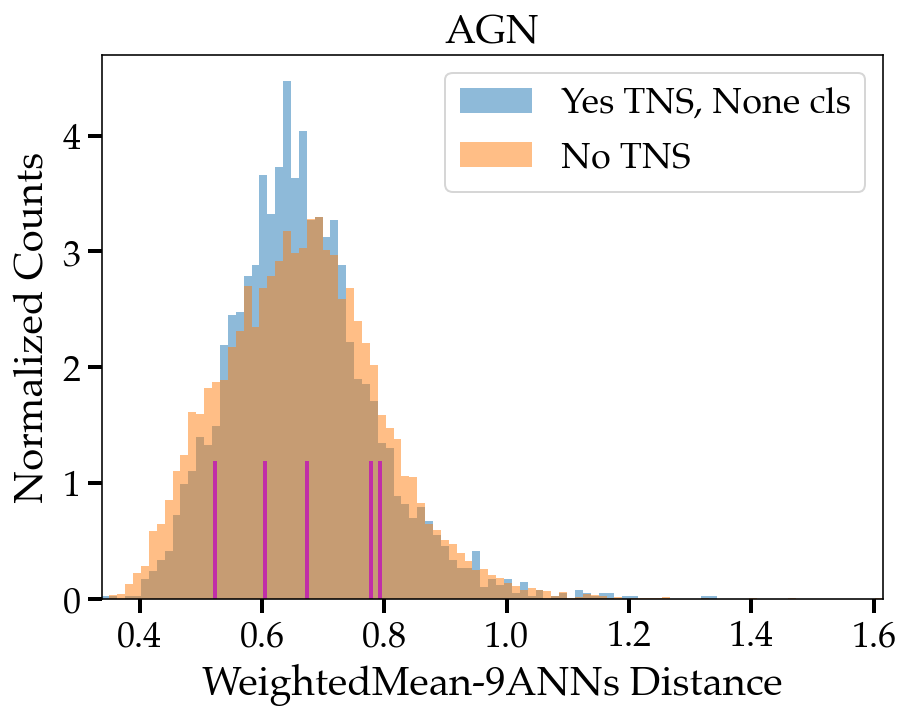

CV
Mean 0.9518941618276365


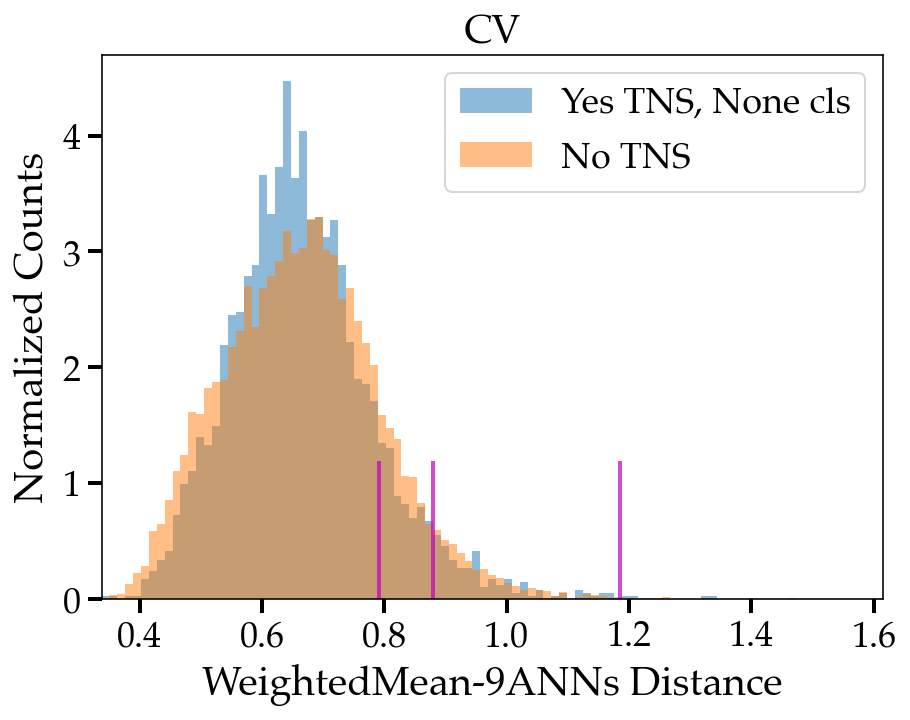

None
Mean 0.6657490907145618


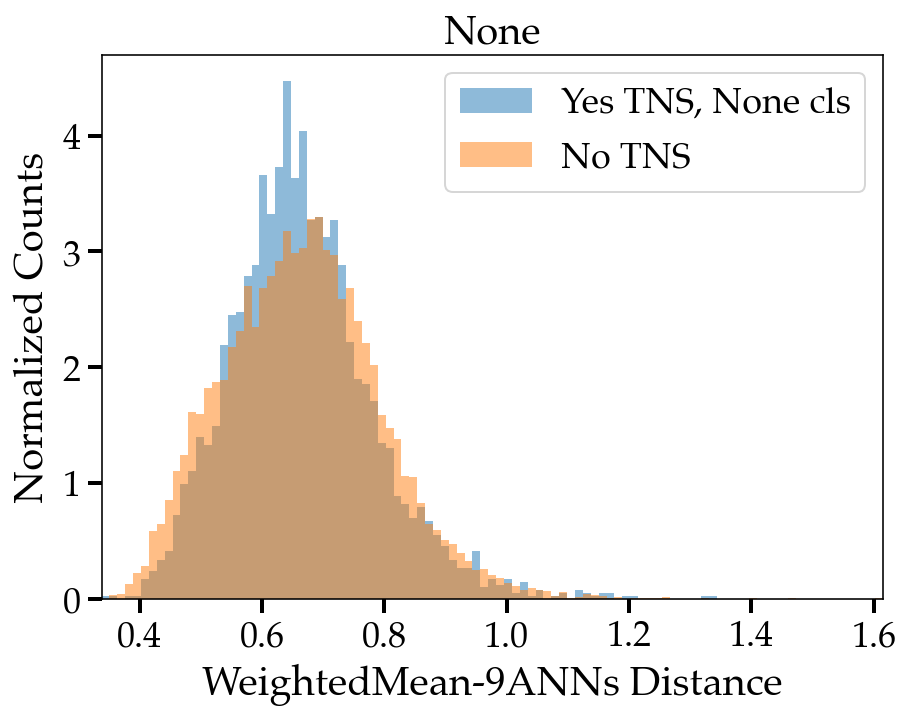

Nova
Mean 0.7104283207745263
https://alerce.online/object/ZTF20acplkub


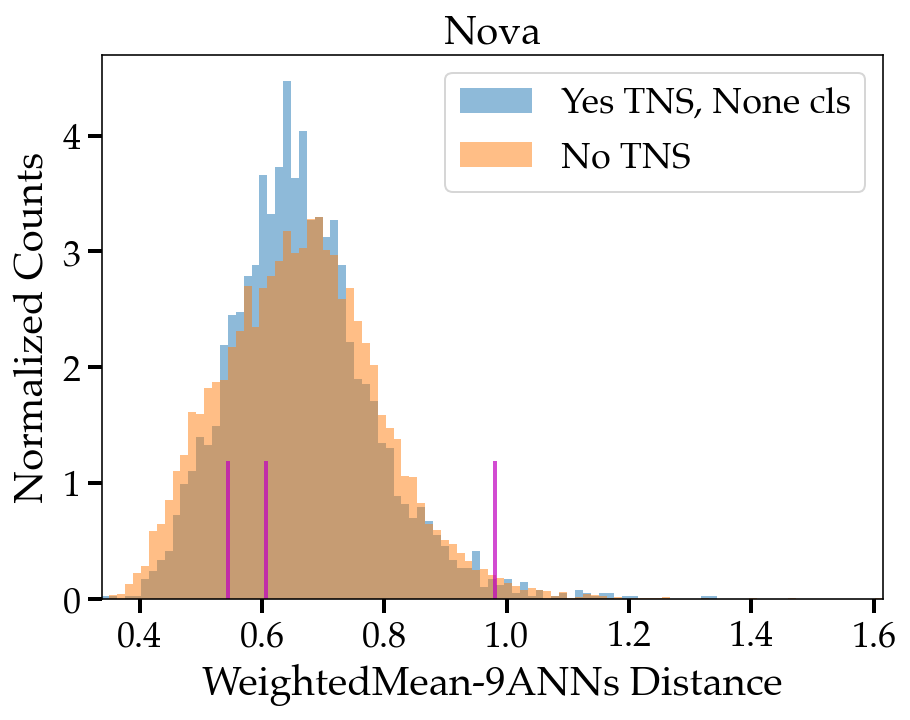

Other
Mean 0.6636416268619624
https://alerce.online/object/ZTF21abjciua


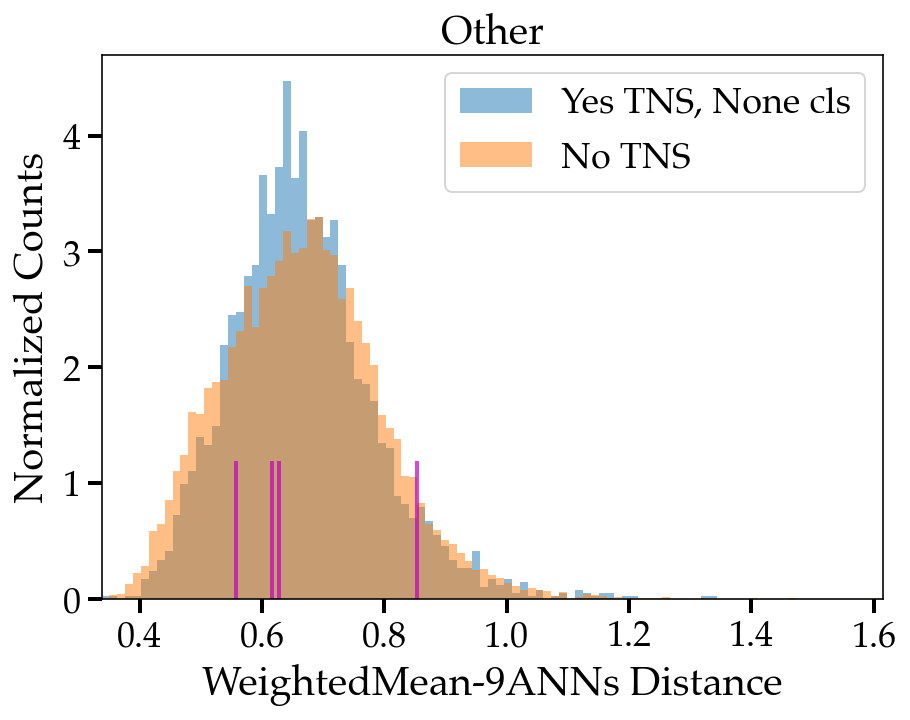

SLSN-I
Mean 0.631921767511151
https://alerce.online/object/ZTF20acilzkh
https://alerce.online/object/ZTF21aaarmti


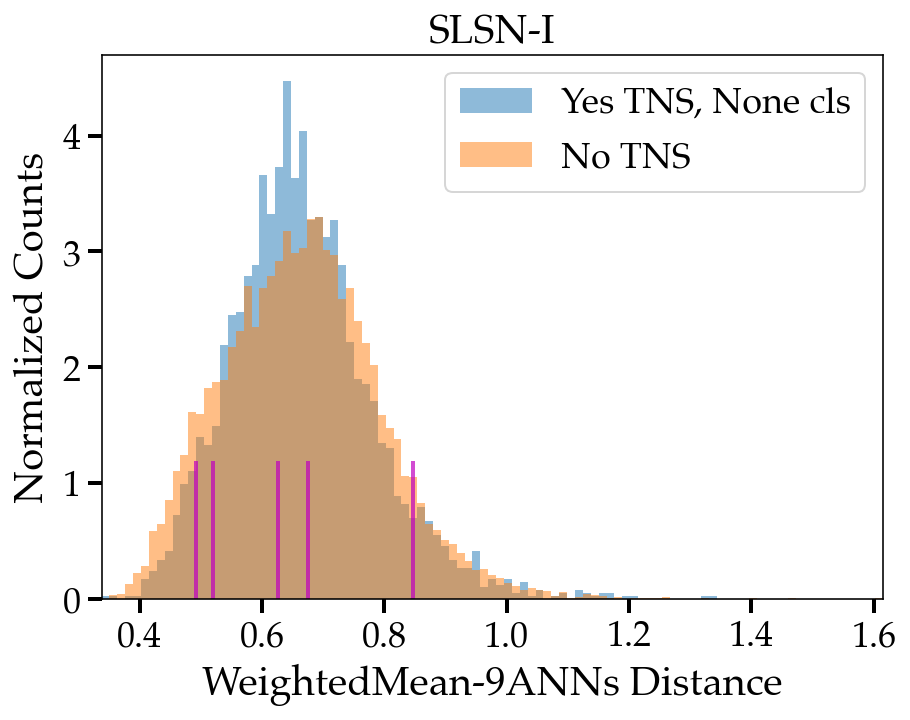

SLSN-II
Mean 0.5711274243794479
https://alerce.online/object/ZTF18abxbmqh
https://alerce.online/object/ZTF20aaurzyt
https://alerce.online/object/ZTF20achupkw
https://alerce.online/object/ZTF20aclnqle
https://alerce.online/object/ZTF20acnznms
https://alerce.online/object/ZTF21aanefkx


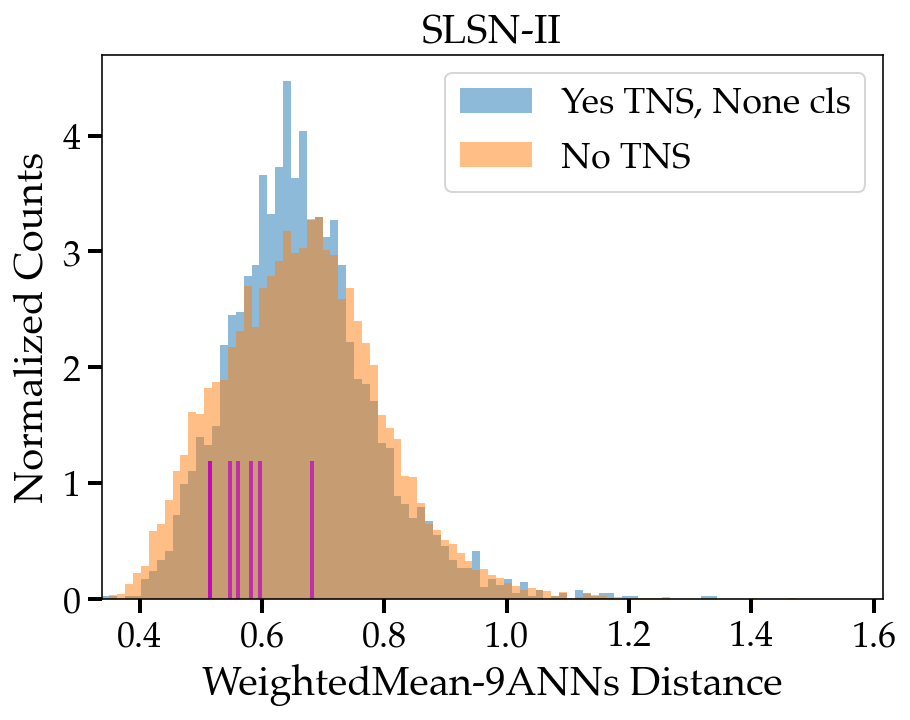

SN
Mean 0.7334085201675241


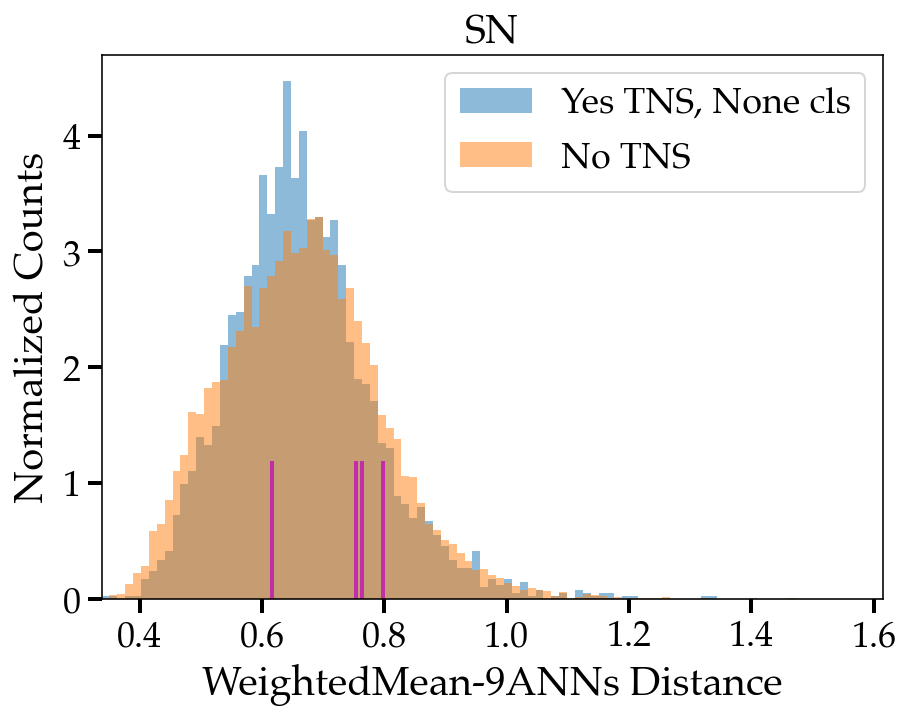

SN I
Mean 0.6190314242108302
https://alerce.online/object/ZTF20acwuiuo
https://alerce.online/object/ZTF21aaqwfqe


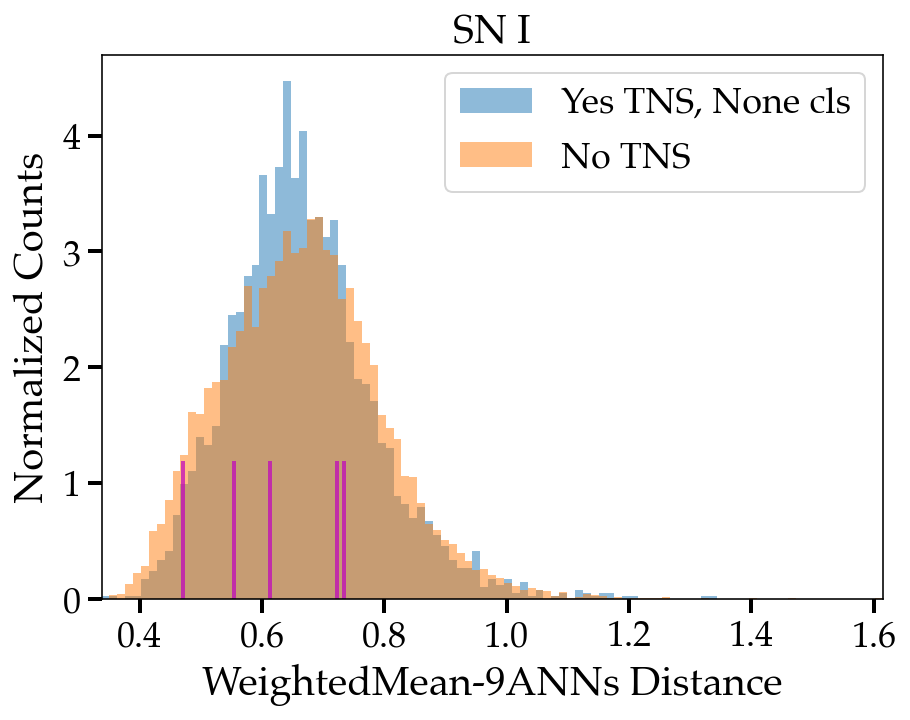

SN II
Mean 0.7277630980577263
https://alerce.online/object/ZTF18aacnlxz
https://alerce.online/object/ZTF18acebssa
https://alerce.online/object/ZTF20abqferm
https://alerce.online/object/ZTF20abvtybi
https://alerce.online/object/ZTF20abxyifx
https://alerce.online/object/ZTF20abywydb
https://alerce.online/object/ZTF20abyzomt
https://alerce.online/object/ZTF20abzcefc
https://alerce.online/object/ZTF20abzqlts
https://alerce.online/object/ZTF20accdijx
https://alerce.online/object/ZTF20accrkpa
https://alerce.online/object/ZTF20acgnenc
https://alerce.online/object/ZTF20achnfaa
https://alerce.online/object/ZTF20achuhlt
https://alerce.online/object/ZTF20acjbhhp
https://alerce.online/object/ZTF20acnzkxb
https://alerce.online/object/ZTF20acpbdvm
https://alerce.online/object/ZTF20acpkses
https://alerce.online/object/ZTF20acpqbfu
https://alerce.online/object/ZTF20actnuls
https://alerce.online/object/ZTF20actnzzk
https://alerce.online/object/ZTF20acufmte
https://alerce.online/object/ZTF20acuhgar
http

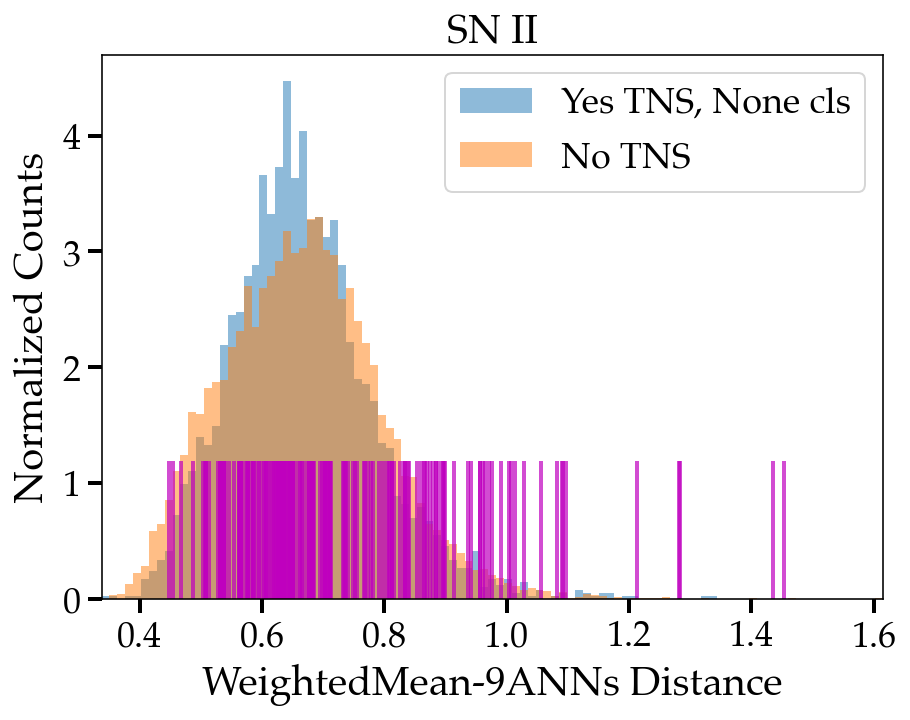

SN II-pec
Mean 0.6023136837915941
https://alerce.online/object/ZTF20acvdfmw


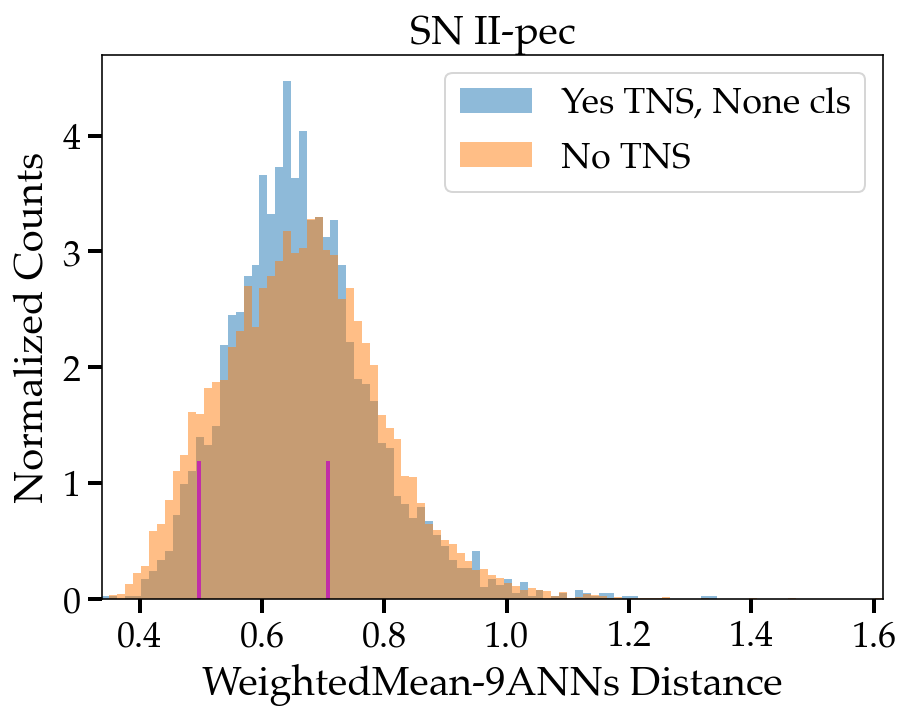

SN IIP
Mean 0.6781788922921576
https://alerce.online/object/ZTF20acrinvz


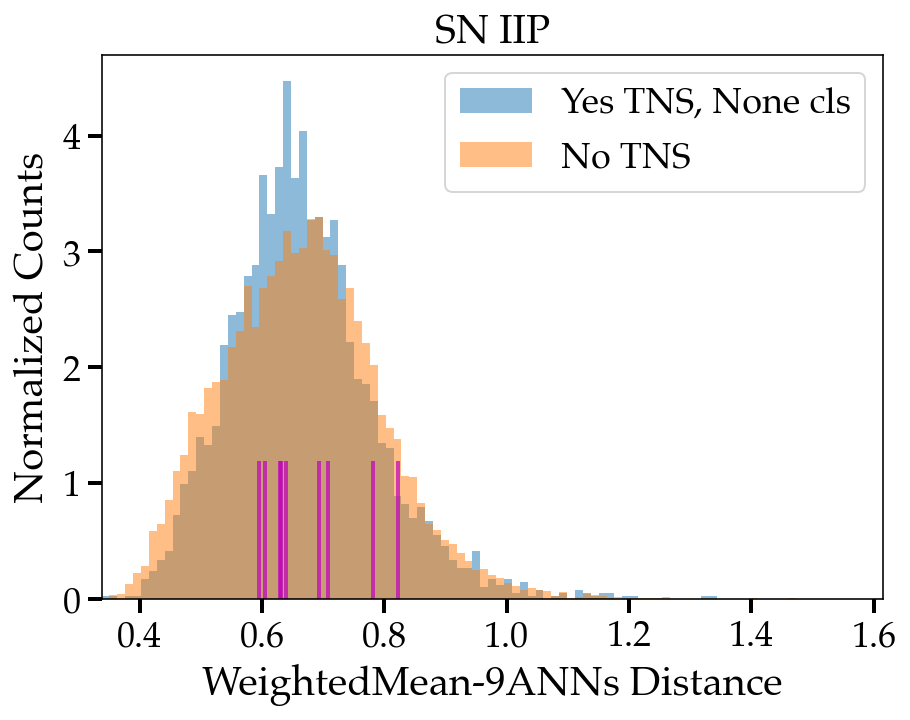

SN IIb
Mean 0.7596272238191555
https://alerce.online/object/ZTF21aaxxmvs


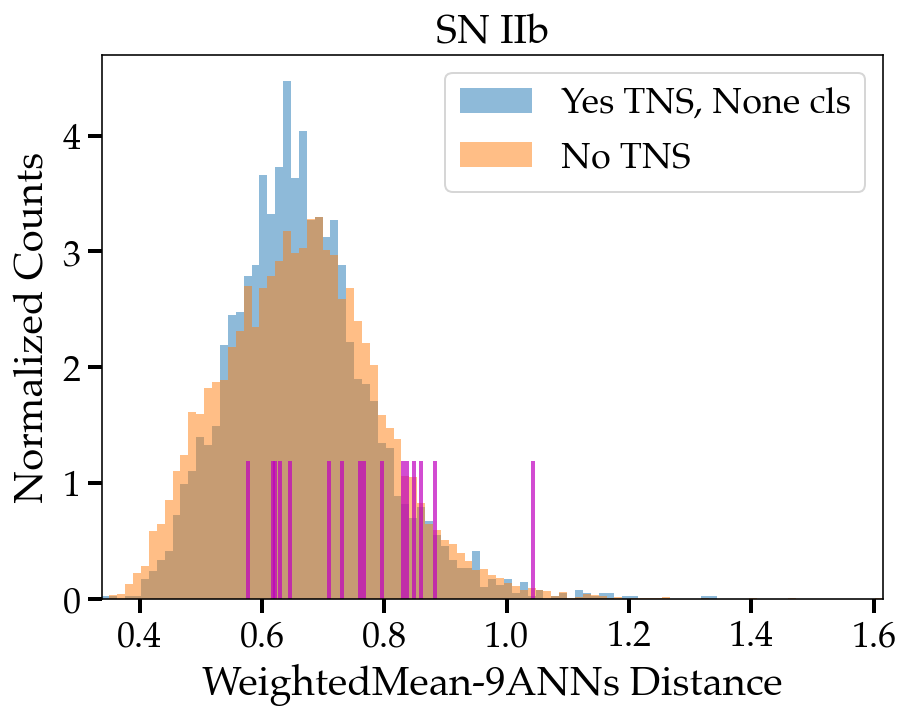

SN IIn
Mean 0.7554117681044024
https://alerce.online/object/ZTF18acnnfty
https://alerce.online/object/ZTF19aadoota
https://alerce.online/object/ZTF20abpmqnr
https://alerce.online/object/ZTF20abzhvnj
https://alerce.online/object/ZTF20acisvli
https://alerce.online/object/ZTF20actkulc
https://alerce.online/object/ZTF21aaoqbbw


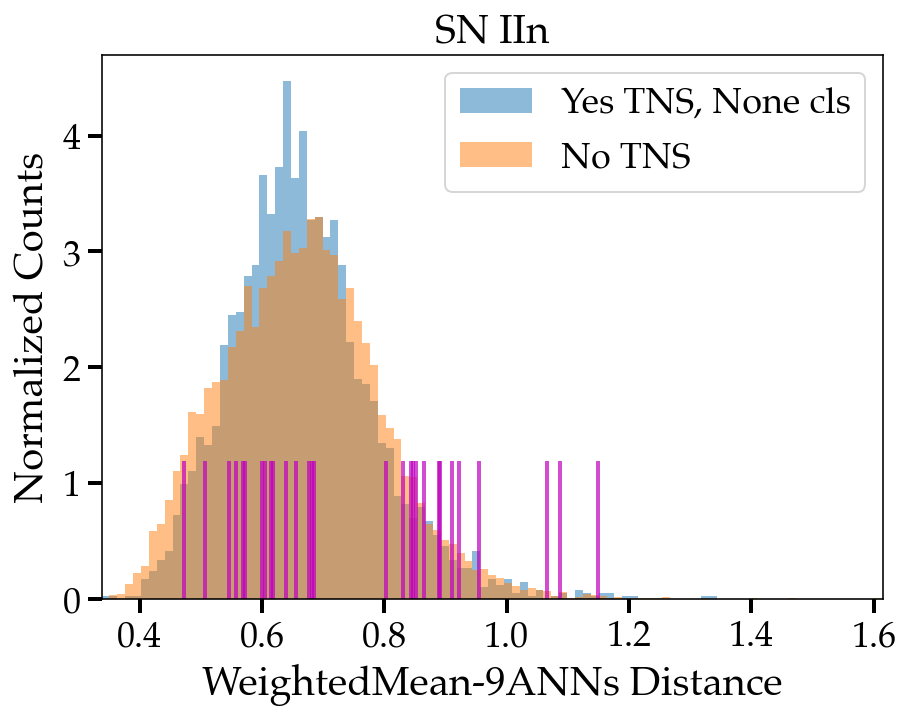

SN Ia
Mean 0.6218272049585837
https://alerce.online/object/ZTF18aabeszt
https://alerce.online/object/ZTF18aahfbqp
https://alerce.online/object/ZTF18aajjhkq
https://alerce.online/object/ZTF18aatgdph
https://alerce.online/object/ZTF18ablmduj
https://alerce.online/object/ZTF18abrfccm
https://alerce.online/object/ZTF18acbxjaa
https://alerce.online/object/ZTF18acsremz
https://alerce.online/object/ZTF20abqfgee
https://alerce.online/object/ZTF20abvyauy
https://alerce.online/object/ZTF20abvykmy
https://alerce.online/object/ZTF20abwcnhm
https://alerce.online/object/ZTF20abxzrqw
https://alerce.online/object/ZTF20abydkrl
https://alerce.online/object/ZTF20abygigy
https://alerce.online/object/ZTF20abylbuf
https://alerce.online/object/ZTF20abyvtds
https://alerce.online/object/ZTF20abywzvj
https://alerce.online/object/ZTF20abzaknn
https://alerce.online/object/ZTF20abzvxyk
https://alerce.online/object/ZTF20acajvrj
https://alerce.online/object/ZTF20acauthg
https://alerce.online/object/ZTF20acbnoqi
http

https://alerce.online/object/ZTF21aalnyny
https://alerce.online/object/ZTF21aaloalc
https://alerce.online/object/ZTF21aalxurs
https://alerce.online/object/ZTF21aalydkl
https://alerce.online/object/ZTF21aamfcji
https://alerce.online/object/ZTF21aamiukc
https://alerce.online/object/ZTF21aamjgfp
https://alerce.online/object/ZTF21aamwzfi
https://alerce.online/object/ZTF21aantxma
https://alerce.online/object/ZTF21aanwfjk
https://alerce.online/object/ZTF21aanyfqu
https://alerce.online/object/ZTF21aanyyde
https://alerce.online/object/ZTF21aaocibg
https://alerce.online/object/ZTF21aaodljj
https://alerce.online/object/ZTF21aaoexgy
https://alerce.online/object/ZTF21aaoexjt
https://alerce.online/object/ZTF21aaomuka
https://alerce.online/object/ZTF21aaossxf
https://alerce.online/object/ZTF21aaovdlh
https://alerce.online/object/ZTF21aapduck
https://alerce.online/object/ZTF21aapehpx
https://alerce.online/object/ZTF21aaphlty
https://alerce.online/object/ZTF21aapjcqb
https://alerce.online/object/ZTF21

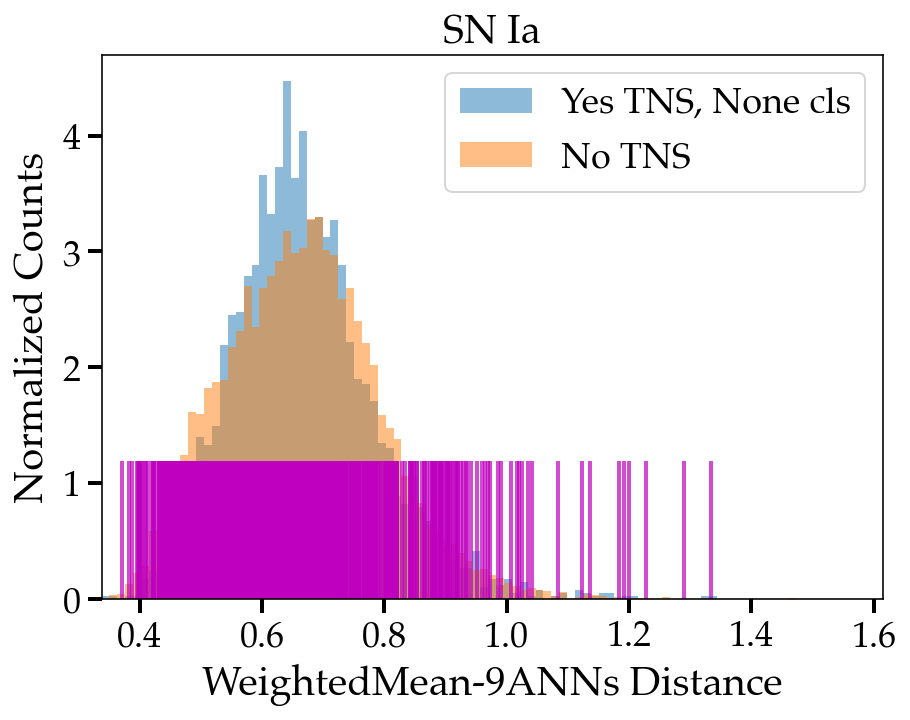

SN Ia-91T-like
Mean 0.6329323194971189
https://alerce.online/object/ZTF20achrklb
https://alerce.online/object/ZTF20acobxlz
https://alerce.online/object/ZTF20acwnrty
https://alerce.online/object/ZTF20aczgoml
https://alerce.online/object/ZTF21aajtsba
https://alerce.online/object/ZTF21aamucom
https://alerce.online/object/ZTF21aanrvcq
https://alerce.online/object/ZTF21aapvxnf
https://alerce.online/object/ZTF21aatnxwt
https://alerce.online/object/ZTF21aaxtrlt
https://alerce.online/object/ZTF21abbxdcm


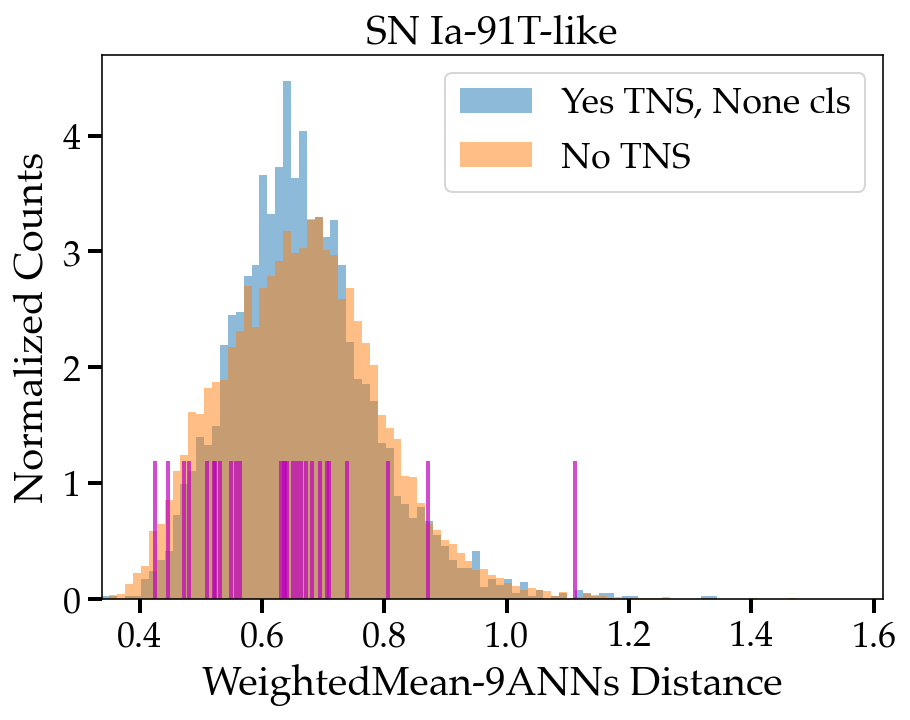

SN Ia-91bg-like
Mean 0.6694116307930513
https://alerce.online/object/ZTF20acgkuay
https://alerce.online/object/ZTF21aapjmda


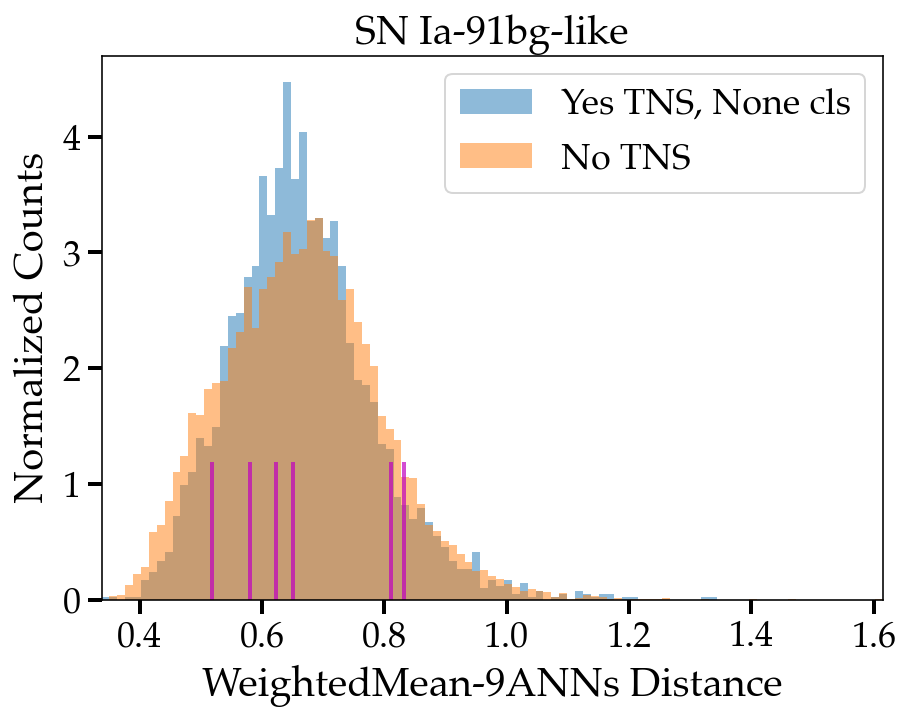

SN Ia-CSM
Mean 0.7436372531634389


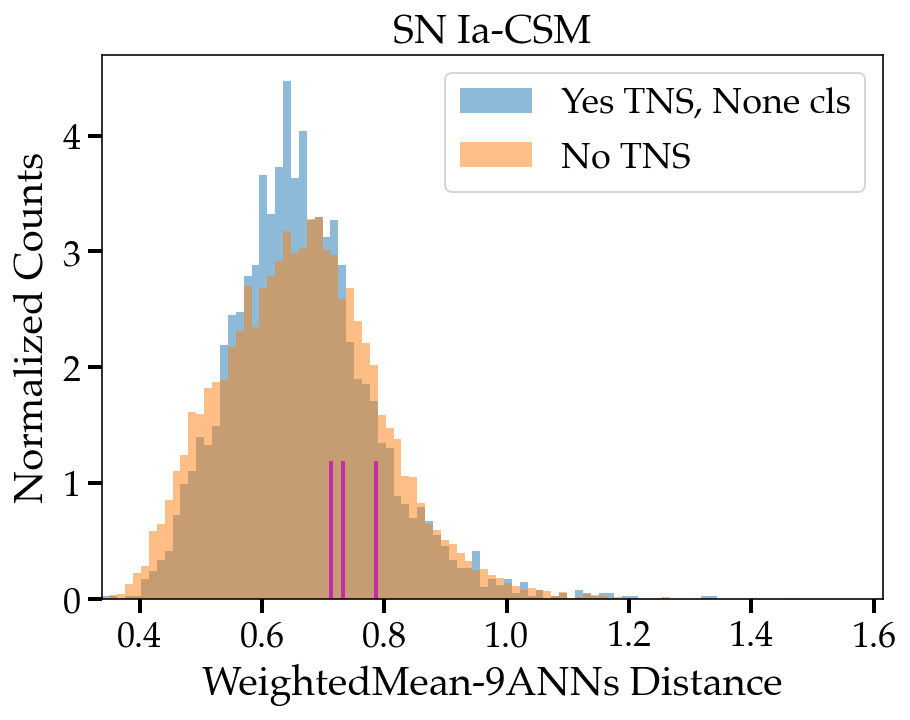

SN Ia-pec
Mean 0.6678592144426975
https://alerce.online/object/ZTF21aahfjbs
https://alerce.online/object/ZTF21aarenhl
https://alerce.online/object/ZTF21abfyxpf


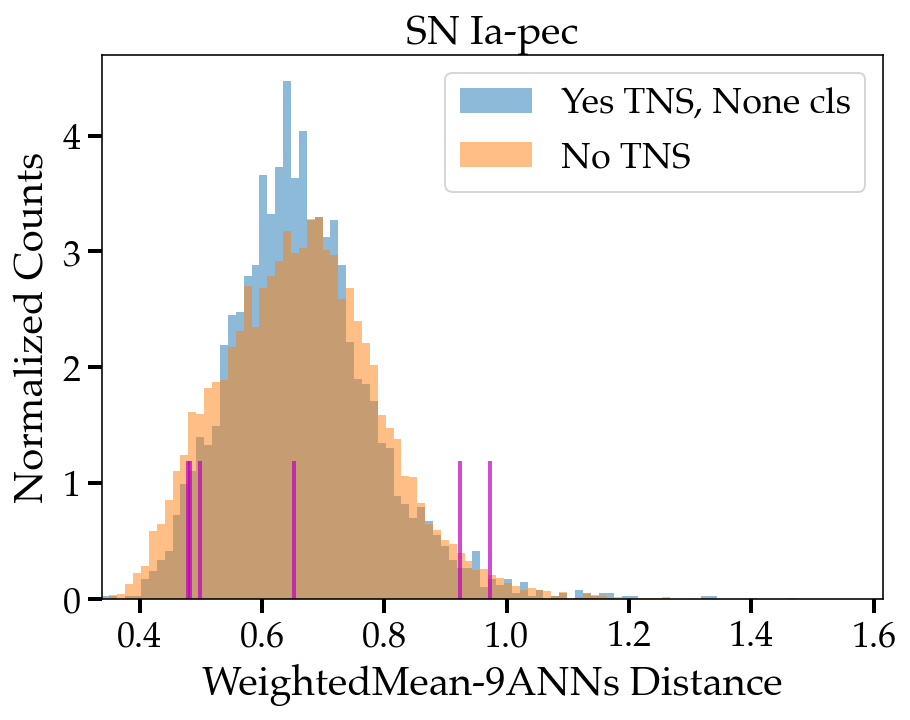

SN Iax[02cx-like]
Mean 0.6497920436615293
https://alerce.online/object/ZTF21aagqdvr
https://alerce.online/object/ZTF21aavotzn


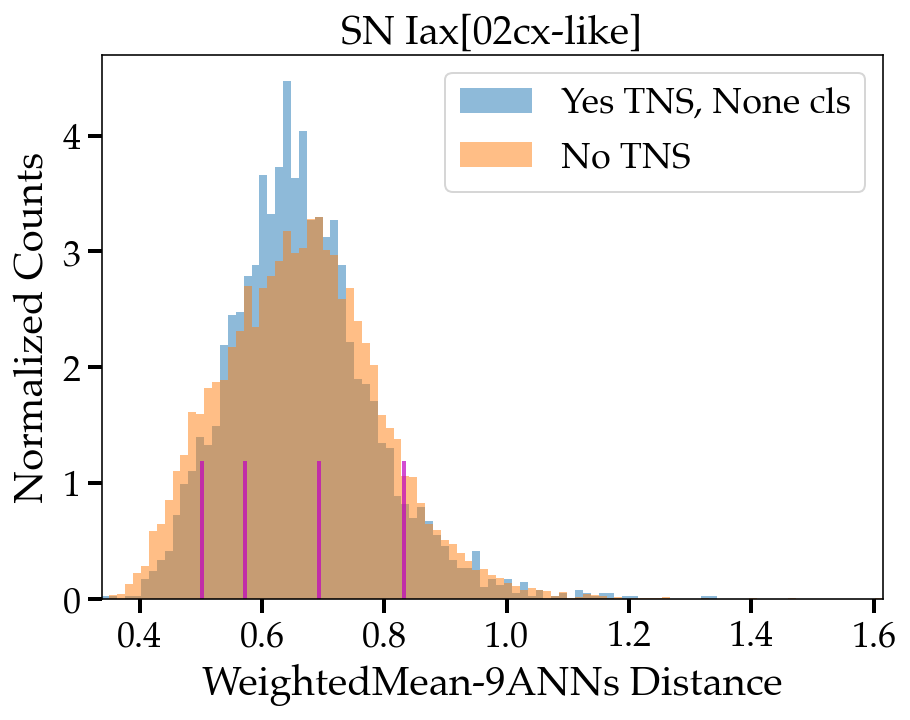

SN Ib
Mean 0.6999261457931231
https://alerce.online/object/ZTF20abvquuo
https://alerce.online/object/ZTF20acxqxyw
https://alerce.online/object/ZTF21aaqhhfu
https://alerce.online/object/ZTF21aaufwyh
https://alerce.online/object/ZTF21aayddkn
https://alerce.online/object/ZTF21aayqrgx


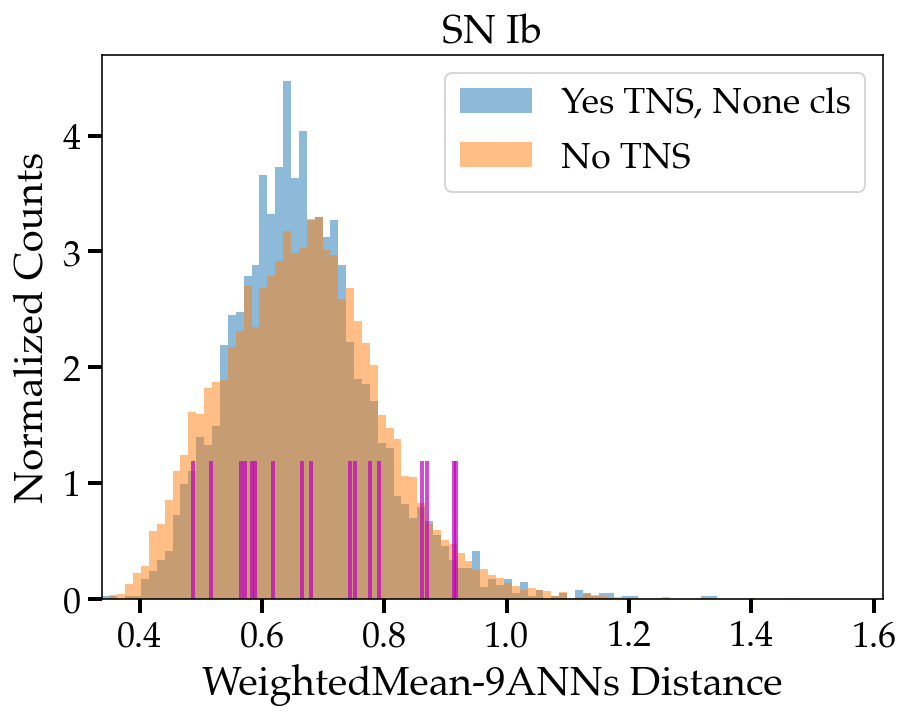

SN Ib-pec
Mean 0.9088337164033543


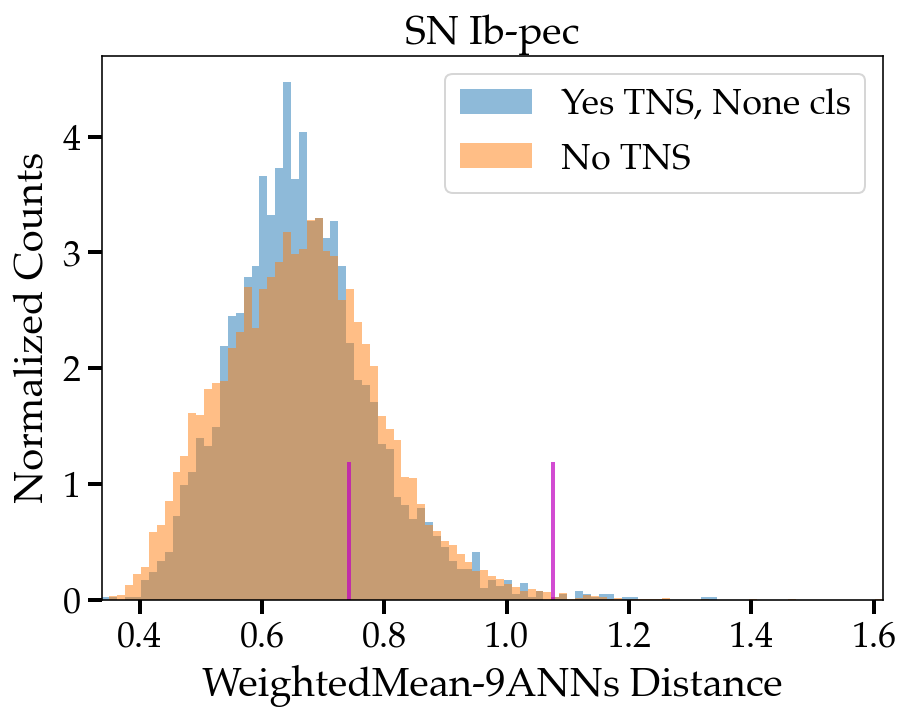

SN Ib/c
Mean 0.7246752595811179


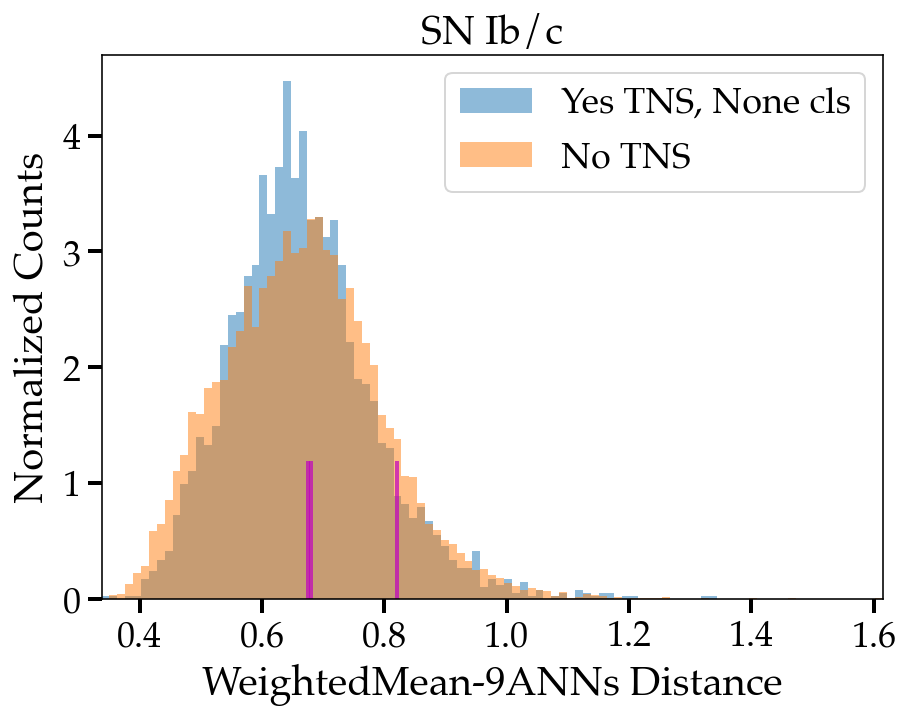

SN Ibn
Mean 0.7105241446671161
https://alerce.online/object/ZTF21aagyidr


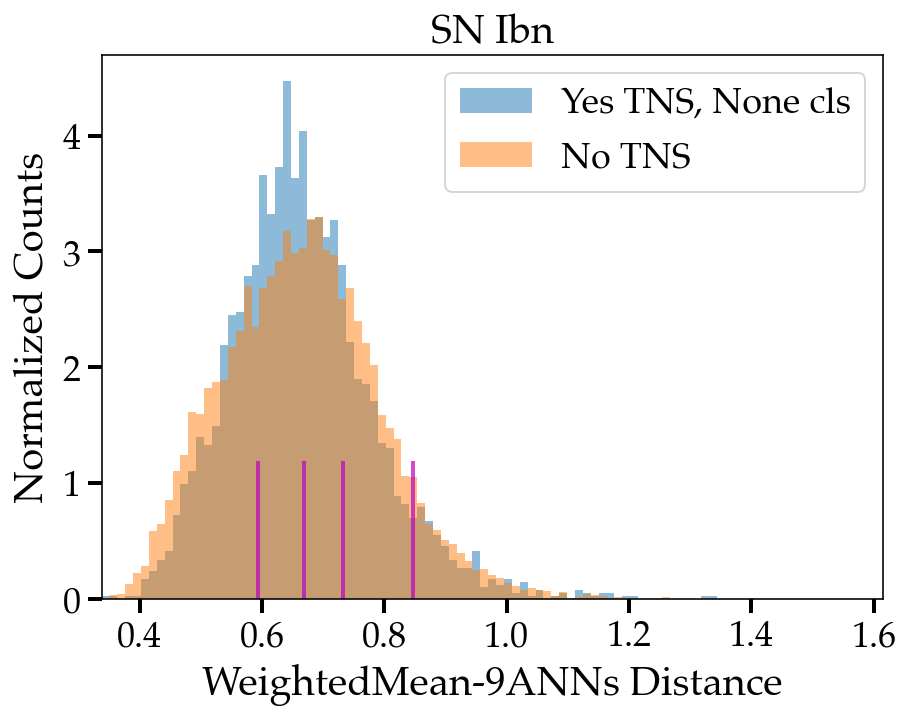

SN Ic
Mean 0.7263559382597004
https://alerce.online/object/ZTF20abwxywy
https://alerce.online/object/ZTF20aclnplo
https://alerce.online/object/ZTF20actpqgc
https://alerce.online/object/ZTF20acuxjus
https://alerce.online/object/ZTF21aacufip
https://alerce.online/object/ZTF21aannoix
https://alerce.online/object/ZTF21abklcjq


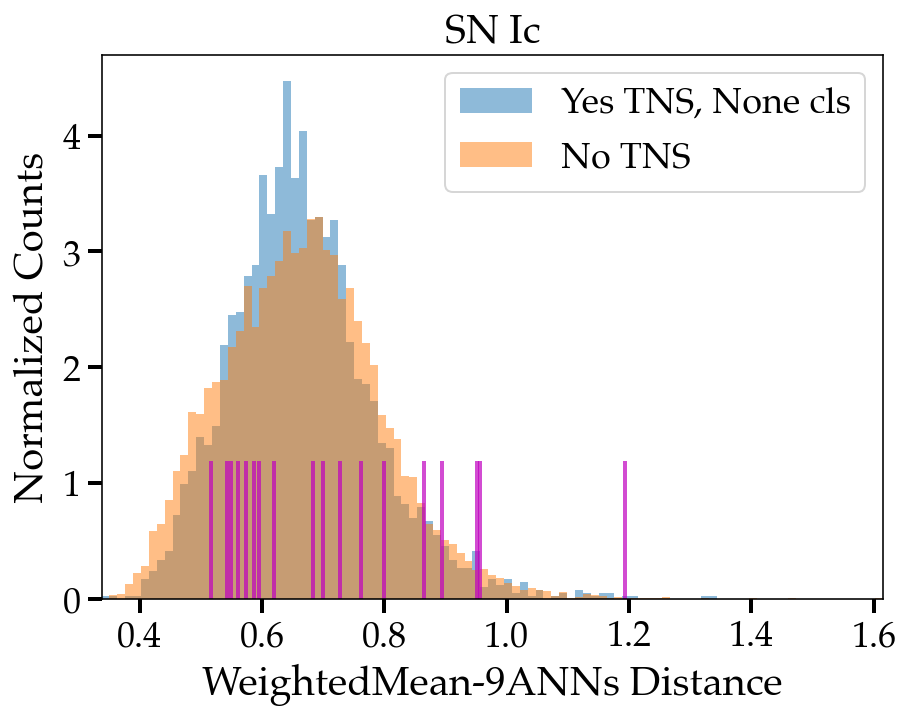

SN Ic-BL
Mean 0.7389664491168176
https://alerce.online/object/ZTF21acekmmm


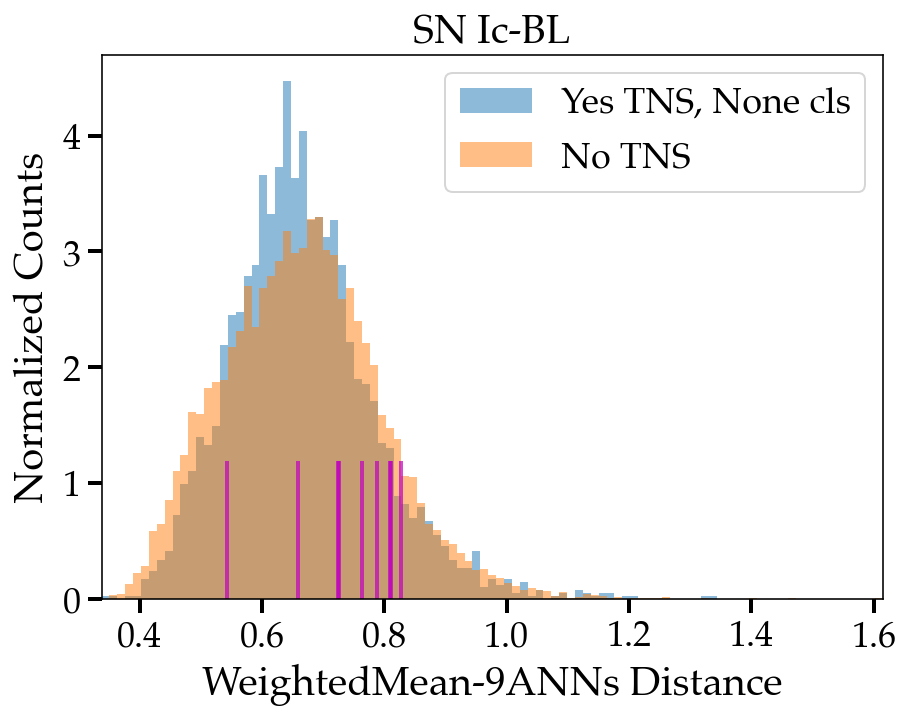

SN Icn
Mean 0.617228318344463


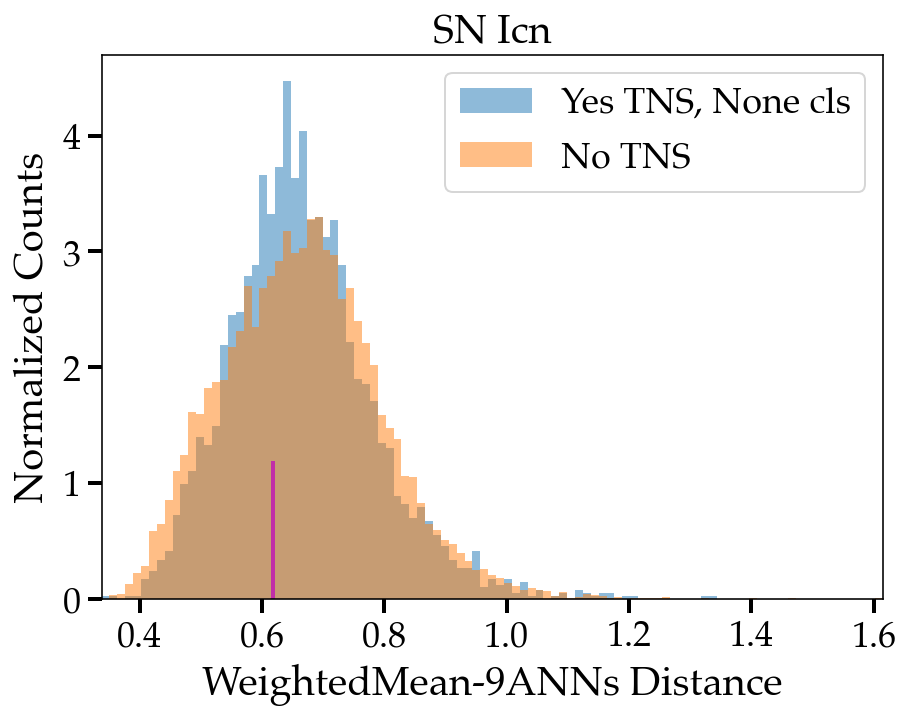

TDE
Mean 0.6869517156120504
https://alerce.online/object/ZTF20acitpfz
https://alerce.online/object/ZTF21aaaokyp
https://alerce.online/object/ZTF21aapvvtb


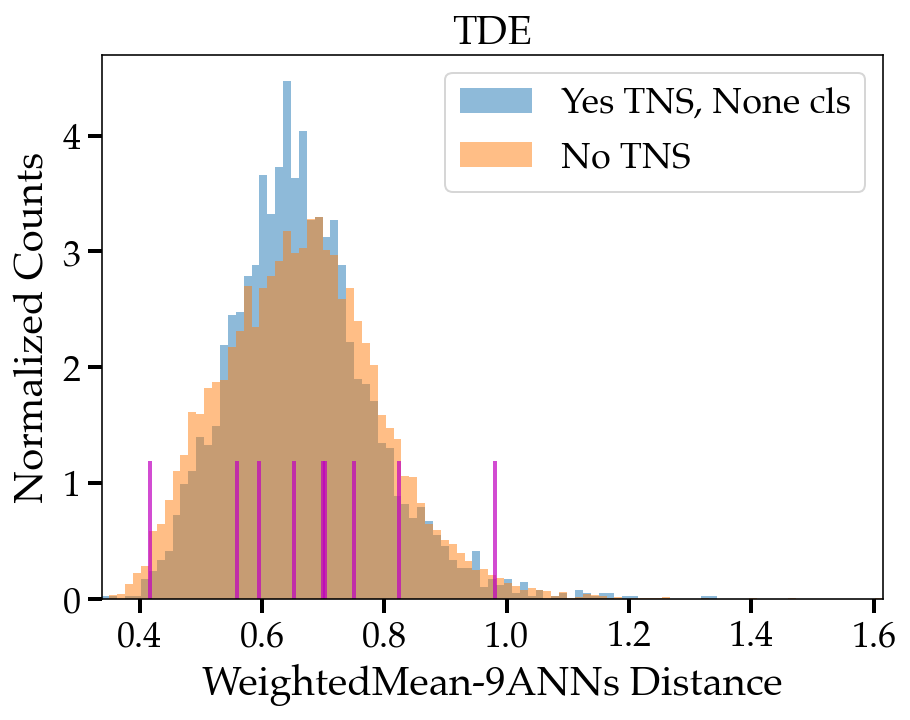

In [260]:
# for cls in np.unique(ann_dist_all_tns_df.tns_cls):
    
#     print(cls)
    
    
cls_scatter_l = []
for cls in np.unique(ann_dist_all_tns_df.tns_cls):
    print(cls)
    fig, ax = plt.subplots()
    
    min_feat, max_feat = np.min(ann_dist_all_tns_df['WeightedMean-9ANNs']), np.max(ann_dist_all_tns_df['WeightedMean-9ANNs'])
    
    # Submitted to TNS, no class
    yes_tns_df = ann_dist_all_tns_df[ann_dist_all_tns_df['has_tns'] == 'Yes_TNS']
    # Not submitted to TNS
    no_tns_df = ann_dist_all_tns_df[ann_dist_all_tns_df['has_tns'] == 'No_TNS']
    
    cls_df = ann_dist_all_tns_df[ann_dist_all_tns_df.tns_cls == cls]['WeightedMean-9ANNs']
    
    yes_tns_none_cls_df = yes_tns_df[yes_tns_df.tns_cls == "None"]['WeightedMean-9ANNs']
    no_tns_none_cls_df = no_tns_df[no_tns_df.tns_cls == "None"]['WeightedMean-9ANNs']
    
    
    #ax.hist(cls_df, bins=np.linspace(min_feat, max_feat, 100))
    ax.hist(yes_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="Yes TNS, None cls")
    ax.hist(no_tns_none_cls_df, bins=np.linspace(min_feat, max_feat, 100), alpha=0.5, density=True,
            label="No TNS")
    
    print("Mean", np.mean(cls_df))
    
    #ref = dataset_bank[dataset_bank.index == ref_obj]
    #print(cls_df)
    if cls != "None":
        for ix, v in enumerate(cls_df):
            ax.axvline(v, color='m', alpha=0.7, ymin=0, ymax=0.25)
            if v <= 0.6: #np.mean(cls_df):
                print(f'https://alerce.online/object/{cls_df.index[ix]}') # greater than mean
            
    ax.set_title(cls)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    
    plt.ylabel('Normalized Counts')
    plt.xlabel('WeightedMean-9ANNs Distance')
    plt.show()
    
    cls_scatter = np.std(cls_df)
    cls_scatter_l.append(cls_scatter) 

# Rare class not always high distance away... wonder if it will be fixed with stars removed
# rare class with high 9ann dist usually is bright, at core, or those + half observed (e.g., no rise)

In [222]:
tns_none_cls_df = ann_dist_all_tns_df[ann_dist_all_tns_df.tns_cls == 'None']

tns_none_cls_w9anng1_df = tns_none_cls_df[(tns_none_cls_df['WeightedMean-9ANNs'] >= 1) & (tns_none_cls_df['has_tns'] == "No_TNS")]
tns_none_cls_w9anng1_df

ann=0  ann=1  ann=2  ann=3  ann=4  ann=5  ann=6  ann=7  ann=8  \
ZTF17aaahmid   8268  18562  14525     86  10519    121   3693   9703  17442   
ZTF17aaatwmn  17027  11108   1165   5739  15360  18818   2542  13194    318   
ZTF17aabvsex   1670  11176   3796   1332  14643   9910  15221  14459   5156   
ZTF17aadilht  14772  13593   8250   7346   2405   9611  17627   1220    812   
ZTF18aaabjgd  13899    871   9410  13508  16923  18594  15573  16072  11754   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
ZTF21aalnuqg  11206  14835  14767  16274  18031  15622  11372   4964  17873   
ZTF21aaxntve  10997    611  16741   3283   7667  14747  10088  15289   4089   
ZTF21abctayz  12851  13327   5871  11576    988  16263  17388  18338  10955   
ZTF21absyiyh   9656   7635  13975  14160   6058   1146   8485  12866   5147   
ZTF21acapylm   6042    970  16198  11489  11956   7834   1935   6931  10737   

              ann=9  ...    dist=6    dist=7    dist=8    dist=9  Mean-9ANNs  \
ZTF17aaahmid   9348  ...  1.161816  1.163453  1.192659  1.202011    1.154385   
ZTF17aaatwmn   3868  ...  1.118425  1.122099  1.132497  1.134873    1.110637   
ZTF17aabvsex   1050  ...  1.050887  1.056138  1.065023  1.100025    1.036410   
ZTF17aadilht  11243  ...  1.170710  1.180622  1.181275  1.181772    1.123248   
ZTF18aaabjgd   3200  ...  1.110159  1.130512  1.140311  1.164177    1.082049   
...             ...  ...       ...       ...       ...       ...         ...   
ZTF21aalnuqg   4026  ...  1.168874  1.178652  1.183301  1.198971    1.137146   
ZTF21aaxntve   8456  ...  1.563523  1.571261  1.574631  1.577017    1.529680   
ZTF21abctayz   5067  ...  1.048065  1.050621  1.060098  1.101660    1.036268   
ZTF21absyiyh   8343  ...  1.143873  1.179993  1.207709  1.215963    1.117107   
ZTF21acapylm  13067  ...  1.124536  1.146829  1.147472  1.157683    1.117028   

              WeightedMean-9ANNs  has_tns  tns_cls  spec_z  report_group  
ZTF17aaahmid            1.126539   No_TNS     None   -99.0          None  
ZTF17aaatwmn            1.090332   No_TNS     None   -99.0          None  
ZTF17aabvsex            1.001277   No_TNS     None   -99.0          None  
ZTF17aadilht            1.055763   No_TNS     None   -99.0          None  
ZTF18aaabjgd            1.019243   No_TNS     None   -99.0          None  
...                          ...      ...      ...     ...           ...  
ZTF21aalnuqg            1.064823   No_TNS     None   -99.0          None  
ZTF21aaxntve            1.472271   No_TNS     None   -99.0          None  
ZTF21abctayz            1.006582   No_TNS     None   -99.0          None  
ZTF21absyiyh            1.045300   No_TNS     None   -99.0          None  
ZTF21acapylm            1.093481   No_TNS     None   -99.0          None  

[147 rows x 26 columns]

In [223]:
for ind in tns_none_cls_w9anng1_df.index:
    print(f'https://alerce.online/object/{ind}')

https://alerce.online/object/ZTF17aaahmid
https://alerce.online/object/ZTF17aaatwmn
https://alerce.online/object/ZTF17aabvsex
https://alerce.online/object/ZTF17aadilht
https://alerce.online/object/ZTF18aaabjgd
https://alerce.online/object/ZTF18aaabprw
https://alerce.online/object/ZTF18aaapepk
https://alerce.online/object/ZTF18aaaubqm
https://alerce.online/object/ZTF18aabehyt
https://alerce.online/object/ZTF18aabfdrc
https://alerce.online/object/ZTF18aabfmcc
https://alerce.online/object/ZTF18aabhmmj
https://alerce.online/object/ZTF18aabjkom
https://alerce.online/object/ZTF18aabjliz
https://alerce.online/object/ZTF18aabnboa
https://alerce.online/object/ZTF18aabtugl
https://alerce.online/object/ZTF18aacbuof
https://alerce.online/object/ZTF18aahkoar
https://alerce.online/object/ZTF18aahmxpk
https://alerce.online/object/ZTF18aajcvol
https://alerce.online/object/ZTF18aaksjil
https://alerce.online/object/ZTF18aalnemq
https://alerce.online/object/ZTF18aamnlze
https://alerce.online/object/ZTF18

In [ ]:
# 2021ij super bright and no class: https://alerce.online/object/ZTF21aaaqtwd
# 2020eyj: Ia but totally Ia CSM: https://alerce.online/object/ZTF20aatxryt